In [1]:
import numpy as np
import os
import sys
sys.path.append('/Users/ashish/Documents/GitHub/Ecology-Stochasticity/')
from sys import exit
import pandas as pd
import glob
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy
import seaborn as sns
import analyze_landscape
from my_CR_model_functions import rms, create_replicate_lists
from collections import OrderedDict
from scipy.stats import spearmanr
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde
#import community_simulator.visualization
#from analyze_landscape import diversity_index

# import matplotlib as mpl
# nice_fonts = {
# "font.family": "Helvetica",
# }
# mpl.rcParams.update(nice_fonts)

###setting color paletter default
# sns.set_palette("deep")

# Disable printing
def blockPrint():
    sys.stdout = open(os.devnull, 'w')
# Restore printing
def enablePrint():
    sys.stdout = sys.__stdout__

# mycolor = [0 0.4470 0.7410;
#  0.8500 0.3250 0.0980;
#  0.9290 0.6940 0.1250;
#  0.4940 0.1840 0.5560;
#  0.4660 0.6740 0.1880;
#  0.3010 0.7450 0.9330;
#  0.6350 0.0780 0.1840];
matlab_blue=[0, 0.4470, 0.7410]

fontSize=12
labelSize=10
sfontSize=9
def create_matlab_color_cycler(n, left=[0, 0.6, 1], right=[1, 0.1, 0]): ## these default values from keisuke's fig1
    assert n>1
    color_array=np.zeros((n,3))
    color_array[:,0]=np.linspace(left[0],right[0],n)
    color_array[:,1]=np.linspace(left[1],right[1],n)
    color_array[:,2]=np.linspace(left[2],right[2],n)
    return color_array

def create_color_list(scheme_name='base'): 
    #https://matplotlib.org/3.1.0/gallery/color/named_colors.html
    #https://seaborn.pydata.org/tutorial/color_palettes.html
    if scheme_name.lower()=='tableau':
        color_list=list(mcolors.TABLEAU_COLORS.values())## only had 10 colors
    elif scheme_name.lower()=='xkcd':
        color_list=list(mcolors.XKCD_COLORS.values())
    elif scheme_name.lower()=='css':
        color_list=list(mcolors.CSS4_COLORS.values())
    elif scheme_name.lower()=='base':
        color_list=list(mcolors.BASE_COLORS.values())
    elif scheme_name.lower()=='sns_tab10':
        color_list=list(sns.color_palette(palette='tab10'))
    elif scheme_name.lower()=='sns_deep':
        color_list=list(sns.color_palette(palette='deep'))
    elif scheme_name.lower()=='sns_muted':
        color_list=list(sns.color_palette(palette='muted'))
    elif scheme_name.lower()=='sns_colorblind':
        color_list=list(sns.color_palette(palette='colorblind'))
    elif scheme_name.lower()=='sns_spectral':
        color_list=list(sns.color_palette(palette='Spectral'))
    else:
        print ('scheme not implemented')
    if 'sns' not in scheme_name.lower():
        color_list=[color for color in color_list if sum(mcolors.to_rgb(color))<2.5] ## remove white
        mcolors.to_rgb(color_list[0])

    return  color_list


def read_sim_data(file_name):
    data = pickle.load(open(file_name, 'rb')) 
    sigma_vectors= (data['initial_abundance'].T>0).astype(int)
    N_obs=data['steady_state'].T  
    S=len(sigma_vectors[0])  
    n_exp=len(N_obs)
    
    return data,sigma_vectors, N_obs, S, n_exp

############## other shared functions that are required for some plots############


popn_cutoff=1e-5
def load_2D_metric_AVGarray(fold_avg, key_names, 
                         parameter_list=OrderedDict([ ('SM',[4, 8, 12, 16] ), ('mean_c', '1 to param1')]),
                         file_suffix='S_2D_w_gamma',
                         xlabel_2D=r'community size, $S,M$',ylabel_2D=r'consumption sparsity, $\phi$' ):
    print( len(parameter_list))
    fold_list=[fold_avg]    
    parameter_names=list(parameter_list.keys())
    folder_name_list,parameter_list=create_replicate_lists(parameter_list,fold_list, 0) ### creates a longer list enumerating all the folders.
    Folders_Label=parameter_names
    Folders_values=parameter_list 
    keyName_was_a_string=False
    if type(key_names) is str:
        print ('converting string to list')
        key_names=[key_names]
        keyName_was_a_string=True
    fitness_measure_name=key_names[0].split(':')[0]
    metric_array=[]
    metric_error_array=[]
    successfully_run_folders=np.ones(len(folder_name_list), dtype=bool)
    for i,fold in enumerate(folder_name_list):    
        analysis_filename=fold+'AvgAnalysis_'+file_suffix+'.dat'       
        analysis_data=pickle.load(open(analysis_filename, 'rb')) 
        assert analysis_data['Number of replicates']>1, 'need more than one for error bar'
        if key_names[0] in analysis_data.keys():
    
            metric_value=[analysis_data[x] for x in key_names]            
            metric_array.append(metric_value)
            metric_error=[np.sqrt(analysis_data[x+'-Variance']/analysis_data[fitness_measure_name+': Number of replicates']) for x in key_names]
            metric_error_array.append( metric_error )   
        else:
            print (key_names[0])
            print (analysis_data.keys())
            print (analysis_data[key_names[0]])
            successfully_run_folders[i]=False
            print("failed in",fold)

#         metric_array=np.append(metric_array,analysis_data[key_name])
#         metric_error_array=np.append(metric_error_array, np.sqrt(analysis_data[key_name+'-Variance']/analysis_data['Number of replicates']  ))
        
    Xval=np.asarray(parameter_list)[successfully_run_folders,0]
    Yval=np.asarray(parameter_list)[successfully_run_folders,1]
    Yval=Yval/Xval
    Zval=np.asarray(metric_array)[successfully_run_folders]
    Zerr=np.asarray(metric_error_array)[successfully_run_folders]    
    Zval=Zval.squeeze()
    Zerr=Zerr.squeeze()
    return Xval, Yval, Zval, Zerr
    
def calculate_R2_values(fold):
    data = pickle.load(open(fold+file_suffix+'.dat', 'rb')) 
    sigma_vectors= (data['initial_abundance'].T>0).astype(int)
    N_obs=data['steady_state'].T
    N_obs[N_obs<popn_cutoff]=0.0
    S=len(sigma_vectors[0])  
    n_exp=len(N_obs)    
    Y_vectors_test,Y_vectors_pred,_, R2_avg, R2_VW, R2_Flattened, reg_dict=analyze_landscape.perform_Linear_Regression_of_abundance_vector_by_subsetting(N_obs, sigma_vectors, S ,verbose=False) 
    '''
    reg_dict={'Y_vectors_test':Y_vectors_test,'Y_vectors_pred':Y_vectors_pred,'interaction_matrix':interaction_matrix, 'R2_avg': R2_avg, 'R2_VW': R2_VW,'R2_Flattened':R2_Flattened}
    '''

    return reg_dict
def get_XY_from_AGGdict(agg_data, parameter_list, df_keyname_prefix_list, X_key,Y_key):
    Xlist=[]
    Ylist=[]
    for idx in range(len(parameter_list)):      
        if isinstance(X_key, str):
            df_keynameX=df_keyname_prefix_list[idx]+X_key
            xval=agg_data[df_keynameX]
        else:
            df_keynameX=df_keyname_prefix_list[idx]+X_key[0]
            xval=[]
            for sub_list in agg_data[df_keynameX]:
                if sub_list is not None:
                    if len(X_key)==2:
                        xval.append(sub_list[X_key[1]])
                    elif len(X_key)==3:
                        xval.append(sub_list[X_key[1]][X_key[2]])
                    else:
                        print ('len(X_key) was ', len(X_key), X_key)
                        sys.exit(1)
                    
                else:
                    xval.append(None)
        if isinstance(Y_key, str):
            df_keynameY=df_keyname_prefix_list[idx]+Y_key
            yval=agg_data[df_keynameY]
#             print (df_keynameY, " is ", agg_data[df_keynameY])
        else:
            df_keynameY=df_keyname_prefix_list[idx]+Y_key[0]
            yval=[]
            for sub_list in agg_data[df_keynameY]:
                if sub_list is not None:
                    yval.append(sub_list[Y_key[1]]) 
                else:
                    
                    yval.append(None)

        
        Xlist.append(xval)
        Ylist.append(yval)
    return np.ravel(Xlist), np.ravel(Ylist)

def remove_Nones(Xvalues,Yvalues):
    idx_true=np.intersect1d(np.where(Xvalues!=None),np.where(Yvalues!=None), assume_unique=True)      
    return Xvalues[idx_true],Yvalues[idx_true]

def replace_Nones_with(A,value=0):
    A=np.array(A) ## required for boolean indexing
#     print (A)
#     print (np.equal(np.array(A), None))
    A[np.equal(A, None)]=value
    return A

def remove_Nones_3arr(X1values,X2values, X3values): ## if there are 3 arrays to simultaneously reduce
    from functools import reduce
    idx_true=reduce(np.intersect1d, (np.where(X1values!=None), np.where(X2values!=None), np.where(X3values!=None)))   
    return X1values[idx_true],X2values[idx_true],X3values[idx_true]

def plot_avg_and_err(ax, Xval, Yval, Yerr, plot_fmt='-o',fc='b',label=None):    
    if label is None:
        ax.plot(Xval, Yval, plot_fmt, color=fc )
    else:
        ax.plot(Xval, Yval, plot_fmt, color=fc, label=label)
    ax.fill_between(Xval, Yval-Yerr, Yval+Yerr, facecolor=fc, alpha=0.5)
    return ax

def get_X_and_est_from_AGGdict(agg_data, parameter_list, df_keyname_prefix_list, X_key, estFrac_key, est_key, fraction_chosen, avg_the_estimate=False) :
    assert isinstance(fraction_chosen, float) or isinstance(fraction_chosen, int),"this function does not accept a list of fractions at a time"
    '''
    if avg_the_estimate is True, 
    then the estimated ruggedness of a particular landscape is the average of ten different attempts at estimation and stderr is returned
    if avg_the_estimate is False, 
    then the estimated ruggedness of a particular landscape is obtained from a SINGLE sampling of the landscape.
    '''   
    Xlist=[]
    ESTlist=[]
    EST_stderr_list=[]
    for idx in range(len(parameter_list)):            
        df_keynameX=df_keyname_prefix_list[idx]+X_key
        xval=agg_data[df_keynameX]
        df_keyname_Frac=df_keyname_prefix_list[idx]+estFrac_key
        df_keyname_Est=df_keyname_prefix_list[idx]+est_key
        frac_lists=agg_data[df_keyname_Frac]
        est_value=[]
        est_stderr=[]
        for i,frac_list in enumerate(frac_lists):
            if frac_list!=None and frac_list!=[0]:
                frac_list=np.array(frac_list)
                idx_est=np.intersect1d(np.where(frac_list>.99*fraction_chosen)[0],np.where(frac_list<1.01*fraction_chosen)[0])                
                if len(idx_est)>0:
                    idx_est=int(idx_est[0]) if len(idx_est)>1 else int(idx_est)
                    ## I provided duplicate fractions once leading to two duplicate estimates, we will use only one
                                      
                    temp_arr=np.array(agg_data[df_keyname_Est][i])
#                     print ('frac is :', frac_list )
#                     print ('shape of temp_arr is :', np.shape(temp_arr))
#                     print (temp_arr)
                    
                    if avg_the_estimate:  
                        if isinstance(temp_arr[idx_est], (int,float, np.floating, np.int)) :
                            est_value.append(None)
                            est_stderr.append(None)
                            
                        elif len(temp_arr[idx_est])>1:
                            est_value.append(np.mean(temp_arr[idx_est]))
                            est_stderr.append(np.std(temp_arr[idx_est])/np.sqrt(len(temp_arr[idx_est])))
                        else:
                            est_value.append(None)
                            est_stderr.append(None)
                            
                    else:
                        if isinstance(temp_arr[idx_est], (int,float, np.floating, np.int) ):
                            est_value.append(float(temp_arr[idx_est]))
                        elif len(temp_arr[idx_est])>1:## use only the first estimate
                            est_value.append(float(temp_arr[idx_est][0]))
                        else:
                            print ('what?',len(temp_arr[idx_est]),temp_arr[idx_est])
                                  
                else:
                    est_value.append(None)
            else:
                est_value.append(None)
        Xlist.append(xval)
        ESTlist.append(est_value) 
        if avg_the_estimate:
            EST_stderr_list.append(est_stderr)
        
    return np.ravel(Xlist), np.ravel(ESTlist), np.ravel(EST_stderr_list) 



def calc_avg_and_err_over_levels(value_arr, level_arr): ## average over data at a given level and return levels and standard error
    unq_lvls= np.asarray(list(set(level_arr)))
    avgs=[]
    errs=[]
    for lvl in unq_lvls:
        values=value_arr[np.where(level_arr==lvl)]
#         print (lvl,len(values))
        avgs.append(np.mean(values))
        errs.append(np.std(values)/np.sqrt(len(values)) )  
    return unq_lvls, np.asarray(avgs), np.asarray(errs)
    

def plot_SpearmanScatterplot(ax, Xvalues, Yvalues, label_name='', color='g', text_rho=False, text_loc=None,textcolor='k' ):
    SpearmanRvalue=spearmanr(Xvalues, Yvalues).correlation
    ax.plot(Xvalues, Yvalues,'o',  color=color,label=label_name)    
    if text_rho:
        if text_loc==None:
            if SpearmanRvalue >0.:
                plt.text(0.05, 0.9, r'$\rho =$'+'{:.2f}'.format(SpearmanRvalue),horizontalalignment='left', verticalalignment='top', transform=ax.transAxes,fontsize=fontSize, color=textcolor)    
            if SpearmanRvalue <0.:
                plt.text(0.95, 0.97, r'$\rho =$'+'{:.2f}'.format(SpearmanRvalue),horizontalalignment='right', verticalalignment='top', transform=ax.transAxes,fontsize=fontSize, color=textcolor)    
        else:
            plt.text(text_loc[0], text_loc[1], r'$\rho =$'+'{:.2f}'.format(SpearmanRvalue),horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes,fontsize=fontSize, color=textcolor)
                
    return ax









# Landscape linearity


## temp

2
UB= 5
UB= 9
UB= 13
UB= 17
converting string to list


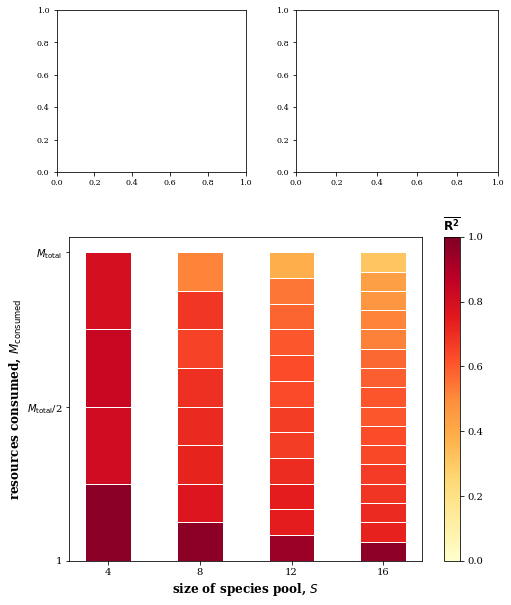

In [3]:
from matplotlib.colors import Normalize
from scipy.interpolate import interpn
import time
from sklearn.neighbors import KernelDensity
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
destfolder = '/Users/ashish/Dropbox/research/ecology/Figures/Fig_LandscapeLinearity_and_InteractionSparsity/'
fold_avg = "/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled_AVG/"
fold_agg = "/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled_AGG/"

fold_landscape1 = "/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled/SM16mean_c16/0/"
fold_landscape2 = "/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled/SM12mean_c2/0/"
# 14 consumed:fold_landscape1="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled/SM16mean_c14/1/"

parameter_list = OrderedDict(
    [('SM', [4, 8, 12, 16]), ('mean_c', '1 to param1')])
ax1_Apos = [12, 1./12]
ax1_Bpos = [16, 13./16]

# for testing:
# fold_landscape1="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled/SM8mean_c5/0/"
# fold_landscape2="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled/SM8mean_c5/0/"

# for SMp5
# fold_avg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SMp5_CfixednumGamma_meanC_compiled_AVG/"
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SMp5_CfixednumGamma_meanC_compiled_AGG/"
# fold_landscape1="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SMp5_CfixednumGamma_meanC_compiled/SMp516mean_c7/0/"
# fold_landscape2="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SMp5_CfixednumGamma_meanC_compiled/SMp512mean_c2/1/"
# parameter_list=OrderedDict([ ('SMp5',[8, 12, 16 ] ), ("mean_c", "1 to param1{'step_size' : 1, 'UB_X' : 0.5}")])
# ax1_Apos=[12, 1.5/6]
# ax1_Bpos=[16, 6.5/8]

metric_name = 'R2-avg'
key_name = 'landscape structure: Abundance vector fit Subsetted R2avg'
key_name_in_landscape_dict = 'R2_avg'
label_name = r'$\overline{R^2}$'

# metric_name='R2-Flat'
# key_name='landscape structure: Abundance vector fit Subsetted R2 Flattened'
# key_name_in_landscape_dict='R2_Flattened'
# label_name=r'$R^2_{flat}$'

# metric_name='R2-VW'
# key_name='landscape structure: Abundance vector fit Subsetted R2'
# key_name_in_landscape_dict='R2_VW'
# label_name=r'$R^2_{VW}$'


Xval, Yval, Zval, Zerr = load_2D_metric_AVGarray(
    fold_avg, key_name, parameter_list)
# Xval, Yval, Zval, Zerr=load_2D_metric_AVGarray(fold_avg,key_name)
file_suffix = 'S_2D_w_gamma'
# import matplotlib

fontSize = 12
labelSize = 10


############### 2D colored bar plot of R^2 with insets ##############
normalize = mpl.colors.Normalize(vmin=0.0, vmax=1.0)

cmap_phasediag = 'YlOrRd'  # 'spring'#'YlOrRd'
mapper = cm.ScalarMappable(norm=normalize, cmap=cmap_phasediag)
Zcolor = np.array([(mapper.to_rgba(v)) for v in Zval])
fig_temp = plt.figure(figsize=(3.5, 3.5))
# create a scatter plot with zero sized markers
sc = plt.scatter(Xval, Yval, s=0, c=Zval, cmap=cmap_phasediag, norm=normalize)
plt.close(fig_temp)


fig = plt.figure(figsize=(7, 9))
gs_1 = fig.add_gridspec(nrows=1, ncols=1, left=0.1,
                        right=0.475, top=.95, bottom=0.7)
gs_2 = fig.add_gridspec(nrows=1, ncols=1, left=0.575,
                        right=0.975, top=.95, bottom=0.7)

ax2 = fig.add_subplot(gs_1[0])
ax3 = fig.add_subplot(gs_2[0])
# gs_top_row=fig.add_gridspec(nrows=1,ncols=2, left=0.1, right=0.9, top=0.95, bottom=0.7, wspace=.2)
# gs2= gs_top_row[0,0].subgridspec(2, 2, width_ratios=[20,1], wspace=0.05, hspace=0.1)
# ax2=fig.add_subplot(gs2[:,0])
# # cbar_ax2_1=fig.add_subplot(gs2[0,1])
# # cbar_ax2_2=fig.add_subplot(gs2[1,1])
# gs3= gs_top_row[0,1].subgridspec(2, 2, width_ratios=[20,1], wspace=0.05, hspace=0.1)
# ax3=fig.add_subplot(gs3[:,0])
# cbar_ax3_1=fig.add_subplot(gs3[0,1])
# cbar_ax3_2=fig.add_subplot(gs3[1,1])
gs_heatmap = fig.add_gridspec(
    nrows=1, ncols=1, left=0.125, right=1., top=.6, bottom=0.1, wspace=.1)
ax1 = fig.add_subplot(gs_heatmap[0])


######################################## plotting panel C (heatmap) ###########################
# create colorbar according to the scatter plot
cbar = fig.colorbar(sc, ax=ax1, cmap=cmap_phasediag)
# cbar.ax.get_yaxis().labelpad = 15
# cbar.ax.set_ylabel(metric_name, rotation=270, fontweight='bold',fontsize=fontSize)
cbar.ax.set_title(r'$\mathbf{\overline{R^2}}$', fontweight='bold', fontsize=fontSize)
cbar.ax.tick_params(labelsize=labelSize)

for xvalue in list(set(Xval)):
    idx = np.where(Xval == xvalue)
    y_subset = Yval[idx]
    Z_subset = Zval[idx]
    ordered_subidx = np.argsort(y_subset)
    n_points = len(y_subset)
#     zvalue=Z_subset[ordered_subidx][0]
#     ax1.bar(xvalue,1./n_points,color=mapper.to_rgba(zvalue), width=2.,edgecolor='w' )
    for i in range(0, n_points):
        zvalue = Z_subset[ordered_subidx][i]
        ax1.bar(xvalue, 1./n_points, bottom=i*1./n_points,
                color=mapper.to_rgba(zvalue), width=2., edgecolor='w')

ax1.set_xlabel(r'size of species pool, $S$',
               fontweight='bold', fontsize=fontSize)
ax1.set_ylabel(r'resources consumed, $M_{\mathrm{consumed}}$', fontweight='bold', fontsize=fontSize)
ax1.set_yticks(ticks=[0, 0.5, 1.0])
ax1.set_yticklabels([r'1', r'$M_{\mathrm{total}}$/2', r'$M_{\mathrm{total}}$'], fontsize=labelSize)


ax1.set_xticks(ticks=[4, 8, 12, 16])
ax1.set_xticklabels(labels=[4, 8, 12, 16], fontsize=labelSize)
#ax1.set_title(label_name, fontweight='bold',fontsize=fontSize)
# ax1.text(-0.01, 0.04, '(specialists)', color='k', fontsize=labelSize,
#          horizontalalignment='right', verticalalignment='bottom', transform=ax1.transAxes)

# ax1.text(-0.01, 0.925, '(generalists)', color='k', fontsize=labelSize,
#          horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes)




##ax1.text(12, 1./12,'A',color='k',fontsize=fontSize,horizontalalignment='center',verticalalignment='bottom')
##ax1.text(16, 13./16,'B',color='k',fontsize=fontSize,horizontalalignment='center',verticalalignment='bottom')
##ax1.text(12, 1./12,'A',color='k',fontsize=fontSize,horizontalalignment='center',verticalalignment='bottom')
##ax1.text(16, 13./16,'B',color='k',fontsize=fontSize,horizontalalignment='center',verticalalignment='bottom')

# ax1.text(-0.2, 1.05, 'C', fontweight="bold",
#          transform=ax1.transAxes, fontsize=fontSize)
# ax2.text(-0.2, 1.05, 'A', fontweight="bold",
#          transform=ax2.transAxes, fontsize=fontSize)
# ax3.text(-0.2, 1.05, 'B', fontweight="bold",
#          transform=ax3.transAxes, fontsize=fontSize)

fig.patch.set_facecolor('white')

# plt.savefig(destfolder+metric_name+"-png", dpi=400)
# plt.savefig(destfolder+metric_name+"-.pdf")




## Fig 3 panel 3-21

2
UB= 5
UB= 9
UB= 13
UB= 17
converting string to list
We clip negative abundances  before calculating R^2
R2avg, R2_VW, R2_manual,  0.7110559544554055 0.7247726626170214 0.7247726626170203
R2Flat, R2Flat unclipped 0.8995798225283784 0.8911576492776315
ax2, max of sim and prediction is  51.14440644122124 55.73203011578591
min, max of z is  9.005501128589772e-06 0.010953412834994122
time for gaussian kde 6.274937152862549


/Users/ashish/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:166: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


We clip negative abundances  before calculating R^2
R2avg, R2_VW, R2_manual,  0.34961452917832914 0.7908766344222388 0.7908766344222407
R2Flat, R2Flat unclipped 0.9518777821261329 0.9450642595799378
ax3, max of sim and prediction is  355.140112102232 354.54071170619864


KeyboardInterrupt: 

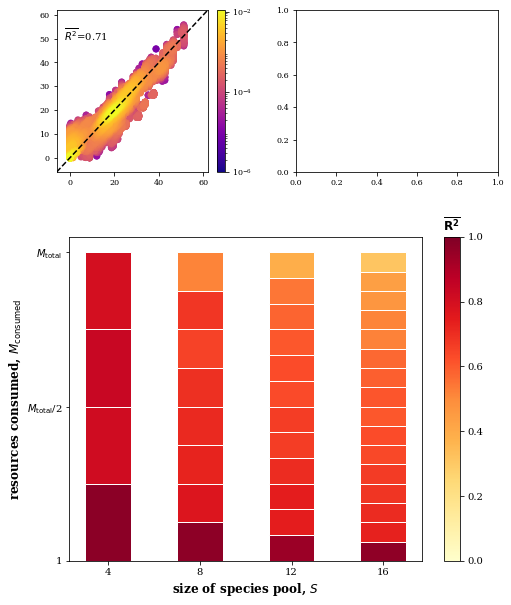

In [2]:
from matplotlib.colors import Normalize
from scipy.interpolate import interpn
import time
from sklearn.neighbors import KernelDensity
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
destfolder = '/Users/ashish/Dropbox/research/ecology/Figures/Fig_LandscapeLinearity_and_InteractionSparsity/'
fold_avg = "/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled_AVG/"
fold_agg = "/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled_AGG/"

fold_landscape1 = "/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled/SM16mean_c16/0/"
fold_landscape2 = "/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled/SM12mean_c2/0/"
# 14 consumed:fold_landscape1="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled/SM16mean_c14/1/"

parameter_list = OrderedDict(
    [('SM', [4, 8, 12, 16]), ('mean_c', '1 to param1')])
ax1_Apos = [12, 1./12]
ax1_Bpos = [16, 13./16]

# for testing:
# fold_landscape1="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled/SM8mean_c5/0/"
# fold_landscape2="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled/SM8mean_c5/0/"

# for SMp5
# fold_avg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SMp5_CfixednumGamma_meanC_compiled_AVG/"
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SMp5_CfixednumGamma_meanC_compiled_AGG/"
# fold_landscape1="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SMp5_CfixednumGamma_meanC_compiled/SMp516mean_c7/0/"
# fold_landscape2="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SMp5_CfixednumGamma_meanC_compiled/SMp512mean_c2/1/"
# parameter_list=OrderedDict([ ('SMp5',[8, 12, 16 ] ), ("mean_c", "1 to param1{'step_size' : 1, 'UB_X' : 0.5}")])
# ax1_Apos=[12, 1.5/6]
# ax1_Bpos=[16, 6.5/8]

metric_name = 'R2-avg'
key_name = 'landscape structure: Abundance vector fit Subsetted R2avg'
key_name_in_landscape_dict = 'R2_avg'
label_name = r'$\overline{R^2}$'

# metric_name='R2-Flat'
# key_name='landscape structure: Abundance vector fit Subsetted R2 Flattened'
# key_name_in_landscape_dict='R2_Flattened'
# label_name=r'$R^2_{flat}$'

# metric_name='R2-VW'
# key_name='landscape structure: Abundance vector fit Subsetted R2'
# key_name_in_landscape_dict='R2_VW'
# label_name=r'$R^2_{VW}$'


Xval, Yval, Zval, Zerr = load_2D_metric_AVGarray(
    fold_avg, key_name, parameter_list)
# Xval, Yval, Zval, Zerr=load_2D_metric_AVGarray(fold_avg,key_name)
file_suffix = 'S_2D_w_gamma'
# import matplotlib

fontSize = 12
labelSize = 10


############### 2D colored bar plot of R^2 with insets ##############
normalize = mpl.colors.Normalize(vmin=0.0, vmax=1.0)

cmap_phasediag = 'YlOrRd'  # 'spring'#'YlOrRd'
mapper = cm.ScalarMappable(norm=normalize, cmap=cmap_phasediag)
Zcolor = np.array([(mapper.to_rgba(v)) for v in Zval])
fig_temp = plt.figure(figsize=(3.5, 3.5))
# create a scatter plot with zero sized markers
sc = plt.scatter(Xval, Yval, s=0, c=Zval, cmap=cmap_phasediag, norm=normalize)
plt.close(fig_temp)


fig = plt.figure(figsize=(7, 9))
gs_1 = fig.add_gridspec(nrows=1, ncols=1, left=0.1,
                        right=0.475, top=.95, bottom=0.7)
gs_2 = fig.add_gridspec(nrows=1, ncols=1, left=0.575,
                        right=0.975, top=.95, bottom=0.7)

ax2 = fig.add_subplot(gs_1[0])
ax3 = fig.add_subplot(gs_2[0])
# gs_top_row=fig.add_gridspec(nrows=1,ncols=2, left=0.1, right=0.9, top=0.95, bottom=0.7, wspace=.2)
# gs2= gs_top_row[0,0].subgridspec(2, 2, width_ratios=[20,1], wspace=0.05, hspace=0.1)
# ax2=fig.add_subplot(gs2[:,0])
# # cbar_ax2_1=fig.add_subplot(gs2[0,1])
# # cbar_ax2_2=fig.add_subplot(gs2[1,1])
# gs3= gs_top_row[0,1].subgridspec(2, 2, width_ratios=[20,1], wspace=0.05, hspace=0.1)
# ax3=fig.add_subplot(gs3[:,0])
# cbar_ax3_1=fig.add_subplot(gs3[0,1])
# cbar_ax3_2=fig.add_subplot(gs3[1,1])
gs_heatmap = fig.add_gridspec(
    nrows=1, ncols=1, left=0.125, right=1., top=.6, bottom=0.1, wspace=.1)
ax1 = fig.add_subplot(gs_heatmap[0])


######################################## plotting panel C (heatmap) ###########################
# create colorbar according to the scatter plot
cbar = fig.colorbar(sc, ax=ax1, cmap=cmap_phasediag)
# cbar.ax.get_yaxis().labelpad = 15
# cbar.ax.set_ylabel(metric_name, rotation=270, fontweight='bold',fontsize=fontSize)
cbar.ax.set_title(r'$\mathbf{\overline{R^2}}$', fontweight='bold', fontsize=fontSize)
cbar.ax.tick_params(labelsize=labelSize)

for xvalue in list(set(Xval)):
    idx = np.where(Xval == xvalue)
    y_subset = Yval[idx]
    Z_subset = Zval[idx]
    ordered_subidx = np.argsort(y_subset)
    n_points = len(y_subset)
#     zvalue=Z_subset[ordered_subidx][0]
#     ax1.bar(xvalue,1./n_points,color=mapper.to_rgba(zvalue), width=2.,edgecolor='w' )
    for i in range(0, n_points):
        zvalue = Z_subset[ordered_subidx][i]
        ax1.bar(xvalue, 1./n_points, bottom=i*1./n_points,
                color=mapper.to_rgba(zvalue), width=2., edgecolor='w')

ax1.set_xlabel(r'size of species pool, $S$',
               fontweight='bold', fontsize=fontSize)
ax1.set_ylabel(r'resources consumed, $M_{\mathrm{consumed}}$', fontweight='bold', fontsize=fontSize)
ax1.set_yticks(ticks=[0, 0.5, 1.0])
ax1.set_yticklabels([r'1', r'$M_{\mathrm{total}}$/2', r'$M_{\mathrm{total}}$'], fontsize=labelSize)


ax1.set_xticks(ticks=[4, 8, 12, 16])
ax1.set_xticklabels(labels=[4, 8, 12, 16], fontsize=labelSize)
#ax1.set_title(label_name, fontweight='bold',fontsize=fontSize)
# ax1.text(-0.01, 0.04, '(specialists)', color='k', fontsize=labelSize,
#          horizontalalignment='right', verticalalignment='bottom', transform=ax1.transAxes)

# ax1.text(-0.01, 0.925, '(generalists)', color='k', fontsize=labelSize,
#          horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes)


######################################## plotting panels A,B ###########################


def plot_kde_scatter(x, y, ax, colormap="plasma", cbar_axes=None, cbar_ticks=None):
    # https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib
    # Calculate the point density
    xy = np.vstack([x, y])

    ########KDE using gaussian from scipy #########
    t0 = time.time()
    z = gaussian_kde(xy)(xy)
    print('min, max of z is ', np.min(z), np.max(z))
    t1 = time.time()
    print('time for gaussian kde', t1-t0)

    ########KDE using scikit #########
#     t0 = time.time()
#     xy_T=xy.T
#     kde_skl = KernelDensity()
#     kde_skl.fit(xy_T)
#     # score_samples() returns the log-likelihood of the samples
#     log_pdf = kde_skl.score_samples(xy_T)
#     z =  np.exp(log_pdf)
# #     print ('min, max of log is ',np.min(log_pdf), np.max(log_pdf))
# #     print ('min, max of scored z is ',np.min(z), np.max(z))
#     t1 = time.time()
#     print('time for scikit kde', t1-t0)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    zmin = 10**np.floor(np.log10(z.min()))
    #zmax=10**np.ceil(np.log10(z.max() ))
    zmax = z.max()
    cset = ax.scatter(x, y, c=z, s=50, edgecolor='', cmap=colormap,
                      norm=mpl.colors.LogNorm(vmin=zmin, vmax=zmax))
    #     cset=ax.scatter(x, y, c=np.log10(z), s=50, edgecolor='',cmap="plasma")
    #     tick_vals=np.logspace(z.min(),z.max(), 4)
    #     if cbar_axes==None:
    #         cbar = fig.colorbar(cset, ax=ax)
    #     else:
    #         cbar = fig.colorbar(cset, ax=ax, cax=cbar_axes)
    #     tick_pos=np.around(np.linspace(np.log10(z).min(), np.log10(z).max(),4),1)
    #     def fmt(x):
    #         exp='{:.1f}'.format(np.log10(x))
    #         return r'$10^{{{}}}$'.format(exp)
    #     cbar.set_ticks(tick_pos)
    #     tick_labels=list( np.power(10,tick_pos) )
    #     tick_labels= [fmt(x) for x in tick_labels]
    #     print (tick_labels)
    #     if cbar_axes==None:
    #         cbar.ax.set_yticklabels(tick_labels)
    #     else:
    #         cbar.set_ticklabels(tick_labels)
    if cbar_axes == None:
        cbar = fig.colorbar(cset, ax=ax)
    else:
        cbar = fig.colorbar(cset, ax=ax, cax=cbar_axes)
        cbar.ax.tick_params(axis='y', labelsize=labelSize-1)
    if cbar_ticks is not None:
        cbar.set_ticks(cbar_ticks)


def plot_kde_heatmap(X, Y, xaxis_min, xaxis_max, yaxis_min, yaxis_max, ax):
    XY = np.vstack([X, Y])
    kde = gaussian_kde(XY)  # (XY)
    xx, yy = np.mgrid[xaxis_min:xaxis_max:.1 *
                      xaxis_max, yaxis_min:yaxis_max:.1*yaxis_max, ]
    density = kde(np.c_[xx.flat, yy.flat].T).reshape(xx.shape)
    # cset = ax3.contourf(xx, yy, np.log(1+density), cmap="PuBu_r"
    # pcolor mesh is faster than pcolor.
    cset = ax.pcolormesh(xx, yy, np.log(1+density), cmap="Greys")
    cbar = fig.colorbar(cset, ax=ax)


def plot_hexbin_heatmap(X, Y, xaxis_min, xaxis_max, yaxis_min, yaxis_max, ax, cbar_axes=None):
    # to normalize the hexbin ...C=norm_factor*np.ones(len(X))
    norm_factor = 1./len(X)
    cset = ax.hexbin(X, Y, norm_factor*np.ones(len(X)), gridsize=10,
                     bins='log', cmap='Greys', reduce_C_function=np.sum)
    if cbar_axes == None:
        cbar = fig.colorbar(cset, ax=ax)
    else:
        cbar = fig.colorbar(cset, ax=ax, cax=cbar_axes)
        cbar.ax.tick_params(axis='y', labelsize=labelSize-1)
        # cbar.ax.tick_params(axis='y', which='minor')##turning on minor ticks for logplots is annoying: https://stackoverflow.com/questions/44078409/matplotlib-semi-log-plot-minor-tick-marks-are-gone-when-range-is-large


# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib import cm


def density_scatter(x, y, ax, fig, sort=True, bins=20):
    """
    Scatter plot colored by 2d histogram
    """

    data, x_e, y_e = np.histogram2d(x, y, bins=bins)  # , density = True)
    z = interpn((0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1])),
                data, np.vstack([x, y]).T, method="splinef2d", bounds_error=False)

    # To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0
    z = np.clip(z, 1e-10, None)
#     zmin=1e-10
#     not_nan_z=z[~np.isnan(z)]
    zmin = 10**np.floor(np.log10(z.min()))
    zmax = z.max()

    print('zmin, zmax', zmin, zmax)
#     print('min, max', np.min(not_nan_z),np.max(not_nan_z))
    # Sort the points by density, so that the densest points are plotted last
    if sort:
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    norm_1 = mpl.colors.LogNorm(vmin=zmin, vmax=zmax)
    cset = ax.scatter(x, y, c=z, norm=norm_1)
    cbar = fig.colorbar(cset, ax=ax)
#     norm = Normalize(vmin = np.min(z), vmax = np.max(z))
#     norm = mpl.colors.LogNorm(vmin = np.min(not_nan_z), vmax = np.max(not_nan_z))
#     cbar = fig.colorbar(cm.ScalarMappable(norm = norm_1), ax=ax)
#     cbar.ax.set_ylabel('Density')

    return ax

# import mpl_scatter_density
# def using_mpl_scatter_density(x , y, ax , fig):
#     import mpl_scatter_density
#     density = ax.scatter_density(x, y, cmap=white_viridis)
#     fig.colorbar(density, label='Number of points per pixel')


'''
seaborn kde is very slow for this large data set,
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(np.ravel(reg_dict['Y_vectors_test']), np.ravel(reg_dict['Y_vectors_pred']), cmap=cmap, n_levels=60,ax=ax2, shade=True)
'''

############# Panel A #############################
reg_dict = calculate_R2_values(fold_landscape2)
species_idx = 1


xaxis_min = 0.0
xaxis_max = 1.1*np.max(reg_dict['Y_vectors_test'])
yaxis_min = 0.0
yaxis_max = 1.1*np.max(reg_dict['Y_vectors_pred'])
# plot_kde_heatmap(np.ravel(reg_dict['Y_vectors_test']),
#                  np.ravel(reg_dict['Y_vectors_pred']),xaxis_min,xaxis_max,yaxis_min,yaxis_max, ax2)
print('ax2, max of sim and prediction is ', np.max(
    reg_dict['Y_vectors_test']), np.max(reg_dict['Y_vectors_pred']))
plot_kde_scatter(np.ravel(reg_dict['Y_vectors_test']),
                 np.ravel(reg_dict['Y_vectors_pred']), ax2, colormap="plasma",
                cbar_ticks=[1e-6,1e-4,1e-2])  # cbar_axes=cbar_ax2_1)


# density_scatter( np.ravel(reg_dict['Y_vectors_test']),
#                  np.ravel(reg_dict['Y_vectors_pred']),ax2,fig,bins=[100,100])

# plot_hexbin_heatmap(np.ravel(reg_dict['Y_vectors_test']),np.ravel(reg_dict['Y_vectors_pred']),
#                     xaxis_min,xaxis_max,yaxis_min,yaxis_max, ax2, cbar_axes=cbar_ax2_2)

ax2.text(0.05, 0.9, label_name+'='+'{:.2f}'.format(reg_dict[key_name_in_landscape_dict]), horizontalalignment='left',
         verticalalignment='top', transform=ax2.transAxes)

# plot_kde_scatter(reg_dict['Y_vectors_test'][:,species_idx],reg_dict['Y_vectors_pred'][:,species_idx],
#                   ax2, colormap='plasma', cbar_axes=cbar_ax2_1)
# R2_species=r2_score(reg_dict['Y_vectors_test'][:,species_idx],reg_dict['Y_vectors_pred'][:,species_idx])
# ax2.text(0.05, 0.92, r'$R^2$='+'{:.2f}'.format(R2_species), horizontalalignment='left',
#          verticalalignment='top', transform=ax2.transAxes)

ax2.set_xlim(-6, 62)
ax2.set_ylim(-6, 62)
ax2.plot(ax2.get_xlim(), ax2.get_xlim(), 'k--')


############ Panel B #############################
reg_dict = calculate_R2_values(fold_landscape1)
species_idx = 1

print('ax3, max of sim and prediction is ', np.max(
    reg_dict['Y_vectors_test']), np.max(reg_dict['Y_vectors_pred']))
plot_kde_scatter(np.ravel(reg_dict['Y_vectors_test']),
                 np.ravel(reg_dict['Y_vectors_pred']), ax3, colormap='plasma',
                cbar_ticks=[1e-8,1e-6,1e-4])
# colormap=sns.color_palette("flare", as_cmap=True))
# density_scatter( np.ravel(reg_dict['Y_vectors_test']),
#                  np.ravel(reg_dict['Y_vectors_pred']),ax3,fig,bins=[20,20])

# plot_hexbin_heatmap(np.ravel(reg_dict['Y_vectors_test']),np.ravel(reg_dict['Y_vectors_pred']),
#                     xaxis_min,xaxis_max,yaxis_min,yaxis_max, ax3, cbar_axes=cbar_ax3_2)
# plot_kde_scatter(reg_dict['Y_vectors_test'][:,species_idx],reg_dict['Y_vectors_pred'][:,species_idx],
#                   ax3, colormap='plasma', cbar_axes=cbar_ax3_1)

ax3.text(0.05, 0.9, label_name+'='+'{:.2f}'.format(reg_dict[key_name_in_landscape_dict]), horizontalalignment='left',
         verticalalignment='top', transform=ax3.transAxes)

# R2_species=r2_score(reg_dict['Y_vectors_test'][:,species_idx],reg_dict['Y_vectors_pred'][:,species_idx])
# ax3.text(0.05, 0.92, r'$R^2$='+'{:.2f}'.format(R2_species), horizontalalignment='left',
#          verticalalignment='top', transform=ax3.transAxes)


ax3.set_xlim(-20, 370)
ax3.set_ylim(-20, 370)
ax3.plot(ax3.get_xlim(), ax3.get_xlim(), 'k--')


ax2.set_xlabel('abundance observed', fontweight='bold', fontsize=fontSize)
ax2.set_ylabel('abundance predicted', fontweight='bold', fontsize=fontSize)
ax2.set_yticks(ticks=[0, 20, 40, 60])
ax2.set_yticklabels([0, 20, 40, 60], fontsize=labelSize)
ax2.set_xticks(ticks=[0, 20, 40, 60])
ax2.set_xticklabels(labels=[0, 20, 40, 60], fontsize=labelSize)

ax3.set_xlabel('abundance observed', fontweight='bold', fontsize=fontSize)
ax3.set_ylabel('abundance predicted', fontweight='bold', fontsize=fontSize)
ax3.set_yticks(ticks=[0, 100, 200, 300])
ax3.set_yticklabels([0, 100, 200, 300], fontsize=labelSize)
ax3.set_xticks(ticks=[0, 100, 200, 300])
ax3.set_xticklabels(labels=[0, 100, 200, 300], fontsize=labelSize)


# ax1.text(ax1_Apos[0], ax1_Apos[1], 'A', color='k', fontsize=fontSize,
#          horizontalalignment='center', verticalalignment='center')
# ax1.text(ax1_Bpos[0], ax1_Bpos[1], 'B', color='k', fontsize=fontSize,
#          horizontalalignment='center', verticalalignment='center')


##ax1.text(12, 1./12,'A',color='k',fontsize=fontSize,horizontalalignment='center',verticalalignment='bottom')
##ax1.text(16, 13./16,'B',color='k',fontsize=fontSize,horizontalalignment='center',verticalalignment='bottom')
##ax1.text(12, 1./12,'A',color='k',fontsize=fontSize,horizontalalignment='center',verticalalignment='bottom')
##ax1.text(16, 13./16,'B',color='k',fontsize=fontSize,horizontalalignment='center',verticalalignment='bottom')

# ax1.text(-0.2, 1.05, 'C', fontweight="bold",
#          transform=ax1.transAxes, fontsize=fontSize)
# ax2.text(-0.2, 1.05, 'A', fontweight="bold",
#          transform=ax2.transAxes, fontsize=fontSize)
# ax3.text(-0.2, 1.05, 'B', fontweight="bold",
#          transform=ax3.transAxes, fontsize=fontSize)

fig.patch.set_facecolor('white')

plt.savefig(destfolder+metric_name+"-3panel_3-21.png", dpi=400)
plt.savefig(destfolder+metric_name+"-3panel_3-21.pdf")




### clipped and unclipped agree

2
UB= 5
UB= 9
UB= 13
UB= 17
converting string to list
2
UB= 5
UB= 9
UB= 13
UB= 17
converting string to list


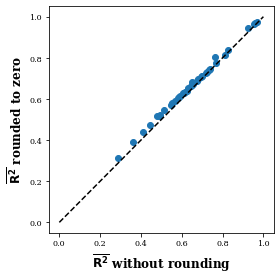

In [13]:
from matplotlib.colors import Normalize
from scipy.interpolate import interpn
import time
from sklearn.neighbors import KernelDensity
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
destfolder = '/Users/ashish/Dropbox/research/ecology/Figures/Fig_LandscapeLinearity_and_InteractionSparsity/'
fold_avg = "/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled_AVG/"
fold_agg = "/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled_AGG/"

fold_landscape1 = "/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled/SM16mean_c16/0/"
fold_landscape2 = "/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled/SM12mean_c2/0/"
# 14 consumed:fold_landscape1="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled/SM16mean_c14/1/"


metric_name = 'R2-avg'
key_name = 'landscape structure: Abundance vector fit Subsetted R2avg'
key_name_in_landscape_dict = 'R2_avg'
label_name = r'$\overline{R^2}$'

Xval, Yval, Zval, Zerr = load_2D_metric_AVGarray(
    fold_avg, key_name, parameter_list)


metric_name = 'R2-avg'
key_name = 'landscape structure: Abundance vector fit Subsetted R2avg_unclipped'
key_name_in_landscape_dict = 'R2_avg_unclipped'
label_name = r'$\overline{R^2}$'

Xval, Yval, Zval_unclipped, Zerr_unclipped = load_2D_metric_AVGarray(
    fold_avg, key_name, parameter_list)




fontSize = 12
labelSize = 10

fig = plt.figure(figsize=(4, 4))
ax1 = fig.add_subplot()

ax1.plot(Zval_unclipped,Zval,'o')
ax1.set_xlabel(r'$\mathbf{\overline{R^2}}$ without rounding', fontweight='bold', fontsize=fontSize)
ax1.set_ylabel(r'$\mathbf{\overline{R^2}}$ rounded to zero', fontweight='bold', fontsize=fontSize)

ax1.plot([0,1], [0,1],'k--')
plt.tight_layout()
plt.savefig(destfolder+"R2avg_compare_clipped_unclipped_R2.png", dpi=400)
plt.savefig(destfolder+"R2avg_compare_clipped_unclipped_R2.pdf")
plt.show()



In [7]:
Zval

array([0.975     , 0.8151679 , 0.83914607, 0.8021487 , 0.97083333,
       0.77286374, 0.7272366 , 0.7127103 , 0.69822828, 0.65436645,
       0.68177844, 0.51594721, 0.94291667, 0.74497266, 0.74275742,
       0.70477442, 0.66641892, 0.66500216, 0.63577366, 0.62972891,
       0.60602633, 0.58077114, 0.54397626, 0.39012229, 0.96488095,
       0.73134635, 0.70928234, 0.68529213, 0.6704372 , 0.63914801,
       0.63106122, 0.60839582, 0.61276994, 0.59154823, 0.57256942,
       0.52080314, 0.51629653, 0.47239683, 0.43900283, 0.31303314])

In [6]:
Yval

array([0.25      , 0.5       , 0.75      , 1.        , 0.125     ,
       0.25      , 0.375     , 0.5       , 0.625     , 0.75      ,
       0.875     , 1.        , 0.08333333, 0.16666667, 0.25      ,
       0.33333333, 0.41666667, 0.5       , 0.58333333, 0.66666667,
       0.75      , 0.83333333, 0.91666667, 1.        , 0.0625    ,
       0.125     , 0.1875    , 0.25      , 0.3125    , 0.375     ,
       0.4375    , 0.5       , 0.5625    , 0.625     , 0.6875    ,
       0.75      , 0.8125    , 0.875     , 0.9375    , 1.        ])

## SI fig robustness to models

UB= 17
UB= 33
UB= 9
dict_keys(['mean_c']) {'mean_c': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}


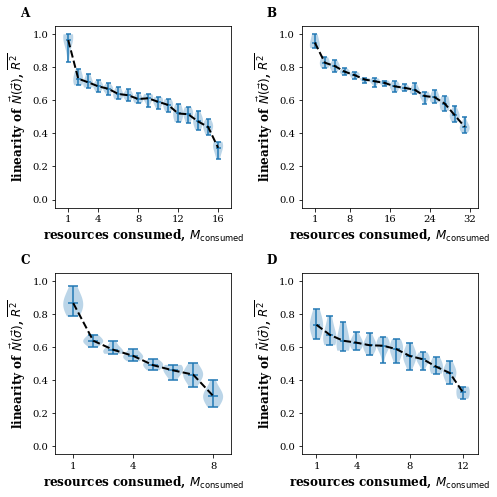

In [9]:
destfolder='/Users/ashish/Dropbox/research/ecology/Figures/Fig_LandscapeLinearity_and_InteractionSparsity/'
if not os.path.exists(destfolder): os.makedirs(destfolder) 

def calc_avg_and_err_over_levels(value_arr, level_arr): ## average over data at a given level and return levels and standard error
    unq_lvls= np.asarray(list(set(level_arr)))
    avgs=[]
    errs=[]
    for lvl in unq_lvls:
        values=value_arr[np.where(level_arr==lvl)]
#         print (lvl,len(values))
        avgs.append(np.mean(values))
        errs.append(np.std(values)/np.sqrt(len(values)) )  
    return unq_lvls, np.asarray(avgs), np.asarray(errs)
        

fig = plt.figure(figsize=(7,7)) 

ax1 = fig.add_subplot(2,2,1)
label=''

########################### for CR model ############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SMp5_CfixednumGamma_meanC_compiled_AGG/"
# parameter_name='mean_c'
# parameter_list=OrderedDict([ ('SMp5',[16] ), ("mean_c", "1 to param1{'LB' : 1,'step_size' : 1, 'UB_X' : 0.5}")])
# X_key=[': exp_case', 'mean_c']
# Xlabel=r'# resources consumed'
# xtick_vals=[1,8,16,24,32]

fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled_AGG/"
#parameter_list=OrderedDict([ ('SM',[8, 12, 16] ), ('mean_c', "1 to param1{'LB' : 3}")])
parameter_list=OrderedDict([ ('SM',[16] ), ('mean_c', "1 to param1{'LB' : 1}")])
_,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
folder_suffix=''
X_key=[': exp_case', 'mean_c']
Xlabel=r'resources consumed, $M_{\mathrm{consumed}}$'
xtick_vals=[1,4,8,12,16]


ctr=0
for agg_filename in glob.glob(fold_agg+'AggAnalysis_*.dat'):
        ctr+=1
assert ctr==1, print ('number of files that matched was',ctr,'instead')
agg_data=pickle.load(open(agg_filename, 'rb'))


Ylabel=r'linearity of $\vec N (\vec \sigma)$, $\overline{R^2}$'
Y_key=': landscape structure: Abundance vector fit Subsetted R2avg'
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
Yvalues=replace_Nones_with(Yvalues,value=0.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
Resources, Avg_rugg, Err_rugg= calc_avg_and_err_over_levels(Yvalues, Xvalues)
# ax1 = plot_avg_and_err(ax1, Resources, Avg_rugg, Err_rugg)
# ax1.scatter(Xvalues, Yvalues)

xlist=list(set(Xvalues))
ylist=[]

for xval in list(set(Xvalues)):
    ylist.append(np.ravel(Yvalues[np.where(Xvalues==xval)]).astype(float) )
ax1.violinplot( ylist, xlist, points=60, widths=1., showmeans=True,showextrema=True,  bw_method=1)
ax1.plot(Resources, Avg_rugg, 'k--',lw=2)
ax1.set_ylim(-0.05,1.05)
ax1.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax1.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax1.set_xticks(xtick_vals)
# ax1.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
# ax1.set_title(community_function)
ax1.tick_params(labelsize= labelSize)
ax1.text(-0.2,1.05,'A',fontweight="bold",transform=ax1.transAxes,fontsize=fontSize)

ax2 = fig.add_subplot(2,2,2) 
# ############################ for CR model with M=2S############################
fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM2_CfixednumGamma_meanC_compiled_AGG/"
parameter_name='mean_c'
parameter_list=OrderedDict([ ('SM2-',[16] ), ('mean_c', "1 to param1{'step_size' : 2,'LB' : 1,'UB_X':2}")])
X_key=[': exp_case', 'mean_c']

xtick_vals=[1,8,16,24,32]

_,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)


ctr=0
for agg_filename in glob.glob(fold_agg+'AggAnalysis_*.dat'):
        ctr+=1
assert ctr==1, print ('number of files that matched was',ctr,'instead')
agg_data=pickle.load(open(agg_filename, 'rb'))




Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
Yvalues=replace_Nones_with(Yvalues,value=0.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
Resources, Avg_rugg, Err_rugg= calc_avg_and_err_over_levels(Yvalues, Xvalues)
# ax2 = plot_avg_and_err(ax2, Resources, Avg_rugg, Err_rugg)
order_idx=np.argsort(Resources)

xlist=list(set(Xvalues))
ylist=[]
for xval in list(set(Xvalues)):
    ylist.append(np.ravel(Yvalues[np.where(Xvalues==xval)]).astype(float) )
ax2.violinplot( ylist, xlist, points=60, widths=2, showmeans=True,showextrema=True,  bw_method=1)
ax2.plot(Resources[order_idx], Avg_rugg[order_idx], 'k--',lw=2)
ax2.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax2.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax2.set_xticks(xtick_vals)
ax2.set_ylim(-0.05,1.05)
ax2.tick_params(labelsize= labelSize)
# ax2.set_title(community_function)
ax2.text(-0.2,1.05,'B',fontweight="bold",transform=ax2.transAxes,fontsize=fontSize)



ax3 = fig.add_subplot(2,2,3)
########################### for CR model with S=2M ############################
fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SMp5_CfixednumGamma_meanC_compiled_AGG/"
parameter_name='mean_c'
parameter_list=OrderedDict([ ('SMp5',[16] ), ("mean_c", "1 to param1{'LB' : 1,'step_size' : 1, 'UB_X' : 0.5}")])
xtick_vals=[1,4,8]
X_key=[': exp_case', 'mean_c']


_,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)

ctr=0
for agg_filename in glob.glob(fold_agg+'AggAnalysis_*.dat'):
        ctr+=1
assert ctr==1, print ('number of files that matched was',ctr,'instead')
agg_data=pickle.load(open(agg_filename, 'rb'))

Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
Yvalues=replace_Nones_with(Yvalues,value=0.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
Resources, Avg_rugg, Err_rugg= calc_avg_and_err_over_levels(Yvalues, Xvalues)
# ax3 = plot_avg_and_err(ax3, Resources, Avg_rugg, Err_rugg)
# ax3.scatter(Xvalues, Yvalues)
xlist=list(set(Xvalues))
ylist=[]
for xval in list(set(Xvalues)):
    ylist.append(np.ravel(Yvalues[np.where(Xvalues==xval)]).astype(float) )
ax3.violinplot( ylist, xlist, points=60, widths=1, showmeans=True,showextrema=True,  bw_method=1)
ax3.plot(Resources, Avg_rugg, 'k--',lw=2 )
ax3.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax3.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax3.set_xticks(xtick_vals)
ax3.set_ylim(-0.05,1.05)
# ax3.set_title(community_function)
ax3.tick_params(labelsize= labelSize)
ax3.text(-.2,1.05,'C',fontweight="bold",transform=ax3.transAxes,fontsize=fontSize)

ax4 = fig.add_subplot(2,2,4)
########################### for CF meancC ############################
fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CF_CfixedxGamma0Special_meanC_compiled_AGG/"
parameter_name='mean_c'
parameter_list={parameter_name:[1,2,3,4,5,6,7,8,9,10,11,12]}
folder_suffix='CF_meanC'
X_key=[': exp_case', 'mean_c']

xtick_vals=[1,4,8,12]
_,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)

ctr=0
for agg_filename in glob.glob(fold_agg+'AggAnalysis_*.dat'):
        ctr+=1
assert ctr==1, print ('number of files that matched was',ctr,'instead')
agg_data=pickle.load(open(agg_filename, 'rb'))

Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
Yvalues=replace_Nones_with(Yvalues,value=0.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
Resources, Avg_rugg, Err_rugg= calc_avg_and_err_over_levels(Yvalues, Xvalues)

xlist=list(set(Xvalues))
ylist=[]
for xval in list(set(Xvalues)):
    ylist.append(np.ravel(Yvalues[np.where(Xvalues==xval)]).astype(float) )
ax4.violinplot( ylist, xlist, points=60, widths=1, showmeans=True,showextrema=True,  bw_method=1)
ax4.plot(Resources, Avg_rugg, 'k--',lw=2 )
ax4.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax4.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax4.set_xticks(xtick_vals)
ax4.set_ylim(-0.05,1.05)

ax4.tick_params(labelsize= labelSize)
ax4.text(-.2,1.05,'D',fontweight="bold",transform=ax4.transAxes,fontsize=fontSize)


plt.tight_layout()
plt.savefig(destfolder+"Rbar2_vs_sparsity_across_models.pdf")


# Search efficacy vs sparsity

## 4 panel with butyrate

UB= 17


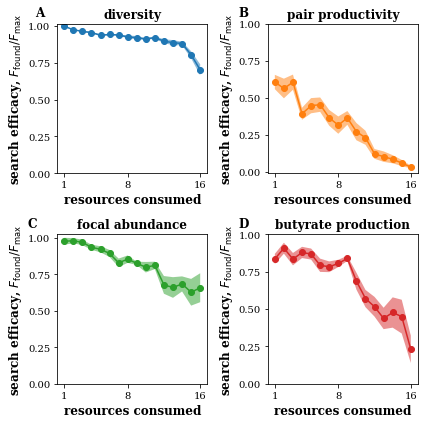

In [4]:
destfolder='/Users/ashish/Dropbox/research/ecology/Figures/Fig_ruggedness_vs_consumption_sparsity/'
if not os.path.exists(destfolder): os.makedirs(destfolder) 

# ############################ for CR model ############################
fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled_AGG/"
#parameter_list=OrderedDict([ ('SM',[8, 12, 16] ), ('mean_c', "1 to param1{'LB' : 3}")])
parameter_list=OrderedDict([ ('SM',[16] ), ('mean_c', "1 to param1{'LB' : 1}")])
_,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
folder_suffix=''
X_key=[': exp_case', 'mean_c']
Xlabel=r'resources consumed'#, $M_{\mathrm{consumed}}$'
xtick_vals=[1,8,16]

############################ for CR model with M=2S############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM2_CfixednumGamma_meanC_compiled_AGG/"
# parameter_list=OrderedDict([ ('SM2-',[16] ), ('mean_c', "1 to param1{'step_size' : 2,'LB' : 3,'UB_X':2}")])
# _,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
# folder_suffix='SM2'
# X_key=[': exp_case', 'mean_c']
# Xlabel=r'resources consumed'
# xtick_vals=[1,8,16,32]


############################ for CR model with S=2M ############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SMp5_CfixednumGamma_meanC_compiled_AGG/"
# parameter_list=OrderedDict([ ('SMp5',[16] ), ("mean_c", "1 to param1{'LB' : 1,'step_size' : 1, 'UB_X' : 0.5}")])
# _,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
# folder_suffix='S-2M'
# X_key=[': exp_case', 'mean_c']
# Xlabel=r'resources consumed'
# xtick_vals=[1,4,8]

# ############################ CF meanC ############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CF_CfixedxGamma0Special_meanC_compiled_AGG/"
# parameter_name='mean_c'
# parameter_list={parameter_name:[1,2,3,4,5,6,7,8,9,10,11,12]}
# _,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
# folder_suffix='CF_meanC'
# X_key=[': exp_case', 'mean_c']
# Xlabel=r'resources consumed'
# xtick_vals=[1,4,8,12]


############################ CF l ############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CF_CfixedxGamma01Special_l_compiled_AGG/"
# parameter_name='l'
# ''' l=0 is not included because focal species abundance doesn't make sense for it'''
# parameter_list={parameter_name:[  0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]}
# _,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
# folder_suffix='CF_l'
# X_key=[': exp_case', 'l']
# Xlabel=r'leakage fraction'
# xtick_vals=[0.1,0.3, 0.5, 0.7, 0.9]
    
    
ctr=0
for agg_filename in glob.glob(fold_agg+'AggAnalysis_*.dat'):
        ctr+=1
assert ctr==1, print ('number of files that matched was',ctr,'instead')
agg_data=pickle.load(open(agg_filename, 'rb'))



color_list=create_color_list(scheme_name='sns_tab10')

label=''
fig = plt.figure(figsize=(6,6)) 
Ylabel=r'search efficacy, $F_{\mathrm{found}}/F_{\mathrm{max}}$'

ax1 = fig.add_subplot(2,2,1) 
community_function='Shannon Diversity'
Y_key=': '+community_function+': mean_relative_optimum_Greediest'
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
# Yvalues=replace_Nones_with(Yvalues,value=1.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
Resources, Avg_rugg, Err_rugg= calc_avg_and_err_over_levels(Yvalues, Xvalues)
ax1 = plot_avg_and_err(ax1, Resources, Avg_rugg, Err_rugg, fc=color_list[0])
ax1.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax1.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax1.set_xticks(xtick_vals)
ax1.set_title('diversity', fontsize=fontSize,fontweight="bold")
# ax1.plot(ax1.get_xlim(),[0.,0.],'--', color=color_list[2])
ax1.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax1.tick_params(labelsize= labelSize)
ax1.text(-0.15,1.05,'A',fontweight="bold",transform=ax1.transAxes,fontsize=fontSize)




ax2 = fig.add_subplot(2,2,2)            
community_function='Species 2,3 coex_product FullLandscape'

Y_key=': '+community_function+': mean_relative_optimum_Greediest'
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
# Yvalues=replace_Nones_with(Yvalues,value=1.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
Resources, Avg_rugg, Err_rugg= calc_avg_and_err_over_levels(Yvalues, Xvalues)
ax2 = plot_avg_and_err(ax2, Resources, Avg_rugg, Err_rugg, fc=color_list[1])
ax2.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax2.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax2.set_xticks(xtick_vals)
ax2.tick_params(labelsize= labelSize)
ax2.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax2.set_title('pair productivity', fontsize=fontSize,fontweight="bold")
# ax2.plot(ax2.get_xlim(),[0.,0.],'--', color=color_list[2])
# ax2.plot(ax2.get_xlim(),[1.,1.],'--', color=color_list[3])
ax2.text(-0.2,1.05,'B',fontweight="bold",transform=ax2.transAxes,fontsize=fontSize)




ax3 = fig.add_subplot(2,2,3)            
community_function='Species 2'

Y_key=': '+community_function+': mean_relative_optimum_Greediest'
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
# Yvalues=replace_Nones_with(Yvalues,value=1.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
Resources, Avg_rugg, Err_rugg= calc_avg_and_err_over_levels(Yvalues, Xvalues)
ax3 = plot_avg_and_err(ax3, Resources, Avg_rugg, Err_rugg, fc=color_list[2])
ax3.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax3.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax3.set_xticks(xtick_vals)
ax3.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax3.set_title('focal abundance', fontsize=fontSize,fontweight="bold")

# ax3.plot(ax3.get_xlim(),[0.,0.],'--', color=color_list[2])
# ax3.plot(ax3.get_xlim(),[1.,1.],'--', color=color_list[3])
ax3.tick_params(labelsize= labelSize)
ax3.text(-0.2,1.05,'C',fontweight="bold",transform=ax3.transAxes,fontsize=fontSize)


ax4 = fig.add_subplot(2,2,4)            
community_function='Clark_M3'
Y_key=': '+community_function+': mean_relative_optimum_Greediest'
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
# Yvalues=replace_Nones_with(Yvalues,value=1.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
Resources, Avg_rugg, Err_rugg= calc_avg_and_err_over_levels(Yvalues, Xvalues)
ax4 = plot_avg_and_err(ax4, Resources, Avg_rugg, Err_rugg, fc=color_list[3])
ax4.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax4.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax4.set_xticks(xtick_vals)
ax4.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax4.set_title('butyrate production', fontsize=fontSize,fontweight="bold")

# ax4.plot(ax4.get_xlim(),[0.,0.],'--', color=color_list[2])
# ax4.plot(ax4.get_xlim(),[1.,1.],'--', color=color_list[3])
ax4.tick_params(labelsize= labelSize)
ax4.text(-0.2,1.05,'D',fontweight="bold",transform=ax4.transAxes,fontsize=fontSize)



fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(destfolder+"Search_vs_Sparsity_"+folder_suffix+"-4panel.pdf")




## 3-panel

UB= 17


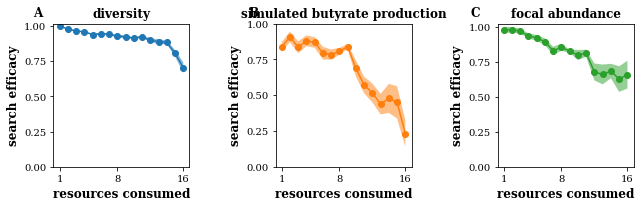

In [3]:
destfolder='/Users/ashish/Dropbox/research/ecology/Figures/Fig_ruggedness_vs_consumption_sparsity/'
if not os.path.exists(destfolder): os.makedirs(destfolder) 

# ############################ for CR model ############################
fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled_AGG/"
#parameter_list=OrderedDict([ ('SM',[8, 12, 16] ), ('mean_c', "1 to param1{'LB' : 3}")])
parameter_list=OrderedDict([ ('SM',[16] ), ('mean_c', "1 to param1{'LB' : 1}")])
_,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
folder_suffix=''
X_key=[': exp_case', 'mean_c']
Xlabel=r'resources consumed'#, $M_{\mathrm{consumed}}$'
xtick_vals=[1,8,16]

############################ for CR model with M=2S############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM2_CfixednumGamma_meanC_compiled_AGG/"
# parameter_list=OrderedDict([ ('SM2-',[16] ), ('mean_c', "1 to param1{'step_size' : 2,'LB' : 3,'UB_X':2}")])
# _,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
# folder_suffix='SM2'
# X_key=[': exp_case', 'mean_c']
# Xlabel=r'resources consumed'
# xtick_vals=[1,8,16,32]


############################ for CR model with S=2M ############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SMp5_CfixednumGamma_meanC_compiled_AGG/"
# parameter_list=OrderedDict([ ('SMp5',[16] ), ("mean_c", "1 to param1{'LB' : 1,'step_size' : 1, 'UB_X' : 0.5}")])
# _,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
# folder_suffix='S-2M'
# X_key=[': exp_case', 'mean_c']
# Xlabel=r'resources consumed'
# xtick_vals=[1,4,8]

# ############################ CF meanC ############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CF_CfixedxGamma0Special_meanC_compiled_AGG/"
# parameter_name='mean_c'
# parameter_list={parameter_name:[1,2,3,4,5,6,7,8,9,10,11,12]}
# _,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
# folder_suffix='CF_meanC'
# X_key=[': exp_case', 'mean_c']
# Xlabel=r'resources consumed'
# xtick_vals=[1,4,8,12]


############################ CF l ############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CF_CfixedxGamma01Special_l_compiled_AGG/"
# parameter_name='l'
# ''' l=0 is not included because focal species abundance doesn't make sense for it'''
# parameter_list={parameter_name:[  0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]}
# _,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
# folder_suffix='CF_l'
# X_key=[': exp_case', 'l']
# Xlabel=r'leakage fraction'
# xtick_vals=[0.1,0.3, 0.5, 0.7, 0.9]
    
    
ctr=0
for agg_filename in glob.glob(fold_agg+'AggAnalysis_*.dat'):
        ctr+=1
assert ctr==1, print ('number of files that matched was',ctr,'instead')
agg_data=pickle.load(open(agg_filename, 'rb'))



color_list=create_color_list(scheme_name='sns_tab10')

label=''
fig = plt.figure(figsize=(9,3)) 
Ylabel='search efficacy'

ax1 = fig.add_subplot(1,3,1) 
community_function='Shannon Diversity'
Y_key=': '+community_function+': mean_relative_optimum_Greediest'
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
# Yvalues=replace_Nones_with(Yvalues,value=1.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
Resources, Avg_rugg, Err_rugg= calc_avg_and_err_over_levels(Yvalues, Xvalues)
ax1 = plot_avg_and_err(ax1, Resources, Avg_rugg, Err_rugg, fc=color_list[0])
ax1.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax1.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax1.set_xticks(xtick_vals)
ax1.set_title('diversity', fontsize=fontSize,fontweight="bold")
# ax1.plot(ax1.get_xlim(),[0.,0.],'--', color=color_list[2])
ax1.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax1.tick_params(labelsize= labelSize)
ax1.text(-0.15,1.05,'A',fontweight="bold",transform=ax1.transAxes,fontsize=fontSize)




ax2 = fig.add_subplot(1,3,2)            
# community_function='Species 2,3 coex_product FullLandscape'
community_function='Clark_M3'
Y_key=': '+community_function+': mean_relative_optimum_Greediest'




Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
# Yvalues=replace_Nones_with(Yvalues,value=1.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
Resources, Avg_rugg, Err_rugg= calc_avg_and_err_over_levels(Yvalues, Xvalues)
ax2 = plot_avg_and_err(ax2, Resources, Avg_rugg, Err_rugg, fc=color_list[1])
ax2.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax2.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax2.set_xticks(xtick_vals)
ax2.tick_params(labelsize= labelSize)
ax2.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax2.set_title('pair productivity', fontsize=fontSize,fontweight="bold")
ax2.set_title('simulated butyrate production', fontsize=fontSize,fontweight="bold")
# ax2.plot(ax2.get_xlim(),[0.,0.],'--', color=color_list[2])
# ax2.plot(ax2.get_xlim(),[1.,1.],'--', color=color_list[3])
ax2.text(-0.2,1.05,'B',fontweight="bold",transform=ax2.transAxes,fontsize=fontSize)




ax3 = fig.add_subplot(1,3,3)            
community_function='Species 2'

Y_key=': '+community_function+': mean_relative_optimum_Greediest'
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
# Yvalues=replace_Nones_with(Yvalues,value=1.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
Resources, Avg_rugg, Err_rugg= calc_avg_and_err_over_levels(Yvalues, Xvalues)
ax3 = plot_avg_and_err(ax3, Resources, Avg_rugg, Err_rugg, fc=color_list[2])
ax3.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax3.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax3.set_xticks(xtick_vals)
ax3.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax3.set_title('focal abundance', fontsize=fontSize,fontweight="bold")

# ax3.plot(ax3.get_xlim(),[0.,0.],'--', color=color_list[2])
# ax3.plot(ax3.get_xlim(),[1.,1.],'--', color=color_list[3])
ax3.tick_params(labelsize= labelSize)
ax3.text(-0.2,1.05,'C',fontweight="bold",transform=ax3.transAxes,fontsize=fontSize)


fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(destfolder+"Search_vs_Sparsity_"+folder_suffix+"-test-3panel.pdf")




## search and ruggedness vs sparsity

UB= 17


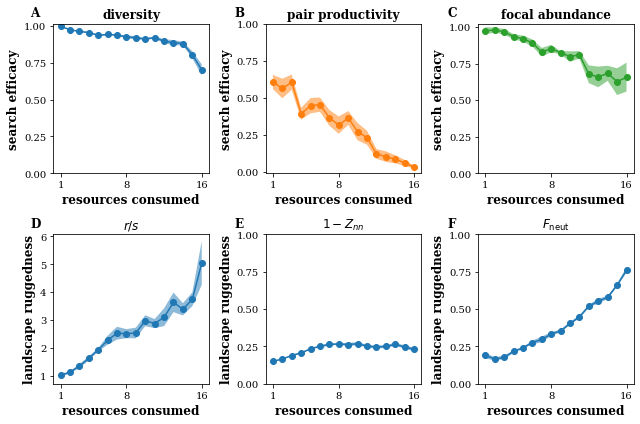

In [12]:
destfolder='/Users/ashish/Dropbox/research/ecology/Figures/Fig_ruggedness_vs_consumption_sparsity/'
if not os.path.exists(destfolder): os.makedirs(destfolder) 

############################ for CR model ############################
fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled_AGG/"
#parameter_list=OrderedDict([ ('SM',[8, 12, 16] ), ('mean_c', "1 to param1{'LB' : 3}")])
parameter_list=OrderedDict([ ('SM',[16] ), ('mean_c', "1 to param1{'LB' : 1}")])
_,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
folder_suffix=''
X_key=[': exp_case', 'mean_c']
Xlabel=r'resources consumed'#, $M_{\mathrm{consumed}}$'
xtick_vals=[1,8,16]


    
ctr=0
for agg_filename in glob.glob(fold_agg+'AggAnalysis_*.dat'):
        ctr+=1
assert ctr==1, print ('number of files that matched was',ctr,'instead')
agg_data=pickle.load(open(agg_filename, 'rb'))



color_list=create_color_list(scheme_name='sns_tab10')

label=''

fig = plt.figure(figsize=(9,6)) 


##############search panels
Ylabel='search efficacy'
ax1 = fig.add_subplot(2,3,1) 
community_function='Shannon Diversity'
Y_key=': '+community_function+': mean_relative_optimum_Greediest'
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
# Yvalues=replace_Nones_with(Yvalues,value=1.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
Resources, Avg_rugg, Err_rugg= calc_avg_and_err_over_levels(Yvalues, Xvalues)
ax1 = plot_avg_and_err(ax1, Resources, Avg_rugg, Err_rugg, fc=color_list[0])
ax1.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax1.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax1.set_xticks(xtick_vals)
ax1.set_title('diversity', fontsize=fontSize,fontweight="bold")
# ax1.plot(ax1.get_xlim(),[0.,0.],'--', color=color_list[2])
ax1.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax1.tick_params(labelsize= labelSize)
ax1.text(-0.15,1.05,'A',fontweight="bold",transform=ax1.transAxes,fontsize=fontSize)

ax2 = fig.add_subplot(2,3,2)            
community_function='Species 2,3 coex_product FullLandscape'
Y_key=': '+community_function+': mean_relative_optimum_Greediest'
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
# Yvalues=replace_Nones_with(Yvalues,value=1.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
Resources, Avg_rugg, Err_rugg= calc_avg_and_err_over_levels(Yvalues, Xvalues)
ax2 = plot_avg_and_err(ax2, Resources, Avg_rugg, Err_rugg, fc=color_list[1])
ax2.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax2.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax2.set_xticks(xtick_vals)
ax2.tick_params(labelsize= labelSize)
ax2.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax2.set_title('pair productivity', fontsize=fontSize,fontweight="bold")
# ax2.plot(ax2.get_xlim(),[0.,0.],'--', color=color_list[2])
# ax2.plot(ax2.get_xlim(),[1.,1.],'--', color=color_list[3])
ax2.text(-0.2,1.05,'B',fontweight="bold",transform=ax2.transAxes,fontsize=fontSize)

ax3 = fig.add_subplot(2,3,3)            
community_function='Species 2'
Y_key=': '+community_function+': mean_relative_optimum_Greediest'
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
# Yvalues=replace_Nones_with(Yvalues,value=1.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
Resources, Avg_rugg, Err_rugg= calc_avg_and_err_over_levels(Yvalues, Xvalues)
ax3 = plot_avg_and_err(ax3, Resources, Avg_rugg, Err_rugg, fc=color_list[2])
ax3.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax3.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax3.set_xticks(xtick_vals)
ax3.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax3.set_title('focal abundance', fontsize=fontSize,fontweight="bold")
# ax3.plot(ax3.get_xlim(),[0.,0.],'--', color=color_list[2])
# ax3.plot(ax3.get_xlim(),[1.,1.],'--', color=color_list[3])
ax3.tick_params(labelsize= labelSize)
ax3.text(-0.2,1.05,'C',fontweight="bold",transform=ax3.transAxes,fontsize=fontSize)




#####################ruggedness panels

fitness_measure='Shannon Diversity'
# fitness_measure='Species 2,3 coex_product'
# fitness_measure='Species 2 coex_product'
# fitness_measure='Species 2'
Ylabel='landscape ruggedness'
ax4 = fig.add_subplot(2,3,4) 
title=r'$r/s$'
Y_key=': '+fitness_measure+': r/s'
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
# Yvalues=replace_Nones_with(Yvalues,value=1.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
Resources, Avg_rugg, Err_rugg= calc_avg_and_err_over_levels(Yvalues, Xvalues)
ax4 = plot_avg_and_err(ax4, Resources, Avg_rugg, Err_rugg, fc=color_list[0])
ax4.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax4.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax4.set_title(title, fontsize=fontSize)
ax4.set_xticks(xtick_vals)
# ax4.plot(ax4.get_xlim(),[0.,0.],'--', color=color_list[2])
# ax4.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax4.tick_params(labelsize= labelSize)
ax4.text(-0.15,1.05,'D',fontweight="bold",transform=ax4.transAxes,fontsize=fontSize)




ax5 = fig.add_subplot(2,3,5)            
title=r'$1-Z_{nn}$' 
Y_key=': '+fitness_measure+': nn_correlation'
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
# Yvalues=replace_Nones_with(Yvalues,value=1.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
Resources, Avg_rugg, Err_rugg= calc_avg_and_err_over_levels(1.-Yvalues, Xvalues)
ax5 = plot_avg_and_err(ax5, Resources, Avg_rugg, Err_rugg, fc=color_list[0])
ax5.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax5.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax5.set_title(title, fontsize=fontSize)
ax5.set_xticks(xtick_vals)
ax5.tick_params(labelsize= labelSize)
ax5.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
# ax5.plot(ax5.get_xlim(),[0.,0.],'--', color=color_list[2])
# ax5.plot(ax5.get_xlim(),[1.,1.],'--', color=color_list[3])
ax5.text(-0.2,1.05,'E',fontweight="bold",transform=ax5.transAxes,fontsize=fontSize)




ax6 = fig.add_subplot(2,3,6)            
title=r'$F_{\mathsf{neut}}$'
Y_key=': '+fitness_measure+': f_neutral_links' 
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
# Yvalues=replace_Nones_with(Yvalues,value=1.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
Resources, Avg_rugg, Err_rugg= calc_avg_and_err_over_levels(Yvalues, Xvalues)
ax6 = plot_avg_and_err(ax6, Resources, Avg_rugg, Err_rugg, fc=color_list[0])
ax6.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax6.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax6.set_title(title, fontsize=fontSize)
ax6.set_xticks(xtick_vals)
ax6.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
# ax6.plot(ax6.get_xlim(),[0.,0.],'--', color=color_list[2])
# ax6.plot(ax6.get_xlim(),[1.,1.],'--', color=color_list[3])
ax6.tick_params(labelsize= labelSize)
ax6.text(-0.2,1.05,'F',fontweight="bold",transform=ax6.transAxes,fontsize=fontSize)


fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(destfolder+"Ruggedness+Search_vs_Sparsity_"+folder_suffix+"-3panel.pdf")




# Fig Measuring Landscape ruggedness

## Fig ruggedness vs consumption sparsity

UB= 17


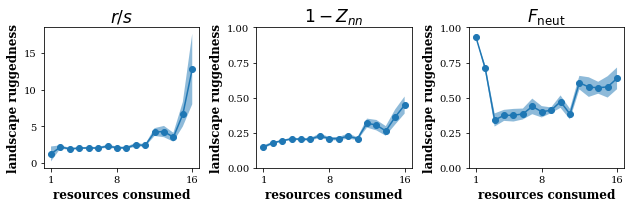

In [18]:
destfolder='/Users/ashish/Dropbox/research/ecology/Figures/Fig_ruggedness_vs_consumption_sparsity/'
if not os.path.exists(destfolder): os.makedirs(destfolder) 

############################ for CR model ############################
fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled_AGG/"
#parameter_list=OrderedDict([ ('SM',[8, 12, 16] ), ('mean_c', "1 to param1{'LB' : 3}")])
parameter_list=OrderedDict([ ('SM',[16] ), ('mean_c', "1 to param1{'LB' : 1}")])
_,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
folder_suffix=''
X_key=[': exp_case', 'mean_c']
Xlabel=r'resources consumed'#, $M_{\mathrm{consumed}}$'
xtick_vals=[1,8,16]

############################ for CR model with M=2S############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM2_CfixednumGamma_meanC_compiled_AGG/"
# parameter_list=OrderedDict([ ('SM2-',[16] ), ('mean_c', "1 to param1{'step_size' : 2,'LB' : 3,'UB_X':2}")])
# _,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
# folder_suffix='SM2'
# X_key=[': exp_case', 'mean_c']
# Xlabel=r'resources consumed'
# xtick_vals=[1,8,16,32]


############################ for CR model with S=2M ############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SMp5_CfixednumGamma_meanC_compiled_AGG/"
# parameter_list=OrderedDict([ ('SMp5',[16] ), ("mean_c", "1 to param1{'LB' : 1,'step_size' : 1, 'UB_X' : 0.5}")])
# _,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
# folder_suffix='S-2M'
# X_key=[': exp_case', 'mean_c']
# Xlabel=r'resources consumed'
# xtick_vals=[1,4,8]

############################ CF meanC ############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CF_CfixedxGamma0Special_meanC_compiled_AGG/"
# parameter_name='mean_c'
# parameter_list={parameter_name:[1,2,3,4,5,6,7,8,9,10,11,12]}
# _,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
# folder_suffix='CF_meanC'
# X_key=[': exp_case', 'mean_c']
# Xlabel=r'resources consumed'
# xtick_vals=[1,4,8,12]


############################ CF l ############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CF_CfixedxGamma01Special_l_compiled_AGG/"
# parameter_name='l'
# ''' l=0 is not included because focal species abundance doesn't make sense for it'''
# parameter_list={parameter_name:[  0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]}
# _,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
# folder_suffix='CF_l'
# X_key=[': exp_case', 'l']
# Xlabel=r'leakage fraction'
# xtick_vals=[0.1,0.3, 0.5, 0.7, 0.9]
    
    
ctr=0
for agg_filename in glob.glob(fold_agg+'AggAnalysis_*.dat'):
        ctr+=1
assert ctr==1, print ('number of files that matched was',ctr,'instead')
agg_data=pickle.load(open(agg_filename, 'rb'))



color_list=create_color_list(scheme_name='sns_tab10')

label=''
# fitness_measure='Shannon Diversity'
# fitness_measure='Species 2,3 coex_product'
# fitness_measure='Species 2 coex_product'
# fitness_measure='Species 2,3 coex_product FullLandscape'
fitness_measure='Species 2'
# fitness_measure='Clark_M3'


fig = plt.figure(figsize=(9,3)) 
Ylabel='landscape ruggedness'

ax1 = fig.add_subplot(1,3,1) 


title=r'$r/s$'
Y_key=': '+fitness_measure+': r/s'

Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
# Yvalues=replace_Nones_with(Yvalues,value=1.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
Resources, Avg_rugg, Err_rugg= calc_avg_and_err_over_levels(Yvalues, Xvalues)
ax1 = plot_avg_and_err(ax1, Resources, Avg_rugg, Err_rugg, fc=color_list[0])
ax1.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax1.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax1.set_title(title, fontsize=fontSize+5)
ax1.set_xticks(xtick_vals)
# ax1.plot(ax1.get_xlim(),[0.,0.],'--', color=color_list[2])
# ax1.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax1.tick_params(labelsize= labelSize)
# ax1.text(-0.15,1.05,'A',fontweight="bold",transform=ax1.transAxes,fontsize=fontSize)




ax2 = fig.add_subplot(1,3,2)            
title=r'$1-Z_{nn}$' 
Y_key=': '+fitness_measure+': nn_correlation'
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
# Yvalues=replace_Nones_with(Yvalues,value=1.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
Resources, Avg_rugg, Err_rugg= calc_avg_and_err_over_levels(1.-Yvalues, Xvalues)
ax2 = plot_avg_and_err(ax2, Resources, Avg_rugg, Err_rugg, fc=color_list[0])
ax2.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax2.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax2.set_title(title, fontsize=fontSize+5)
ax2.set_xticks(xtick_vals)
ax2.tick_params(labelsize= labelSize)
ax2.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
# ax2.plot(ax2.get_xlim(),[0.,0.],'--', color=color_list[2])
# ax2.plot(ax2.get_xlim(),[1.,1.],'--', color=color_list[3])
# ax2.text(-0.2,1.05,'B',fontweight="bold",transform=ax2.transAxes,fontsize=fontSize)




ax3 = fig.add_subplot(1,3,3)            
title=r'$F_{\mathsf{neut}}$'
Y_key=': '+fitness_measure+': f_neutral_links' 
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
# Yvalues=replace_Nones_with(Yvalues,value=1.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
Resources, Avg_rugg, Err_rugg= calc_avg_and_err_over_levels(Yvalues, Xvalues)
ax3 = plot_avg_and_err(ax3, Resources, Avg_rugg, Err_rugg, fc=color_list[0])
ax3.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax3.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax3.set_title(title, fontsize=fontSize+5)
ax3.set_xticks(xtick_vals)
ax3.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
# ax3.plot(ax3.get_xlim(),[0.,0.],'--', color=color_list[2])
# ax3.plot(ax3.get_xlim(),[1.,1.],'--', color=color_list[3])
ax3.tick_params(labelsize= labelSize)
# ax3.text(-0.2,1.05,'C',fontweight="bold",transform=ax3.transAxes,fontsize=fontSize)


fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(destfolder+"Ruggedness_vs_Sparsity_"+fitness_measure+folder_suffix+"-3panel.pdf")




# SI fig niche overlap vs sparsity

UB= 17


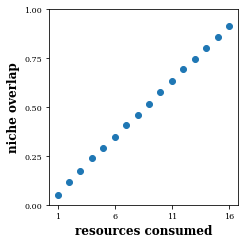

In [16]:
destfolder='/Users/ashish/Dropbox/research/ecology/Figures/Fig_niche_overlap_vs_consumption_sparsity/'
if not os.path.exists(destfolder): os.makedirs(destfolder) 

############################ for CR model ############################
fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled_AGG/"
#parameter_list=OrderedDict([ ('SM',[8, 12, 16] ), ('mean_c', "1 to param1{'LB' : 3}")])
parameter_list=OrderedDict([ ('SM',[16] ), ('mean_c', "1 to param1{'LB' : 1}")])
_,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
folder_suffix=''
X_key=[': exp_case', 'mean_c']
Xlabel=r'resources consumed'#, $M_{\mathrm{consumed}}$'
xtick_vals=[1,8,16]

ctr=0
for agg_filename in glob.glob(fold_agg+'AggAnalysis_*.dat'):
        ctr+=1
assert ctr==1, print ('number of files that matched was',ctr,'instead')
agg_data=pickle.load(open(agg_filename, 'rb'))


### for each parameter value,
### get consumption matrix from each replicate  and calculate overlap for that matrix
parameter_array=np.array(parameter_list )
meanc_vals=np.array(parameter_list )[:,1]

# df_keyname_prefix_list
niche_overlaps_list=[]
for i, meanc in enumerate(meanc_vals):
    niche_overlaps_list.append([])
    n_replicates=len(agg_data[df_keyname_prefix_list[i]+': passed_params'])
    
    for j in range(n_replicates):
        c_matrix=agg_data[df_keyname_prefix_list[i]+': passed_params'][j]['c']
        niche_overlap=np.mean(1-scipy.spatial.distance.pdist(c_matrix,'cosine'))
        niche_overlaps_list[i].append(niche_overlap)

avg_niche_overlap_arr=np.array([np.mean(k) for k in niche_overlaps_list])
stderr_niche_overlap_arr=np.array([np.std(k) for k in niche_overlaps_list]
                                 )/np.sqrt(n_replicates)
fig = plt.figure(figsize=(3.5,3.5)) 
ax1 = fig.add_subplot()  
ax1.errorbar(meanc_vals,avg_niche_overlap_arr, yerr=stderr_niche_overlap_arr, fmt='o')
ax1.set_xticks([1,6,11, 16])
ax1.set_xlabel('resources consumed',fontweight="bold",fontsize=fontSize)
ax1.set_ylabel('niche overlap',fontweight="bold",fontsize=fontSize)
ax1.set_yticks([0,0.25,0.5,0.75,1.])
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(destfolder+"niche_overlap_vs_sparsity"+folder_suffix+".pdf")



## for uniform sampled c

formula for max overlap value turns out to be var(c)/(var(c)+mean(c)**2)

ax1: mean=  1.0 var=  0.08333333333333333
just a heuristic estimate, doesnt apply exactly
ax2: mean=  10.3 var=  34.68
0.7536406904880302
just a heuristic!


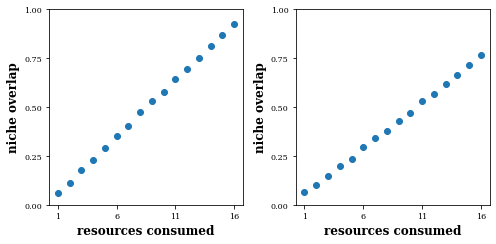

In [17]:
destfolder='/Users/ashish/Dropbox/research/ecology/Figures/Fig_niche_overlap_vs_consumption_sparsity/'
meanc_vals=np.arange(16)+1
n_replicates=10
n_res=16

def make_c_matrix_uniform(n_res,meanc,lb=0.2, ub=1.2):
    c=np.zeros((n_res,n_res))
    for i in range(n_res):
        idx_nonzero=np.random.choice(n_res,meanc, replace=False)  
        c[i,idx_nonzero]=np.random.uniform(low=lb, high=ub,size=meanc)
    return c


fig = plt.figure(figsize=(7,3.5)) 
ax1 = fig.add_subplot(1,2,1)  
lb=.5
ub=1.5
actual_mean=(lb+ub)/2.
actual_var=np.square(ub-lb)/12.
print ('ax1: mean= ',actual_mean, 'var= ', actual_var)
limit_val=actual_mean**2/(actual_var+actual_mean**2)
print('just a heuristic estimate, doesnt apply exactly')

niche_overlaps_list=[]
for i, meanc in enumerate(meanc_vals):
    niche_overlaps_list.append([])
    for j in range(n_replicates):        
        c_matrix=make_c_matrix_uniform(n_res,meanc,lb=lb, ub=ub)
        niche_overlap=np.mean(1-scipy.spatial.distance.pdist(c_matrix,'cosine'))
        niche_overlaps_list[i].append(niche_overlap)

avg_niche_overlap_arr=np.array([np.mean(k) for k in niche_overlaps_list])
stderr_niche_overlap_arr=np.array([np.std(k) for k in niche_overlaps_list]
                                 )/np.sqrt(n_replicates)



ax1.errorbar(meanc_vals,avg_niche_overlap_arr, yerr=stderr_niche_overlap_arr, fmt='o')
# ax1.plot([meanc_vals[0],meanc_vals[-1]],  [limit_val,limit_val],'k--')

ax1.set_xticks([1,6,11, 16])
ax1.set_xlabel('resources consumed',fontweight="bold",fontsize=fontSize)
ax1.set_ylabel('niche overlap',fontweight="bold",fontsize=fontSize)
ax1.set_yticks([0,0.25,0.5,0.75,1.])
# ax1.text(-0.15,1.05,'A',fontweight="bold",transform=ax1.transAxes,fontsize=fontSize)


ax2 = fig.add_subplot(1,2,2)  
lb=.1
ub=20.5
actual_mean=(lb+ub)/2.
actual_var=np.square(ub-lb)/12.
print ('ax2: mean= ',actual_mean, 'var= ', actual_var)
limit_val=actual_mean**2/(actual_var+actual_mean**2)
print(limit_val)
print ('just a heuristic!')
niche_overlaps_list=[]
for i, meanc in enumerate(meanc_vals):
    niche_overlaps_list.append([])
    for j in range(n_replicates):        
        c_matrix=make_c_matrix_uniform(n_res,meanc,lb=lb, ub=ub)
        niche_overlap=np.mean(1-scipy.spatial.distance.pdist(c_matrix,'cosine'))
        niche_overlaps_list[i].append(niche_overlap)

avg_niche_overlap_arr=np.array([np.mean(k) for k in niche_overlaps_list])
stderr_niche_overlap_arr=np.array([np.std(k) for k in niche_overlaps_list]
                                 )/np.sqrt(n_replicates)


ax2.errorbar(meanc_vals,avg_niche_overlap_arr, yerr=stderr_niche_overlap_arr, fmt='o')
# ax2.plot([meanc_vals[0],meanc_vals[-1]],[limit_val,limit_val],'k--')
ax2.set_xticks([1,6,11, 16])
ax2.set_xlabel('resources consumed',fontweight="bold",fontsize=fontSize)
ax2.set_ylabel('niche overlap',fontweight="bold",fontsize=fontSize)
ax2.set_yticks([0,0.25,0.5,0.75,1.])
# ax2.text(-0.15,1.05,'B',fontweight="bold",transform=ax2.transAxes,fontsize=fontSize)


fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(destfolder+"niche_overlap_vs_sparsity-uniform.pdf")


## for lognormal sampled c

ax1: mean=  1.0 var=  0.10304307941659988
just a heuristic estimate, doesnt apply exactly because sum of lognormal is not lognormal and so need to account for 16 row elements 0.906582905654873
heuristic doesntwork actually
ax2: mean=  1.8221188003905089 var=  2.0621372241528952
0.6168636471124904
estimate doesnt work for lognormal distribution


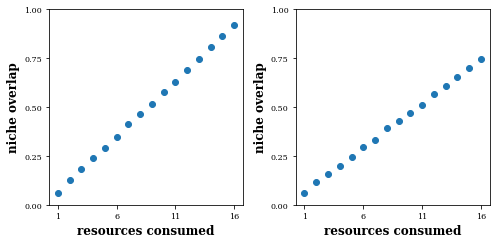

In [25]:
destfolder='/Users/ashish/Dropbox/research/ecology/Figures/Fig_niche_overlap_vs_consumption_sparsity/'
n_replicates=10
n_res=16
meanc_vals=np.arange(n_res)+1
def make_c_matrix_lognormal(n_res,meanc,mu=1, sigma=1):
    c=np.zeros((n_res,n_res))
    for i in range(n_res):
        idx_nonzero=np.random.choice(n_res,meanc, replace=False)  
        c[i,idx_nonzero]=np.random.lognormal(mean=mu, sigma=sigma,size=meanc)
    return c


fig = plt.figure(figsize=(7,3.5)) 
ax1 = fig.add_subplot(1,2,1)  
logmean,logvar=0,.3
actual_mean=np.exp(logmean)
actual_var=(np.exp(logvar**2)-1)*np.exp(2*logmean + logvar**2)
print ('ax1: mean= ',actual_mean, 'var= ', actual_var)
limit_val=actual_mean**2/(actual_var+actual_mean**2)
print('just a heuristic estimate, doesnt apply exactly because sum of lognormal is not lognormal and so need to account for 16 row elements',limit_val)
print('heuristic doesntwork actually')
niche_overlaps_list=[]
for i, meanc in enumerate(meanc_vals):
    niche_overlaps_list.append([])
    for j in range(n_replicates):        
        c_matrix=make_c_matrix_lognormal(n_res,meanc,mu=logmean, sigma=logvar)
        niche_overlap=np.mean(1-scipy.spatial.distance.pdist(c_matrix,'cosine'))
        niche_overlaps_list[i].append(niche_overlap)

avg_niche_overlap_arr=np.array([np.mean(k) for k in niche_overlaps_list])
stderr_niche_overlap_arr=np.array([np.std(k) for k in niche_overlaps_list]
                                 )/np.sqrt(n_replicates)



ax1.errorbar(meanc_vals,avg_niche_overlap_arr, yerr=stderr_niche_overlap_arr, fmt='o')
# ax1.plot([meanc_vals[0],meanc_vals[-1]],  [limit_val,limit_val],'k--')

ax1.set_xticks([1,6,11, 16])
ax1.set_xlabel('resources consumed',fontweight="bold",fontsize=fontSize)
ax1.set_ylabel('niche overlap',fontweight="bold",fontsize=fontSize)
ax1.set_yticks([0,0.25,0.5,0.75,1.])
# ax1.text(-0.15,1.05,'A',fontweight="bold",transform=ax1.transAxes,fontsize=fontSize)


ax2 = fig.add_subplot(1,2,2)  
logmean,logvar=.6,.6
actual_mean=np.exp(logmean)
actual_var=(np.exp(logvar**2)-1)*np.exp(2*logmean + logvar**2)
print ('ax2: mean= ',actual_mean, 'var= ', actual_var)
limit_val=actual_mean**2/(actual_var+actual_mean**2)
print(limit_val)
print ('estimate doesnt work for lognormal distribution')
niche_overlaps_list=[]
for i, meanc in enumerate(meanc_vals):
    niche_overlaps_list.append([])
    for j in range(n_replicates):        
        c_matrix=make_c_matrix_lognormal(n_res,meanc,mu=logmean, sigma=logvar)
        niche_overlap=np.mean(1-scipy.spatial.distance.pdist(c_matrix,'cosine'))
        niche_overlaps_list[i].append(niche_overlap)

avg_niche_overlap_arr=np.array([np.mean(k) for k in niche_overlaps_list])
stderr_niche_overlap_arr=np.array([np.std(k) for k in niche_overlaps_list]
                                 )/np.sqrt(n_replicates)


ax2.errorbar(meanc_vals,avg_niche_overlap_arr, yerr=stderr_niche_overlap_arr, fmt='o')
# ax2.plot([meanc_vals[0],meanc_vals[-1]],[limit_val,limit_val],'k--')
ax2.set_xticks([1,6,11, 16])
ax2.set_xlabel('resources consumed',fontweight="bold",fontsize=fontSize)
ax2.set_ylabel('niche overlap',fontweight="bold",fontsize=fontSize)
ax2.set_yticks([0,0.25,0.5,0.75,1.])
# ax2.text(-0.15,1.05,'B',fontweight="bold",transform=ax2.transAxes,fontsize=fontSize)


fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(destfolder+"niche_overlap_vs_sparsity-lognormal.pdf")


# Fig Search performance vs ruggedness

## 4 panel version including Clark

UB= 17


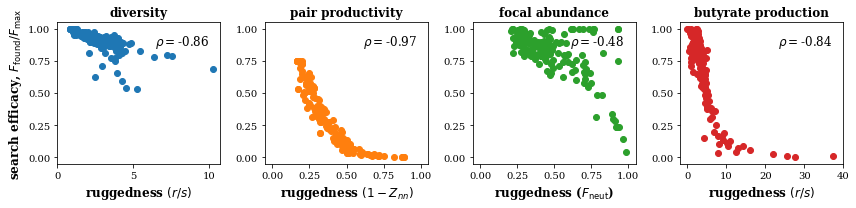

In [9]:
destfolder='/Users/ashish/Dropbox/research/ecology/Figures/Fig_Correlation_Search_Sparsity_Ruggedness_beforeAveraging/'
if not os.path.exists(destfolder): os.makedirs(destfolder) 

############################ for CR model ############################
fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled_AGG/"
parameter_name='mean_c'
parameter_list=OrderedDict([ ('SM',[16] ), ('mean_c', "1 to param1{'LB' : 1}")])
_,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
folder_suffix='SM'


ctr=0
for agg_filename in glob.glob(fold_agg+'AggAnalysis_*.dat'):
        ctr+=1
assert ctr==1, print ('number of files that matched was',ctr,'instead')
agg_data=pickle.load(open(agg_filename, 'rb'))


color_list=create_color_list(scheme_name='sns_tab10')

fig = plt.figure(figsize=(12,3)) 

ax1 = fig.add_subplot(1,4,1)  
community_function='Shannon Diversity'
Xlabel=r'roughness-slope, $r/s$'
Xlabel=r'ruggedness $(r/s)$'
X_key=': '+community_function+': r/s'
Ylabel=r'search efficacy, $F_{\mathrm{found}}/F_{\mathrm{max}}$'
Y_key=': '+community_function+': mean_relative_optimum_Greediest'
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key) 
# Yvalues=replace_Nones_with(Yvalues,value=1.)
# Xvalues=replace_Nones_with(Xvalues,value=0.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
ax1=plot_SpearmanScatterplot(ax1, Xvalues, Yvalues, text_rho=True,text_loc=[0.6,0.8],label_name='diversity', color=color_list[0])
ax1.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax1.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax1.set_title(r'diversity',fontweight="bold",fontsize=fontSize)
ax1.set_xticks([0,5,10])
ax1.set_yticks([0,0.25,0.5,0.75,1.])
ax1.set_ylim(-0.05, 1.05)
# ax2.set_yticks([0.5,0.75,1.])
# ax2.set_ylim([0.4,1.05])
# ax2.legend(loc='upper right', bbox_to_anchor=(1.,1.),fontsize=fontSize-2)
# ax1.text(-0.2,1.05,'A',fontweight="bold",transform=ax1.transAxes,fontsize=fontSize)




ax2 = fig.add_subplot(1,4,2) 
# community_function='Species 2'
# label_name='focal species'

# community_function='Species 2,3 coex_product'
# community_function='Species 2'

community_function='Species 2,3 coex_product FullLandscape'
ax2.set_title(r'pair productivity',fontweight="bold",fontsize=fontSize)

label_name=''
Xlabel=r'ruggedness $(1-Z_{nn})$'
X_key=': '+community_function+': nn_correlation' 

Ylabel=r'search efficacy, $F_{\mathrm{found}}/ F_{\mathrm{max}}$'
Y_key=': '+community_function+': mean_relative_optimum_Greediest'
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
# Yvalues=replace_Nones_with(Yvalues,value=1.)
# Xvalues=replace_Nones_with(Xvalues,value=1.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
ax2=plot_SpearmanScatterplot(ax2, 1.-Xvalues, Yvalues, text_rho=True,text_loc=[0.6,0.8],label_name=label_name, color=color_list[1])
# ax2.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax2.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax2.set_xlim(-0.05, 1.05)
ax2.set_xticks([0,0.25,0.5,0.75,1.])
ax2.set_yticks([0,0.25,0.5,0.75,1.])
ax2.set_ylim(-0.05, 1.05)
# ax2.text(-0.2,1.05,'B',fontweight="bold",transform=ax2.transAxes,fontsize=fontSize)


ax3 = fig.add_subplot(1,4,3)  
community_function='Species 2'
# community_function='Species 2,3 coex_product'
Xlabel=r'ruggedness ($F_{\mathrm{neut}}$)'
X_key=': '+community_function+': f_neutral_links'
Ylabel=r'search efficacy, $F_{\mathrm{found}}/F_{\mathrm{max}}$'
Y_key=': '+community_function+': mean_relative_optimum_Greediest'
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key) 
# Yvalues=replace_Nones_with(Yvalues,value=1.)
# Xvalues=replace_Nones_with(Xvalues,value=0.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
ax3=plot_SpearmanScatterplot(ax3, Xvalues, Yvalues, text_rho=True,text_loc=[0.6,0.8],label_name='diversity', color=color_list[2])
# ax3.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax3.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax3.set_title(r'focal abundance',fontweight="bold",fontsize=fontSize)
ax3.set_xlim(-0.05, 1.05)
ax3.set_ylim(-0.05, 1.05)
ax3.set_xticks([0,0.25,0.5,0.75,1.])
ax3.set_yticks([0,0.25,0.5,0.75,1.])
# ax3.text(-0.2,1.05,'C',fontweight="bold",transform=ax3.transAxes,fontsize=fontSize)


ax4 = fig.add_subplot(1,4,4)  
community_function='Clark_M3'
Xlabel=r'ruggedness $(r/s)$'
X_key=': '+community_function+': r/s'
Ylabel=r'search efficacy, $F_{\mathrm{found}}/F_{\mathrm{max}}$'
Y_key=': '+community_function+': mean_relative_optimum_Greediest'
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key) 
# Yvalues=replace_Nones_with(Yvalues,value=1.)
# Xvalues=replace_Nones_with(Xvalues,value=0.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
ax4=plot_SpearmanScatterplot(ax4, Xvalues, Yvalues, text_rho=True,text_loc=[0.6,0.8],
                             label_name='diversity', color=color_list[3])
# ax4.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax4.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax4.set_title(r'butyrate production',fontweight="bold",fontsize=fontSize)
# ax4.set_xlim(-0.05, 1.05)
ax4.set_ylim(-0.05, 1.05)
ax4.set_xticks([0,10, 20, 30, 40])
ax4.set_yticks([0,0.25,0.5,0.75,1.])
# ax4.text(-0.2,1.05,'D',fontweight="bold",transform=ax4.transAxes,fontsize=fontSize)


for ax_temp in [ax1,ax2,ax3,ax4]:
    ax_temp.tick_params(labelsize= labelSize)

# plt.setp(ax3.get_yticklabels(), visible=False)
# plt.setp(ax2.get_yticklabels(), visible=False)
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(destfolder+"Search_vs_ruggedness"+folder_suffix+"-4panel.pdf")


## 3 panel version

UB= 17


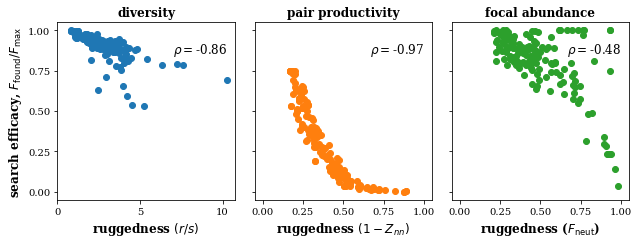

In [9]:
destfolder='/Users/ashish/Dropbox/research/ecology/Figures/Fig_Correlation_Search_Sparsity_Ruggedness_beforeAveraging/'
if not os.path.exists(destfolder): os.makedirs(destfolder) 

############################ for CR model ############################
fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled_AGG/"
parameter_name='mean_c'
parameter_list=OrderedDict([ ('SM',[16] ), ('mean_c', "1 to param1{'LB' : 1}")])
_,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
folder_suffix='SM'


ctr=0
for agg_filename in glob.glob(fold_agg+'AggAnalysis_*.dat'):
        ctr+=1
assert ctr==1, print ('number of files that matched was',ctr,'instead')
agg_data=pickle.load(open(agg_filename, 'rb'))


color_list=create_color_list(scheme_name='sns_tab10')

fig = plt.figure(figsize=(9,3.5)) 
# ax1 = plt.subplot(131)
# ax2 = plt.subplot(132, sharey=ax1)
# ax3 = plt.subplot(133, sharey = ax1)


# fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(9,3.5))

ax1 = fig.add_subplot(1,3,1)  
community_function='Shannon Diversity'
Xlabel=r'roughness-slope, $r/s$'
Xlabel=r'ruggedness $(r/s)$'
X_key=': '+community_function+': r/s'
Ylabel=r'search efficacy, $F_{\mathrm{found}}/F_{\mathrm{max}}$'
Y_key=': '+community_function+': mean_relative_optimum_Greediest'
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key) 
# Yvalues=replace_Nones_with(Yvalues,value=1.)
# Xvalues=replace_Nones_with(Xvalues,value=0.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
ax1=plot_SpearmanScatterplot(ax1, Xvalues, Yvalues, text_rho=True,text_loc=[0.65,0.8],label_name='diversity', color=color_list[0])
ax1.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax1.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax1.set_title(r'diversity',fontweight="bold",fontsize=fontSize)
ax1.set_xticks([0,5,10])
ax1.set_yticks([0,0.25,0.5,0.75,1.])
ax1.set_ylim(-0.05, 1.05)
# ax2.set_yticks([0.5,0.75,1.])
# ax2.set_ylim([0.4,1.05])
# ax2.legend(loc='upper right', bbox_to_anchor=(1.,1.),fontsize=fontSize-2)
# ax2.text(-0.2,1.05,'B',fontweight="bold",transform=ax2.transAxes,fontsize=fontSize)




ax2 = fig.add_subplot(1,3,2) 
# community_function='Species 2'
# label_name='focal species'

# community_function='Species 2 coex_product'
# ax1.set_title(r'focal productivity',fontweight="bold",fontsize=fontSize)#, $N_i (N-N_i)$

# community_function='Species 2,3 coex_product'
# community_function='Species 2'

community_function='Species 2,3 coex_product FullLandscape'
ax2.set_title(r'pair productivity',fontweight="bold",fontsize=fontSize)

label_name=''
Xlabel=r'ruggedness $(1-Z_{nn})$'
X_key=': '+community_function+': nn_correlation' 

Ylabel=r'search efficacy, $F_{\mathrm{found}}/ F_{\mathrm{max}}$'
Y_key=': '+community_function+': mean_relative_optimum_Greediest'
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
# Yvalues=replace_Nones_with(Yvalues,value=1.)
# Xvalues=replace_Nones_with(Xvalues,value=1.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
ax2=plot_SpearmanScatterplot(ax2, 1.-Xvalues, Yvalues, text_rho=True,text_loc=[0.65,0.8],label_name=label_name, color=color_list[1])
# ax2.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax2.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax2.set_xlim(-0.05, 1.05)
ax2.set_xticks([0,0.25,0.5,0.75,1.])
ax2.set_yticks([0,0.25,0.5,0.75,1.])
ax2.set_ylim(-0.05, 1.05)
# ax2.text(-0.2,1.05,'A',fontweight="bold",transform=ax1.transAxes,fontsize=fontSize)


ax3 = fig.add_subplot(1,3,3)  
community_function='Species 2'
# community_function='Species 2,3 coex_product'
Xlabel=r'ruggedness ($F_{\mathrm{neut}}$)'
X_key=': '+community_function+': f_neutral_links'
Ylabel=r'search efficacy, $F_{\mathrm{found}}/F_{\mathrm{max}}$'
Y_key=': '+community_function+': mean_relative_optimum_Greediest'
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key) 
# Yvalues=replace_Nones_with(Yvalues,value=1.)
# Xvalues=replace_Nones_with(Xvalues,value=0.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
ax3=plot_SpearmanScatterplot(ax3, Xvalues, Yvalues, text_rho=True,text_loc=[0.65,0.8],label_name='diversity', color=color_list[2])
# ax3.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax3.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax3.set_title(r'focal abundance',fontweight="bold",fontsize=fontSize)
ax3.set_xlim(-0.05, 1.05)
ax3.set_ylim(-0.05, 1.05)
ax3.set_xticks([0,0.25,0.5,0.75,1.])
ax3.set_yticks([0,0.25,0.5,0.75,1.])


for ax_temp in [ax1,ax2,ax3]:
    ax_temp.tick_params(labelsize= labelSize)

plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(destfolder+"Search_vs_ruggedness"+folder_suffix+"-3panel.pdf")


#### test Clark M3

UB= 17


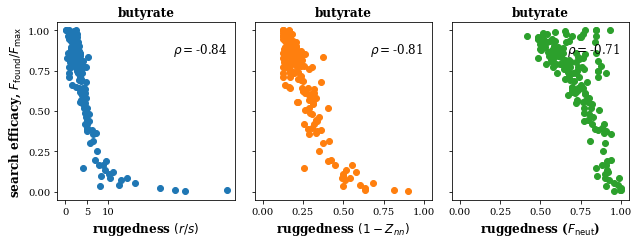

In [7]:
destfolder='/Users/ashish/Dropbox/research/ecology/Figures/Fig_Correlation_Search_Sparsity_Ruggedness_beforeAveraging/'
if not os.path.exists(destfolder): os.makedirs(destfolder) 

# ############################ for CR model ############################
fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled_AGG/"
parameter_name='mean_c'
parameter_list=OrderedDict([ ('SM',[16] ), ('mean_c', "1 to param1{'LB' : 1}")])
_,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
folder_suffix='SM'






ctr=0
for agg_filename in glob.glob(fold_agg+'AggAnalysis_*.dat'):
        ctr+=1
assert ctr==1, print ('number of files that matched was',ctr,'instead')
agg_data=pickle.load(open(agg_filename, 'rb'))


color_list=create_color_list(scheme_name='sns_tab10')

fig = plt.figure(figsize=(9,3.5)) 
# ax1 = plt.subplot(131)
# ax2 = plt.subplot(132, sharey=ax1)
# ax3 = plt.subplot(133, sharey = ax1)


# fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(9,3.5))

ax1 = fig.add_subplot(1,3,1)  
# community_function='Shannon Diversity'
community_function='Clark_M3'
Xlabel=r'roughness-slope, $r/s$'
Xlabel=r'ruggedness $(r/s)$'
X_key=': '+community_function+': r/s'
Ylabel=r'search efficacy, $F_{\mathrm{found}}/F_{\mathrm{max}}$'
Y_key=': '+community_function+': mean_relative_optimum_Greediest'
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key) 
# Yvalues=replace_Nones_with(Yvalues,value=1.)
# Xvalues=replace_Nones_with(Xvalues,value=0.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
ax1=plot_SpearmanScatterplot(ax1, Xvalues, Yvalues, text_rho=True,text_loc=[0.65,0.8],label_name='diversity', color=color_list[0])
ax1.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax1.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax1.set_title(r'butyrate',fontweight="bold",fontsize=fontSize)
ax1.set_xticks([0,5,10])
ax1.set_yticks([0,0.25,0.5,0.75,1.])
ax1.set_ylim(-0.05, 1.05)
# ax2.set_yticks([0.5,0.75,1.])
# ax2.set_ylim([0.4,1.05])
# ax2.legend(loc='upper right', bbox_to_anchor=(1.,1.),fontsize=fontSize-2)
# ax2.text(-0.2,1.05,'B',fontweight="bold",transform=ax2.transAxes,fontsize=fontSize)




ax2 = fig.add_subplot(1,3,2) 
# community_function='Species 2'
# label_name='focal species'

# community_function='Species 2 coex_product'
# ax1.set_title(r'focal productivity',fontweight="bold",fontsize=fontSize)#, $N_i (N-N_i)$

# community_function='Species 2,3 coex_product'
# community_function='Species 2'

# community_function='Species 2,3 coex_product FullLandscape'

community_function='Clark_M3'

ax2.set_title(r'butyrate',fontweight="bold",fontsize=fontSize)

label_name=''
Xlabel=r'ruggedness $(1-Z_{nn})$'
X_key=': '+community_function+': nn_correlation' 

Ylabel=r'search efficacy, $F_{\mathrm{found}}/ F_{\mathrm{max}}$'
Y_key=': '+community_function+': mean_relative_optimum_Greediest'
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
# Yvalues=replace_Nones_with(Yvalues,value=1.)
# Xvalues=replace_Nones_with(Xvalues,value=1.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
ax2=plot_SpearmanScatterplot(ax2, 1.-Xvalues, Yvalues, text_rho=True,text_loc=[0.65,0.8],label_name=label_name, color=color_list[1])
# ax2.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax2.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax2.set_xlim(-0.05, 1.05)
ax2.set_xticks([0,0.25,0.5,0.75,1.])
ax2.set_yticks([0,0.25,0.5,0.75,1.])
ax2.set_ylim(-0.05, 1.05)
# ax2.text(-0.2,1.05,'A',fontweight="bold",transform=ax1.transAxes,fontsize=fontSize)


ax3 = fig.add_subplot(1,3,3)  
# community_function='Species 2'

community_function='Clark_M3'
Xlabel=r'ruggedness ($F_{\mathrm{neut}}$)'
X_key=': '+community_function+': f_neutral_links'
Ylabel=r'search efficacy, $F_{\mathrm{found}}/F_{\mathrm{max}}$'
Y_key=': '+community_function+': mean_relative_optimum_Greediest'
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key) 
# Yvalues=replace_Nones_with(Yvalues,value=1.)
# Xvalues=replace_Nones_with(Xvalues,value=0.)
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
ax3=plot_SpearmanScatterplot(ax3, Xvalues, Yvalues, text_rho=True,text_loc=[0.65,0.8],label_name='diversity', color=color_list[2])
# ax3.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax3.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax3.set_title(r'butyrate',fontweight="bold",fontsize=fontSize)
ax3.set_xlim(-0.05, 1.05)
ax3.set_ylim(-0.05, 1.05)
ax3.set_xticks([0,0.25,0.5,0.75,1.])
ax3.set_yticks([0,0.25,0.5,0.75,1.])


for ax_temp in [ax1,ax2,ax3]:
    ax_temp.tick_params(labelsize= labelSize)

plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(destfolder+"Search_vs_ruggedness"+folder_suffix+"-Clark-3panel.pdf")


## Table of ruggedness-search correlation

In [2]:
def get_df_SearchRugg_correlations(agg_data,parameter_list, df_keyname_prefix_list, simulation_suffix, comm_func_suffix_list,community_function_list, df=None,output_pvalues=False):
    for comm_func_suffix,community_function in zip(comm_func_suffix_list,community_function_list):

        summary_dict={}
        Y_key=': '+community_function+': mean_relative_optimum_Greediest'

        ruggedness_measure='resources consumed'
        X_key=[': exp_case', 'mean_c'] 
#         ruggedness_measure='leakage fraction'
#         X_key=[': exp_case', 'l'] 
        Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key) 
        Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
        SpearmanRvalue=spearmanr(Xvalues, Yvalues).correlation
        summary_dict.update({ruggedness_measure:SpearmanRvalue})
        
        
        ruggedness_measure='roughness-slope, r/s'
        X_key=': '+community_function+': r/s' 
        Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key) 
        Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
        SpearmanRvalue,pvalue=spearmanr(Xvalues, Yvalues)
        summary_dict.update({ruggedness_measure:SpearmanRvalue})
        if output_pvalues: summary_dict.update({ruggedness_measure+'_pval':pvalue})
        
        ruggedness_measure='Frac. neutral directions'
        Y_key=': '+community_function+': mean_relative_optimum_Greediest'
        X_key=': '+community_function+': f_neutral_links'
        Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key) 
        Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
        SpearmanRvalue,pvalue=spearmanr(Xvalues, Yvalues)
        summary_dict.update({ruggedness_measure:SpearmanRvalue})
        if output_pvalues: summary_dict.update({ruggedness_measure+'_pval':pvalue})

#         ruggedness_measure='near. neigh. corr.'
        ruggedness_measure='nn. uncorrerlatedness'
        Y_key=': '+community_function+': mean_relative_optimum_Greediest'
        X_key=': '+community_function+': nn_correlation'
        Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key) 
        Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
        SpearmanRvalue,pvalue=spearmanr(1.-Xvalues, Yvalues)
        summary_dict.update({ruggedness_measure:SpearmanRvalue})
        if output_pvalues: summary_dict.update({ruggedness_measure+'_pval':pvalue})
        
        
        
#         ruggedness_measure='var. unexp., U'
#         Y_key=': '+community_function+': mean_relative_optimum_Greediest'
#         X_key=': '+community_function+': variance_explained_linear'
#         Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key) 
#         Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
#         Xvalues=1.-Xvalues
#         SpearmanRvalue=spearmanr(Xvalues, Yvalues).correlation
#         summary_dict.update({ruggedness_measure:SpearmanRvalue})




#         ruggedness_measure='FDC'
#         Y_key=': '+community_function+': mean_relative_optimum_Greediest'
#         X_key=': '+community_function+': FDC'
#         Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key) 
#         Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
#         SpearmanRvalue=spearmanr(Xvalues, Yvalues).correlation
#         summary_dict.update({ruggedness_measure:SpearmanRvalue})

#         ruggedness_measure='ranked FDC'
#         Y_key=': '+community_function+': mean_relative_optimum_Greediest'
#         X_key=': '+community_function+': ranked_FDC'
#         Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key) 
#         Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
#         SpearmanRvalue=spearmanr(Xvalues, Yvalues).correlation
#         summary_dict.update({ruggedness_measure:SpearmanRvalue})


#         ruggedness_measure='SWO'
#         X_key=': '+community_function+': SWO'
#         Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key) 
#         Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
#         SpearmanRvalue=spearmanr(Xvalues, Yvalues).correlation
#         summary_dict.update({ruggedness_measure:SpearmanRvalue})

#         ruggedness_measure='landscape entropy'
#         Y_key=': '+community_function+': mean_relative_optimum_Greediest'
#         X_key=': landscape structure: effective number of states'
#         Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key) 
#         Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
#         SpearmanRvalue=spearmanr(Xvalues, Yvalues).correlation
#         summary_dict.update({ruggedness_measure:SpearmanRvalue})

#         ruggedness_measure='1-Rbar^2'
#         Y_key=': '+community_function+': mean_relative_optimum_Greediest'
#         X_key=': landscape structure: Abundance vector fit Subsetted R2avg'
#         Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key) 
#         Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
#         Xvalues=1.-Xvalues
#         SpearmanRvalue=spearmanr(Xvalues, Yvalues).correlation
#         summary_dict.update({ruggedness_measure:SpearmanRvalue})

#         ruggedness_measure='# +ve critical points'
#         Y_key=': '+community_function+': mean_relative_optimum_Greediest'
#         X_key1=': '+community_function+': N_maxima'
#         X_key2=': '+community_function+': N_saddle'

#         Xvalues1, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key1,Y_key) 
#         Xvalues1, Yvalues=remove_Nones(Xvalues1,Yvalues)
#         Xvalues2, Yvalues2= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key2,Y_key) 
#         Xvalues2, Yvalues2=remove_Nones(Xvalues2,Yvalues2)
#         Xvalues=np.asarray(Xvalues1)+np.asarray(Xvalues2)
#         SpearmanRvalue=spearmanr(Xvalues, Yvalues).correlation
#         summary_dict.update({ruggedness_measure:SpearmanRvalue})

#         ruggedness_measure='PSpec ratio'
#         Y_key=': '+community_function+': mean_relative_optimum_Greediest'
#         X_key=': '+community_function+': PS_ratio'
#         Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key) 
#         Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
#         Xvalues=1.-Xvalues
#         SpearmanRvalue=spearmanr(Xvalues, Yvalues).correlation
#         summary_dict.update({ruggedness_measure:SpearmanRvalue})

#         ruggedness_measure='# degenerate points'
#         Y_key=': '+community_function+': mean_relative_optimum_Greediest'
#         X_key=': '+community_function+': N_saddle'
#         Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key) 
#         Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
#         SpearmanRvalue=spearmanr(Xvalues, Yvalues).correlation
#         summary_dict.update({ruggedness_measure:SpearmanRvalue})

#         ruggedness_measure='# of final states'
#         Y_key=': '+community_function+': mean_relative_optimum_Greediest'
#         X_key=': landscape structure: frequency of states'
#         Count_values, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key) 
#         idx_true=np.where(Yvalues!=None)[0]
#         Xvalues=np.zeros_like(Yvalues)*1.
#         S=len( Yvalues)/10
#     #     print (len(Xvalues))
#         for idx in idx_true:
#             Xvalues[idx]=len(Count_values[idx])*1./2**S
#         Xvalues=Xvalues[idx_true]
#         Yvalues=Yvalues[idx_true]
#         SpearmanRvalue=spearmanr(Xvalues, Yvalues).correlation
#         summary_dict.update({ruggedness_measure:SpearmanRvalue})

        temp_df=pd.DataFrame.from_dict(summary_dict,orient='index',columns=[simulation_suffix+' - '+comm_func_suffix])

#         if ctr==0:
        if df is None:
            df=temp_df
        else:
            df=pd.concat([df, temp_df], axis=1)

        

    return df

In [3]:
destfolder='/Users/ashish/Dropbox/research/ecology/Figures/Fig_Correlation_Search_Sparsity_Ruggedness_beforeAveraging/'
if not os.path.exists(destfolder): os.makedirs(destfolder) 

# community_function_list=['Species 0','Species 1','Species 2','Simpsons Diversity','Shannon Diversity']
# comm_func_suffix_list=['Sp0','Sp1','Sp2','SimpsonsD','ShannonD']   

##currently only for CR model ##
# community_function_list=['Species 0','Species 1','Species 2','Simpsons Diversity','Shannon Diversity',
#                         'Species 0 coex_product','Species 2 coex_product', 'Species 0,3 coex_product','Species 2,3 coex_product']
# comm_func_suffix_list=['Sp0','Sp1','Sp2','SimpsonsD','ShannonD','Sp0xN','Sp2xN','Sp0x3','Sp2x3'] 

# community_function_list=['Species 0','Species 2','Shannon Diversity',
#                         'Species 0 coex_product','Species 2 coex_product', 'Species 2,3 coex_product','Species 2,3 coex_product FullLandscape']
# comm_func_suffix_list=['Sp0','Sp2','ShannonD','Sp0xN','Sp2xN','Sp2x3','Sp2x3_full'] 


community_function_list=['Species 0','Species 2','Shannon Diversity','Simpsons Diversity',
                        'Species 0 coex_product','Species 2 coex_product', 
                        'Species 2,3 coex_product','Species 2,3 coex_product FullLandscape',
                        'Clark_M3']
comm_func_suffix_list=['Sp0','Sp2','ShannonD', 'SimpsonsD','Sp0xN','Sp2xN','Sp2x3','Sp2x3_full','Clark_M3'] 



########################### for CR model ############################
fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled_AGG/"
parameter_name='mean_c'
#parameter_list=OrderedDict([ ('SM',[8, 12, 16] ), ('mean_c', "1 to param1{'LB' : 1}")])
parameter_list=OrderedDict([ ('SM',[16] ), ('mean_c', "1 to param1{'LB' : 1}")])
folder_suffix='SM'

# ############################ for CR model with M=2S############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM2_CfixednumGamma_meanC_compiled_AGG/"
# parameter_name='mean_c'
# parameter_list=OrderedDict([ ('SM2-',[16] ), ('mean_c', "1 to param1{'step_size' : 2,'LB' : 1,'UB_X':2}")])
# folder_suffix='SM2'

############################ for CR model with S=2M ############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SMp5_CfixednumGamma_meanC_compiled_AGG/"
# parameter_name='mean_c'
# parameter_list=OrderedDict([ ('SMp5',[16] ), ("mean_c", "1 to param1{'LB' : 1,'step_size' : 1, 'UB_X' : 0.5}")])
# folder_suffix='SMp5'


############################ CF l ############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CF_CfixedxGamma01Special_l_compiled_AGG/"
# parameter_name='l'
# ''' l=0 is not included because focal species abundance doesn't make sense for it'''
# parameter_list={parameter_name:[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]}
# folder_suffix='CF_l'

############################ CF meanC ############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CF_CfixedxGamma0Special_meanC_compiled_AGG/"
# parameter_name='mean_c'
# parameter_list={parameter_name:[1,2,3,4,5,6,7,8,9,10,11,12]}
# folder_suffix='CF_meanC'

# ########################## CF Rsupply_constTotR############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CF_CfixedxGamma_Rsupply_constTotR_compiled_AGG/"
# parameter_name='Rsupply_constTotR'
# parameter_list={parameter_name:[1,2,3,4,5,6,7,8,9,10,11,12]}
# folder_suffix='CF_Rsupply_constTotR'

# ########################### CF Rsupply_constR0############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CF_CfixedxGamma_Rsupply_constR0_compiled_AGG/"
# parameter_name='Rsupply_constR0'
# parameter_list={parameter_name:[1,2,3,4,5,6,7,8,9,10,11,12]}
# folder_suffix='CF_Rsupply_constR0'


_,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)    
ctr=0
for agg_filename in glob.glob(fold_agg+'AggAnalysis_*.dat'):
        ctr+=1
assert ctr==1, print ('number of files that matched was',ctr,'instead')
agg_data=pickle.load(open(agg_filename, 'rb'))


df=get_df_SearchRugg_correlations(agg_data,parameter_list, df_keyname_prefix_list, 
                                  folder_suffix,comm_func_suffix_list,
                                  community_function_list,df=None,output_pvalues=True)


    
    

print ('was there any NaN?',df[df.isna().any(axis=1)])
styled_table = df.dropna().style.background_gradient(cmap='RdBu')
styled_table.set_precision(4)
display(styled_table)
df.to_csv(destfolder+'table_'+folder_suffix+'.csv', header=True)
######### rename columns  #######  
# df2=df.drop(columns=[folder_suffix+' - '+'Sp0',folder_suffix+' - '+'Sp1',folder_suffix+' - '+"SimpsonsD"])
# df2=df2.drop(index=['# of final states','# +ve critical points', 'PSpec ratio',
#                    '# degenerate points'])
# df2.rename(columns={folder_suffix+' - '+"ShannonD":"Diversity",
#                    folder_suffix+' - '+"Sp2":"Focal Species" }, 
#                  inplace=True)
# styled_table2 = df2.dropna().style.background_gradient(cmap='RdBu')
# styled_table2.set_precision(2)
# display(styled_table2)
# df2.to_csv(destfolder+'table_'+folder_suffix+'.csv', header=True)



UB= 17
was there any NaN? Empty DataFrame
Columns: [SM - Sp0, SM - Sp2, SM - ShannonD, SM - SimpsonsD, SM - Sp0xN, SM - Sp2xN, SM - Sp2x3, SM - Sp2x3_full, SM - Clark_M3]
Index: []


,SM - Sp0,SM - Sp2,SM - ShannonD,SM - SimpsonsD,SM - Sp0xN,SM - Sp2xN,SM - Sp2x3,SM - Sp2x3_full,SM - Clark_M3
resources consumed,-0.7012,-0.6852,-0.8305,-0.8784,-0.4808,-0.5584,-0.5964,-0.7797,-0.6273
"roughness-slope, r/s",-0.6060,-0.6218,-0.8618,-0.8350,-0.7345,-0.8292,-0.7755,-0.9702,-0.8436
"roughness-slope, r/s_pval",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Frac. neutral directions,-0.4019,-0.4792,-0.8297,-0.8346,-0.5211,-0.6854,-0.6831,-0.9154,-0.7115
Frac. neutral directions_pval,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
nn. uncorrerlatedness,-0.5660,-0.5962,-0.6026,-0.3493,-0.7263,-0.8184,-0.7591,-0.9704,-0.8055
nn. uncorrerlatedness_pval,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


# vector ruggedness measure

UB= 17
$R^2$ for specialists and generalists=  0.987 +- 0.011 ,  0.995 +- 0.002
Slope for specialists and generalists=  -0.88 +- 0.02 ,  -0.85 +- 0.01


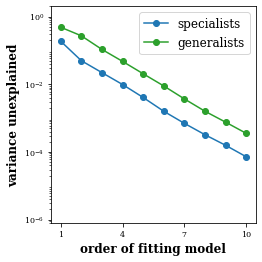

In [11]:
destfolder = '/Users/ashish/Dropbox/research/ecology/Figures/Fig_ruggedness_vs_consumption_sparsity/'
if not os.path.exists(destfolder):
    os.makedirs(destfolder)
########################### for CR model ############################
fold_agg = "/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled_AGG/"
parameter_name = 'mean_c'
parameter_list = OrderedDict(
    [('SM', [16]), ('mean_c', "1 to param1{'LB' : 1}")])
folder_suffix = 'SM'
param_chosen1 = [16, 2]
param_chosen2 = [16, 14]
label1 = r'$c_0=$'+str(param_chosen1[1])
label2 = r'$c_0=$'+str(param_chosen2[1])

label1 = r'specialists'
label2 = r'generalists'

# ############################ for CR model with M=2S############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM2_CfixednumGamma_meanC_compiled_AGG/"
# parameter_list=OrderedDict([ ('SM2-',[16] ), ('mean_c', "1 to param1{'step_size' : 2,'LB' : 3,'UB_X':2}")])
# folder_suffix='SM2'
# param_chosen1=[16,3]
# param_chosen2=[16,31]
# label1=r'$c_0=$'+str(param_chosen1[1])
# label2=r'$c_0=$'+str(param_chosen2[1])

############################ CF l ############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CF_CfixedxGamma01Special_l_compiled_AGG/"
# parameter_name='l'
# ''' l=0 is not included because focal species abundance doesn't make sense for it'''
# parameter_list={parameter_name:[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]}
# folder_suffix='CF_l'
# param_chosen1=0.1
# # param_chosen2=0.8
# label1=r'$l=$'+str(param_chosen1)
# label2=r'$l=$'+str(param_chosen2)

# ############################ CF meanC ############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CF_CfixedxGamma0Special_meanC_compiled_AGG/"
# parameter_name='mean_c'
# parameter_list={parameter_name:[1,2,3,4,5,6,7,8,9,10,11,12]}
# folder_suffix='CF_meanC'
# param_chosen1=2
# param_chosen2=11
# label1=r'$c_0=$'+str(param_chosen1)
# label2=r'$c_0=$'+str(param_chosen2)

_, parameter_list, df_keyname_prefix_list = create_replicate_lists(
    parameter_list, [destfolder], 0, return_dfkeynames=True)

ctr = 0
for agg_filename in glob.glob(fold_agg+'AggAnalysis_*.dat'):
    ctr += 1
assert ctr == 1, print('number of files that matched was', ctr, 'instead')
agg_data = pickle.load(open(agg_filename, 'rb'))


def find_idx_in_list(param_list, element):
    for idx, param in enumerate(param_list):
        if param == element:
            return idx
    return None


def remove_None_from_single_2level_list(the_list):
    new_list = []
    for val in the_list:
        if val is not None:
            new_list.append(val)
    return new_list


# community_function='Simpsons Diversity'
# comm_func_suffix='SimpsonsD'
community_function = 'Shannon Diversity'
comm_func_suffix = 'ShannonD'
# community_function='Species 2,3 coex_product'
# comm_func_suffix='Sp23_coex'
# community_function='Species 2 coex_product'
# comm_func_suffix='Sp2_coex'
# community_function='Species 0'
# comm_func_suffix='Sp0'
# community_function='Species 2'
# comm_func_suffix='Sp2'

color_list = create_color_list(scheme_name='sns_tab10')
fig = plt.figure(figsize=(3.75, 3.75))

ax1 = fig.add_subplot()

# list(np.arange(10)) ### these are the sims to plot in the same figure
sims_to_plot = [0]
Ylabel = r'variance unexplained'
Xlabel = r'order of fitting model'
Y_key = ': '+community_function+': Power_spectrum'
# variance decomposition should start from order =1 only.

idx_param = find_idx_in_list(parameter_list, param_chosen1)
Pspec_lists = agg_data[df_keyname_prefix_list[idx_param]+Y_key]
Pspec_arr = np.array(remove_None_from_single_2level_list(Pspec_lists))[
    :, 1:]  # drop 0th component!
# normalize Power spectrum
Pspec_arr = Pspec_arr/np.sum(Pspec_arr, axis=1)[:, None]
ExpOrder_arr = np.arange(len(Pspec_arr[0]))+1
frac_Var_unexp_arr = 1.-np.cumsum(Pspec_arr, axis=1)
# frac_Var_unexp_avg= np.mean(frac_Var_unexp_arr,axis=0)
# frac_Var_unexp_stderr=np.std(frac_Var_unexp_arr,axis=0)/ len(Pspec_arr)

r2_list_specialists = []
slopes_list_specialists = []
intercept_list_specialists = []
for sim_idx in range(10):

    idx_cutoff = 10
    if np.any(frac_Var_unexp_arr[sim_idx, :idx_cutoff] < 1e-6):
        idx_cutoff = int(np.where(frac_Var_unexp_arr[sim_idx] < 1e-6)[0][0])

    if sim_idx in sims_to_plot:
        ax1.plot(ExpOrder_arr[:idx_cutoff], frac_Var_unexp_arr[sim_idx,
                                                               :idx_cutoff], '-o', color=color_list[0], label=label1)
    fit_coefs = np.polyfit(ExpOrder_arr[:idx_cutoff], np.log(
        frac_Var_unexp_arr[sim_idx, :idx_cutoff]), 1)
    fit_yvals = np.poly1d(fit_coefs)(ExpOrder_arr[:idx_cutoff])

#     print (r2_score(fit_yvals,np.log(frac_Var_unexp_arr[:idx_cutoff])) )
    r2_list_specialists.append(
        r2_score(fit_yvals, np.log(frac_Var_unexp_arr[sim_idx, :idx_cutoff])))
    slopes_list_specialists.append(fit_coefs[0])
    intercept_list_specialists.append(fit_coefs[1])

idx_param = find_idx_in_list(parameter_list, param_chosen2)
Pspec_lists = agg_data[df_keyname_prefix_list[idx_param]+Y_key]
Pspec_arr = np.array(remove_None_from_single_2level_list(Pspec_lists))[:, 1:]
Pspec_arr = Pspec_arr/np.sum(Pspec_arr, axis=1)[:, None]
ExpOrder_arr = np.arange(len(Pspec_arr[0]))+1
frac_Var_unexp_arr = 1.-np.cumsum(Pspec_arr, axis=1)
# frac_Var_unexp_avg= np.mean(frac_Var_unexp_arr,axis=0)
# frac_Var_unexp_stderr=np.std(frac_Var_unexp_arr,axis=0)/ len(Pspec_arr)

r2_list_generalists = []
slopes_list_generalists = []
intercept_list_generalists = []
for sim_idx in range(10):
    # for sim_idx in [0]:
    idx_cutoff = 10
    if np.any(frac_Var_unexp_arr[sim_idx, :idx_cutoff] < 1e-6):
        idx_cutoff = int(np.where(frac_Var_unexp_arr[sim_idx] < 1e-6)[0][0])

    if sim_idx in sims_to_plot:
        ax1.plot(ExpOrder_arr[:idx_cutoff], frac_Var_unexp_arr[sim_idx,
                                                               :idx_cutoff], '-o', color=color_list[2], label=label2)
    fit_coefs = np.polyfit(ExpOrder_arr[:idx_cutoff], np.log(
        frac_Var_unexp_arr[sim_idx, :idx_cutoff]), 1)
    fit_yvals = np.poly1d(fit_coefs)(ExpOrder_arr[:idx_cutoff])

#     print (r2_score(fit_yvals,np.log(frac_Var_unexp_arr[:idx_cutoff])) )
    r2_list_generalists.append(
        r2_score(fit_yvals, np.log(frac_Var_unexp_arr[sim_idx, :idx_cutoff])))
    slopes_list_generalists.append(fit_coefs[0])
    intercept_list_generalists.append(fit_coefs[1])

ax1.set_yscale('log')
ax1.set_ylabel(Ylabel, fontweight="bold", fontsize=fontSize)
ax1.set_xlabel(Xlabel, fontweight="bold", fontsize=fontSize)

ax1.legend(loc='best',fontsize=fontSize)

# ax1.text(-0.2,1.05,'B',fontweight="bold",transform=ax1.transAxes,fontsize=fontSize)

# ax1.set_xlim(.7,10.3)
ax1.set_xticks([1, 4, 7, 10])

ax1.set_yticks([1, 1e-2, 1e-4, 1e-6])

ax1.set_ylim([8e-7, 2])


plt.tight_layout()
fig.patch.set_facecolor('white')
if len(sims_to_plot) == 10:
    plt.savefig(destfolder+"Vector_VarUnexp"+folder_suffix +
                "-"+comm_func_suffix+"_single-all.pdf")
elif len(sims_to_plot) == 1:
    plt.savefig(destfolder+"Vector_VarUnexp"+folder_suffix+"-" +
                comm_func_suffix+"_single-sim"+str(sims_to_plot[0])+".pdf")
elif len(sims_to_plot) == 10:
    plt.savefig(destfolder+"Vector_VarUnexp"+folder_suffix +
                "-"+comm_func_suffix+"_single-few.pdf")


print(r'$R^2$ for specialists and generalists= ', round(np.mean(r2_list_specialists), 3), '+-', round(1.96*np.std(r2_list_specialists) /
                                                                                                      np.sqrt(10-1), 3), ', ', round(np.mean(r2_list_generalists), 3), '+-', round(1.96*np.std(r2_list_generalists)/np.sqrt(10-1), 3))
print(r'Slope for specialists and generalists= ', round(np.mean(slopes_list_specialists), 2), '+-', round(1.96*np.std(slopes_list_specialists) /
                                                                                                          np.sqrt(10-1), 2), ', ', round(np.mean(slopes_list_generalists), 2), '+-', round(1.96*np.std(slopes_list_generalists)/np.sqrt(10-1), 2))
# print (r'intercept for specialists and generalists= ',round(np.mean(intercept_list_specialists),2), '+-',round(1.96*np.std(intercept_list_specialists)/np.sqrt(10-1),2),', ',round(np.mean(intercept_list_generalists),2), '+-',round(1.96*np.std(intercept_list_generalists)/np.sqrt(10-1),2)  )

# estimating ruggedness

## 2 panel version just R^2

UB= 17


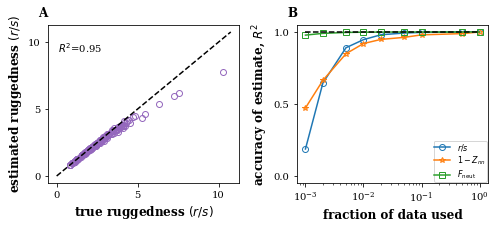

In [12]:
destfolder='/Users/ashish/Dropbox/research/ecology/Figures/Fig_estimating_ruggedness/'
########################### for CR model ############################
fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled_AGG/"
parameter_list=OrderedDict([ ('SM',[16] ), ('mean_c', "1 to param1{'LB' : 1}")])
_,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
folder_suffix='SM'


if not os.path.exists(destfolder): os.makedirs(destfolder)  
ctr=0
for agg_filename in glob.glob(fold_agg+'AggAnalysis_*.dat'):
        ctr+=1
assert ctr==1, print ('number of files that matched was',ctr,'instead')
agg_data=pickle.load(open(agg_filename, 'rb'))

 
color_list=create_color_list(scheme_name='sns_tab10')
fig = plt.figure(figsize=(7,3.3)) 

#######################
ax1 = fig.add_subplot(1,2,1) 
fraction_chosen=0.01
Ylabel=r'estimated ruggedness $(r/s)$'
Xlabel=r'true ruggedness $(r/s)$'
# community_function='Species 2'
community_function='Shannon Diversity'
X_key=': '+community_function+': r/s'
estFrac_key=': '+community_function+': est-rs_frac_data_list'
est_key=': '+community_function+': est-rs_estimate_list'

TrueValues,EstValues, EstStdErr=get_X_and_est_from_AGGdict(agg_data, parameter_list, df_keyname_prefix_list, X_key, estFrac_key, est_key, fraction_chosen,avg_the_estimate=True)
temp_copy=TrueValues[:]
TrueValues,EstValues=remove_Nones(TrueValues,EstValues)
_,EstStdErr=remove_Nones(temp_copy,EstStdErr)
R2=r2_score(TrueValues,EstValues)
ax1.plot(TrueValues,EstValues,'o',markerfacecolor='None',markeredgecolor=color_list[4])
# ax1.plot([np.min(TrueValues),np.max(TrueValues)],[np.min(TrueValues),np.max(TrueValues)] ,'k--')
ax1.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax1.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax1.text(-0.05,1.05,'A',fontweight="bold",transform=ax1.transAxes,fontsize=fontSize)
ax1.text(0.05,0.9, r'$R^2$='+'{:.2f}'.format(R2),horizontalalignment='left', verticalalignment='top', transform=ax1.transAxes ) 
ax1.set_yticks([0,5,10])
ax1.set_xticks([0,5,10])
ax1.plot(ax1.get_xlim(),ax1.get_xlim(),'k--')

#######################
ax2 = fig.add_subplot(1,2,2) 
fraction_list=np.array([0.001, 0.002, 0.005, 0.01,  0.02,  0.05,  0.1,   0.25,  0.5, 1. ])## 1 is manually inserted.
###r/s
R2_list=[]
idx_list=[]
Ylabel=r'accuracy of estimate, $R^2$'
Xlabel=r'fraction of data used'

X_key=': '+community_function+': r/s'
estFrac_key=': '+community_function+': est-rs_frac_data_list'
est_key=': '+community_function+': est-rs_estimate_list'

for idx, fraction_chosen in enumerate(fraction_list[:-1]): ## 1 is manually inserted
    TrueValues,EstValues, EstStdErr=get_X_and_est_from_AGGdict(agg_data, parameter_list, df_keyname_prefix_list, X_key, estFrac_key, est_key, fraction_chosen,avg_the_estimate=True)
    TrueValues,EstValues=remove_Nones(TrueValues,EstValues)    
    if len(TrueValues)>1:
        try: 
            r2_score(TrueValues,EstValues)
            if r2_score(TrueValues,EstValues)>0:
                R2_list.append(r2_score(TrueValues,EstValues))   
                idx_list.append(idx)
            else:
                print ('negative R2 at frac=',fraction_chosen, ' for ', X_key)
        except: 
            print ('r2 score returned NAN at frac=',fraction_chosen, ' for ', X_key)
            r2_score(TrueValues,EstValues)
idx_list.append(len(fraction_list)-1) ## the 1. data point which we manually insert
R2_list.append(1.)
ax2.plot(fraction_list[idx_list],R2_list,'o', color=color_list[0], markerfacecolor='None', linestyle='-',label=r'$r/s $')

###nncorrelation
R2_list=[]
idx_list=[]
X_key=': '+community_function+': nn_correlation'
estFrac_key=': '+community_function+': est-nnCorr_frac_data_list'
est_key=': '+community_function+': est-nnCorr_estimate_list'
for idx, fraction_chosen in enumerate(fraction_list[:-1]):
    TrueValues,EstValues, EstStdErr=get_X_and_est_from_AGGdict(agg_data, parameter_list, df_keyname_prefix_list, X_key, estFrac_key, est_key, fraction_chosen,avg_the_estimate=True)
    TrueValues,EstValues=remove_Nones(TrueValues,EstValues)   
    if len(TrueValues)>1:
        try: 
            r2_score(TrueValues,EstValues)
            if r2_score(TrueValues,EstValues)>0:
                R2_list.append(r2_score(TrueValues,EstValues))   
                idx_list.append(idx)
            else:
                print ('negative R2 at frac=',fraction_chosen, ' for ', X_key)
        except: 
            print ('r2 score returned NAN at frac=',fraction_chosen, ' for ', X_key)
            r2_score(TrueValues,EstValues)
idx_list.append(len(fraction_list)-1) ## the 1. data point which we manually insert
R2_list.append(1.)
ax2.plot(fraction_list[idx_list],R2_list,'*', color=color_list[1], markerfacecolor='None', linestyle='-',label=r'$1-Z_{nn}$')


##Fneutral est-FNeutral
R2_list=[]
idx_list=[]
X_key=': '+community_function+': f_neutral_links'
estFrac_key=': '+community_function+': est-FNeutral_frac_data_list'
est_key=': '+community_function+': est-FNeutral_estimate_list'
for idx, fraction_chosen in enumerate(fraction_list[:-1]):
    TrueValues,EstValues, EstStdErr=get_X_and_est_from_AGGdict(agg_data, parameter_list, df_keyname_prefix_list, X_key, estFrac_key, est_key, fraction_chosen,avg_the_estimate=True)
    TrueValues,EstValues=remove_Nones(TrueValues,EstValues)   
    if len(TrueValues)>1:
        try: 
            r2_score(TrueValues,EstValues)
            if r2_score(TrueValues,EstValues)>0:
                R2_list.append(r2_score(TrueValues,EstValues))   
                idx_list.append(idx)
            else:
                print ('negative R2 at frac=',fraction_chosen, ' for ', X_key)
        except: 
            print ('r2 score returned NAN at frac=',fraction_chosen, ' for ', X_key)
            r2_score(TrueValues,EstValues)
idx_list.append(len(fraction_list)-1) ## the 1. data point which we manually insert
R2_list.append(1.)
ax2.plot(fraction_list[idx_list],R2_list,'s', color=color_list[2], markerfacecolor='None', linestyle='-',label=r'$F_{\mathrm{neut}}$')

ax2.plot([np.min(fraction_list),1],[1,1] ,'k--')    
ax2.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax2.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax2.set_ylim(-0.05,1.05)
# ax2.set_xlim(4e-3,2.)
ax2.set_xscale('log')
ax2.set_yticks([0,0.5,1.])
ax2.text(-0.05,1.05,'B',fontweight="bold",transform=ax2.transAxes,fontsize=fontSize)
ax2.legend(loc=4,borderpad=0.1, labelspacing=.2, borderaxespad=.2)   

for ax_temp in [ax1,ax2]:
    ax_temp.tick_params(labelsize= labelSize)

plt.tight_layout()
fig.patch.set_facecolor('white')
plt.savefig(destfolder+'Estimating_Rugg'+folder_suffix+'-2panel.pdf')


## 3 panel with correlation of search efficacy as well

UB= 17


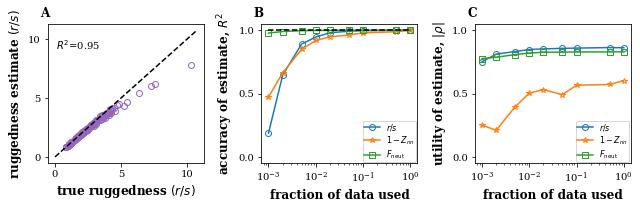

In [12]:
destfolder='/Users/ashish/Dropbox/research/ecology/Figures/Fig_estimating_ruggedness/'
########################### for CR model ############################
fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled_AGG/"
parameter_list=OrderedDict([ ('SM',[16] ), ('mean_c', "1 to param1{'LB' : 1}")])
_,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
folder_suffix='SM'


if not os.path.exists(destfolder): os.makedirs(destfolder)  
ctr=0
for agg_filename in glob.glob(fold_agg+'AggAnalysis_*.dat'):
        ctr+=1
assert ctr==1, print ('number of files that matched was',ctr,'instead')
agg_data=pickle.load(open(agg_filename, 'rb'))

 
color_list=create_color_list(scheme_name='sns_tab10')
fig = plt.figure(figsize=(9,3.)) 

#######################
ax1 = fig.add_subplot(1,3,1) 
fraction_chosen=0.01
Ylabel=r'ruggedness estimate $(r/s)$'
Xlabel=r'true ruggedness $(r/s)$'
# community_function='Species 2'
community_function='Shannon Diversity'
X_key=': '+community_function+': r/s'
estFrac_key=': '+community_function+': est-rs_frac_data_list'
est_key=': '+community_function+': est-rs_estimate_list'

TrueValues,EstValues, EstStdErr=get_X_and_est_from_AGGdict(agg_data, parameter_list, df_keyname_prefix_list, X_key, estFrac_key, est_key, fraction_chosen,avg_the_estimate=True)
temp_copy=TrueValues[:]
TrueValues,EstValues=remove_Nones(TrueValues,EstValues)
_,EstStdErr=remove_Nones(temp_copy,EstStdErr)
R2=r2_score(TrueValues,EstValues)
ax1.plot(TrueValues,EstValues,'o',markerfacecolor='None',markeredgecolor=color_list[4])
# ax1.plot([np.min(TrueValues),np.max(TrueValues)],[np.min(TrueValues),np.max(TrueValues)] ,'k--')
ax1.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax1.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax1.text(-0.05,1.05,'A',fontweight="bold",transform=ax1.transAxes,fontsize=fontSize)
ax1.text(0.05,0.9, r'$R^2$='+'{:.2f}'.format(R2),horizontalalignment='left', verticalalignment='top', transform=ax1.transAxes ) 
ax1.set_yticks([0,5,10])
ax1.set_xticks([0,5,10])
ax1.plot(ax1.get_xlim(),ax1.get_xlim(),'k--')

#######################
ax2 = fig.add_subplot(1,3,2) 
fraction_list=np.array([0.001, 0.002, 0.005, 0.01,  0.02,  0.05,  0.1,   0.25,  0.5, 1. ])## 1 is manually inserted.
###r/s
R2_list=[]
idx_list=[]
Ylabel=r'accuracy of estimate, $R^2$'
Xlabel=r'fraction of data used'

X_key=': '+community_function+': r/s'
estFrac_key=': '+community_function+': est-rs_frac_data_list'
est_key=': '+community_function+': est-rs_estimate_list'

for idx, fraction_chosen in enumerate(fraction_list[:-1]): ## 1 is manually inserted
    TrueValues,EstValues, EstStdErr=get_X_and_est_from_AGGdict(agg_data, parameter_list, df_keyname_prefix_list, X_key, estFrac_key, est_key, fraction_chosen,avg_the_estimate=True)
    TrueValues,EstValues=remove_Nones(TrueValues,EstValues)    
    if len(TrueValues)>1:
        try: 
            r2_score(TrueValues,EstValues)
            if r2_score(TrueValues,EstValues)>0:
                R2_list.append(r2_score(TrueValues,EstValues))   
                idx_list.append(idx)
            else:
                print ('negative R2 at frac=',fraction_chosen, ' for ', X_key)
        except: 
            print ('r2 score returned NAN at frac=',fraction_chosen, ' for ', X_key)
            r2_score(TrueValues,EstValues)
idx_list.append(len(fraction_list)-1) ## the 1. data point which we manually insert
R2_list.append(1.)
ax2.plot(fraction_list[idx_list],R2_list,'o', color=color_list[0], markerfacecolor='None', linestyle='-',label=r'$r/s$')

###nncorrelation
R2_list=[]
idx_list=[]
X_key=': '+community_function+': nn_correlation'
estFrac_key=': '+community_function+': est-nnCorr_frac_data_list'
est_key=': '+community_function+': est-nnCorr_estimate_list'
for idx, fraction_chosen in enumerate(fraction_list[:-1]):
    TrueValues,EstValues, EstStdErr=get_X_and_est_from_AGGdict(agg_data, parameter_list, df_keyname_prefix_list, X_key, estFrac_key, est_key, fraction_chosen,avg_the_estimate=True)
    TrueValues,EstValues=remove_Nones(TrueValues,EstValues)   
    if len(TrueValues)>1:
        try: 
            r2_score(TrueValues,EstValues)
            if r2_score(TrueValues,EstValues)>0:
                R2_list.append(r2_score(TrueValues,EstValues))   
                idx_list.append(idx)
            else:
                print ('negative R2 at frac=',fraction_chosen, ' for ', X_key)
        except: 
            print ('r2 score returned NAN at frac=',fraction_chosen, ' for ', X_key)
            r2_score(TrueValues,EstValues)
idx_list.append(len(fraction_list)-1) ## the 1. data point which we manually insert
R2_list.append(1.)
ax2.plot(fraction_list[idx_list],R2_list,'*', color=color_list[1], markerfacecolor='None', linestyle='-',label=r'$1-Z_{nn}$')


##Fneutral est-FNeutral
R2_list=[]
idx_list=[]
X_key=': '+community_function+': f_neutral_links'
estFrac_key=': '+community_function+': est-FNeutral_frac_data_list'
est_key=': '+community_function+': est-FNeutral_estimate_list'
for idx, fraction_chosen in enumerate(fraction_list[:-1]):
    TrueValues,EstValues, EstStdErr=get_X_and_est_from_AGGdict(agg_data, parameter_list, df_keyname_prefix_list, X_key, estFrac_key, est_key, fraction_chosen,avg_the_estimate=True)
    TrueValues,EstValues=remove_Nones(TrueValues,EstValues)   
    if len(TrueValues)>1:
        try: 
            r2_score(TrueValues,EstValues)
            if r2_score(TrueValues,EstValues)>0:
                R2_list.append(r2_score(TrueValues,EstValues))   
                idx_list.append(idx)
            else:
                print ('negative R2 at frac=',fraction_chosen, ' for ', X_key)
        except: 
            print ('r2 score returned NAN at frac=',fraction_chosen, ' for ', X_key)
            r2_score(TrueValues,EstValues)
idx_list.append(len(fraction_list)-1) ## the 1. data point which we manually insert
R2_list.append(1.)
ax2.plot(fraction_list[idx_list],R2_list,'s', color=color_list[2], markerfacecolor='None', linestyle='-',label=r'$F_{\mathrm{neut}}$')

ax2.plot([np.min(fraction_list),1],[1,1] ,'k--')    
ax2.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax2.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax2.set_ylim(-0.05,1.05)
# ax2.set_xlim(4e-3,2.)
ax2.set_xscale('log')
ax2.set_yticks([0,0.5,1.])
ax2.text(-0.05,1.05,'B',fontweight="bold",transform=ax2.transAxes,fontsize=fontSize)
ax2.legend(loc=4,borderpad=0.1, labelspacing=.2, borderaxespad=.2)   

######### panel C
ax3 = fig.add_subplot(1,3,3) 
Ylabel=r'utility of estimate, $|\rho|$'
Xlabel=r'fraction of data used'
##### r/s

Y_key=': '+community_function+': mean_relative_optimum_Greediest'
estFrac_key=': '+community_function+': est-rs_frac_data_list'
est_key=': '+community_function+': est-rs_estimate_list'
estTrue_key=': '+community_function+': est-rs_true'

SpearmanR_list=[]
idx_list=[]
for idx, fraction_chosen in enumerate(fraction_list[:-1]):
    ##get Ykey (search success) and estimated ruggedness
    SearchValues,EstValues, EstStdErr=get_X_and_est_from_AGGdict(agg_data, parameter_list, df_keyname_prefix_list, Y_key, estFrac_key, est_key, fraction_chosen)    
    SearchValues,EstValues=remove_Nones(SearchValues,EstValues)
    if len(SearchValues)>1:   
        idx_list.append(idx)
        SpearmanR_list.append(spearmanr(SearchValues,EstValues).correlation )  
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,estTrue_key,Y_key) 
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
idx_list.append(len(fraction_list)-1) ## the 1. data point which we manually insert
SpearmanR_list.append(spearmanr(Xvalues, Yvalues).correlation)
ax3.plot(fraction_list[idx_list],-1*np.array(SpearmanR_list),'o', color=color_list[0], markerfacecolor='None', linestyle='-',label=r'$r/s$')
## Znn
Y_key=': '+community_function+': mean_relative_optimum_Greediest'
estTrue_key=': '+community_function+': est-nnCorr_true'
estFrac_key=': '+community_function+': est-nnCorr_frac_data_list'
est_key=': '+community_function+': est-nnCorr_estimate_list'
SpearmanR_list=[]
idx_list=[]
for idx, fraction_chosen in enumerate(fraction_list[:-1]):
    ##get Ykey (search success) and estimated ruggedness
    SearchValues,EstValues, EstStdErr=get_X_and_est_from_AGGdict(agg_data, parameter_list, df_keyname_prefix_list, Y_key, estFrac_key, est_key, fraction_chosen)    
    SearchValues,EstValues=remove_Nones(SearchValues,EstValues)  

    
    if len(SearchValues)>1:   
        idx_list.append(idx)
        SpearmanR_list.append(spearmanr(SearchValues,1.-EstValues).correlation )  
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,estTrue_key,Y_key) 
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
idx_list.append(len(fraction_list)-1) ## the 1. data point which we manually insert
SpearmanR_list.append(spearmanr(Xvalues, 1-Yvalues).correlation)
# SpearmanR_list=np.array(SpearmanR_list)/SpearmanR_list[-1]
ax3.plot(fraction_list[idx_list],-1*np.array(SpearmanR_list),'*', color=color_list[1], markerfacecolor='None', linestyle='-',label=r'$1-Z_{nn}$')



Y_key=': '+community_function+': mean_relative_optimum_Greediest'
estFrac_key=': '+community_function+': est-FNeutral_frac_data_list'
est_key=': '+community_function+': est-FNeutral_estimate_list'
estTrue_key=': '+community_function+': est-FNeutral_true'

SpearmanR_list=[]
idx_list=[]
for idx, fraction_chosen in enumerate(fraction_list[:-1]):
    ##get Ykey (search success) and estimated ruggedness
    SearchValues,EstValues, EstStdErr=get_X_and_est_from_AGGdict(agg_data, parameter_list, df_keyname_prefix_list, Y_key, estFrac_key, est_key, fraction_chosen)    
    SearchValues,EstValues=remove_Nones(SearchValues,EstValues)
    if len(SearchValues)>1:   
        idx_list.append(idx)
        SpearmanR_list.append(spearmanr(SearchValues,EstValues).correlation )  
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,estTrue_key,Y_key) 
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
idx_list.append(len(fraction_list)-1) ## the 1. data point which we manually insert
SpearmanR_list.append(spearmanr(Xvalues, Yvalues).correlation)
# SpearmanR_list=np.array(SpearmanR_list)/SpearmanR_list[-1]
ax3.plot(fraction_list[idx_list],-1*np.array(SpearmanR_list),'s', color=color_list[2], markerfacecolor='None', linestyle='-',label=r'$F_{\mathrm{neut}}$')


ax3.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax3.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax3.set_ylim(-0.05,1.05)
ax3.set_xscale('log')
ax3.set_yticks([0,0.5,1.])
ax3.text(-0.05,1.05,'C',fontweight="bold",transform=ax3.transAxes,fontsize=fontSize)
ax3.legend(loc=4,borderpad=0.1, labelspacing=.2, borderaxespad=.2)   



for ax_temp in [ax1,ax2,ax3]:
    ax_temp.tick_params(labelsize= labelSize)

plt.tight_layout()
fig.patch.set_facecolor('white')
plt.savefig(destfolder+'Estimating_Rugg'+folder_suffix+'-3panel.pdf')


## 2 panel SI, correlation when undersampled/with noise

UB= 17
[0.001 0.002 0.005 0.01  0.02  0.05  0.1   0.5   1.   ] [-0.7506982161425503, -0.8115464763740906, -0.8321856929376886, -0.8480712536173436, -0.8530109539688555, -0.857143485016191, -0.8592954481883058, -0.8633430140457281, -0.8618444038857053]


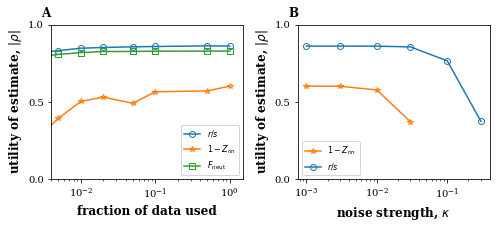

In [6]:
destfolder='/Users/ashish/Dropbox/research/ecology/Figures/Fig_estimating_ruggedness/'
########################### for CR model ############################
fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled_AGG/"
parameter_list=OrderedDict([ ('SM',[16] ), ('mean_c', "1 to param1{'LB' : 1}")])
_,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
folder_suffix='SM'

if not os.path.exists(destfolder): os.makedirs(destfolder)  
ctr=0
for agg_filename in glob.glob(fold_agg+'AggAnalysis_*.dat'):
        ctr+=1
assert ctr==1, print ('number of files that matched was',ctr,'instead')
agg_data=pickle.load(open(agg_filename, 'rb'))

 
color_list=create_color_list(scheme_name='sns_tab10')
fraction_list=np.array([0.001, 0.002, 0.005, 0.01,  0.02,  0.05,  0.1,   0.25,  0.5, 1. ])## 1 is manually inserted.
fig = plt.figure(figsize=(7,3.3)) 

ax1 = fig.add_subplot(1,2,1)
Ylabel='utility of estimate, ' r'$|\rho|$'
Xlabel=r'fraction of data used'
community_function='Shannon Diversity'
community_function_suffix='Div'
Y_key=': '+community_function+': mean_relative_optimum_Greediest'
estFrac_key=': '+community_function+': est-rs_frac_data_list'
est_key=': '+community_function+': est-rs_estimate_list'
estTrue_key=': '+community_function+': est-rs_true'
SpearmanR_list=[]
idx_list=[]
for idx, fraction_chosen in enumerate(fraction_list[:-1]):
    SearchValues,EstValues, EstStdErr=get_X_and_est_from_AGGdict(agg_data, parameter_list, df_keyname_prefix_list, Y_key, estFrac_key, est_key, fraction_chosen)    
    SearchValues,EstValues=remove_Nones(SearchValues,EstValues)
    if len(SearchValues)>1:   
        idx_list.append(idx)
        SpearmanR_list.append(spearmanr(SearchValues,EstValues).correlation )  
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,estTrue_key,Y_key) 
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
idx_list.append(len(fraction_list)-1) ## the 1. data point which we manually insert
SpearmanR_list.append(spearmanr(Xvalues, Yvalues).correlation)

ax1.plot(fraction_list[idx_list],np.abs(SpearmanR_list),'o', color=color_list[0], markerfacecolor='None', linestyle='-',label='$r/s$')
print(fraction_list[idx_list],SpearmanR_list)

community_function='Shannon Diversity'
community_function_suffix='Div'
# community_function='Species 2,3 coex_product FullLandscape'
# community_function_suffix=r'$N_i N_j$'
Y_key=': '+community_function+': mean_relative_optimum_Greediest'
estFrac_key=': '+community_function+': est-nnCorr_frac_data_list'
est_key=': '+community_function+': est-nnCorr_estimate_list'
estTrue_key=': '+community_function+': est-nnCorr_true'
SpearmanR_list=[]
idx_list=[]
for idx, fraction_chosen in enumerate(fraction_list[:-1]):
    SearchValues,EstValues, EstStdErr=get_X_and_est_from_AGGdict(agg_data, parameter_list, df_keyname_prefix_list, Y_key, estFrac_key, est_key, fraction_chosen)    
    SearchValues,EstValues=remove_Nones(SearchValues,EstValues)
#     EstValues=EstValues
    if len(SearchValues)>1:   
        idx_list.append(idx)
        SpearmanR_list.append(spearmanr(SearchValues,1.-EstValues).correlation )       

Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,estTrue_key,Y_key) 
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
idx_list.append(len(fraction_list)-1) ## the 1. data point which we manually insert
SpearmanR_list.append(spearmanr(Xvalues, 1.-Yvalues).correlation)   
ax1.plot(fraction_list[idx_list],np.abs(SpearmanR_list),'*', color=color_list[1], markerfacecolor='None', linestyle='-',label='$1-Z_{nn}$')

community_function='Shannon Diversity'
community_function_suffix='Div'
# community_function='Species 2,3 coex_product FullLandscape'
# community_function_suffix=r'$N_i N_j$'

Y_key=': '+community_function+': mean_relative_optimum_Greediest'
estFrac_key=': '+community_function+': est-FNeutral_frac_data_list'
est_key=': '+community_function+': est-FNeutral_estimate_list'
estTrue_key=': '+community_function+': est-FNeutral_true'
SpearmanR_list=[]
idx_list=[]
for idx, fraction_chosen in enumerate(fraction_list[:-1]):
    SearchValues,EstValues, EstStdErr=get_X_and_est_from_AGGdict(agg_data, parameter_list, df_keyname_prefix_list, Y_key, estFrac_key, est_key, fraction_chosen)    
    SearchValues,EstValues=remove_Nones(SearchValues,EstValues)
#     EstValues=EstValues
    if len(SearchValues)>1:   
        idx_list.append(idx)
        SpearmanR_list.append(spearmanr(SearchValues,EstValues).correlation )       

Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,estTrue_key,Y_key) 
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
idx_list.append(len(fraction_list)-1) ## the 1. data point which we manually insert
SpearmanR_list.append(spearmanr(Xvalues, Yvalues).correlation)   
ax1.plot(fraction_list[idx_list],np.abs(SpearmanR_list),'s', color=color_list[2], markerfacecolor='None', linestyle='-',label=r'$F_{\mathrm{neut}}$')    

ax1.set_ylim(0,1)
ax1.set_xlim(4e-3,1.5)
ax1.set_yticks([0,0.5,1.])
ax1.set_xscale('log')
ax1.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax1.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax1.text(-0.05,1.05,'A',fontweight="bold",transform=ax1.transAxes,fontsize=fontSize)   
ax1.legend(loc=4)    
# ax1.legend(loc=1,ncol=2,borderpad=0.2, columnspacing=.5, borderaxespad=.2)    
       

# true_community_function='Species 2,3 coex_product FullLandscape'
true_community_function='Shannon Diversity'
Xlabel=r'noise strength, $\kappa$'
Ylabel='utility of estimate, ' r'$|\rho|$'  
ax2 = fig.add_subplot(1,2,2)     
# noise_strength_list=[0.001,0.005, 0.01, 0.02, 0.05, 0.1]
noise_strength_list=[0.001,0.003, 0.01, 0.03, 0.1, 0.3] 
# noise_strength_list=[0.001,0.003, 0.01, 0.03, 0.1, 0.3, 1., 3.] 
Znn_corr=[]
rs_corr=[]
for noise_strength in noise_strength_list:
    noisy_community_function=true_community_function+'-MULTnoise_'+"{:.2e}".format(noise_strength)
    X_key=': '+noisy_community_function+': nn_correlation' 
    Y_key=': '+true_community_function+': mean_relative_optimum_Greediest'
    Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
    Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues)     
    Znn_corr.append(spearmanr(1.-Xvalues, Yvalues).correlation)
    
    noisy_community_function=true_community_function+'-ADDnoise_'+"{:.2e}".format(noise_strength)
    X_key=': '+noisy_community_function+': r/s' 
    Y_key=': '+true_community_function+': mean_relative_optimum_Greediest'
    Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
    Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues)     
    rs_corr.append(spearmanr(Xvalues, Yvalues).correlation)   

ax2.plot(noise_strength_list[:-2],np.abs(Znn_corr[:-2]),'*', color=color_list[1],linestyle='-',markerfacecolor='None',label=r'$1-Z_{nn}$')    
ax2.plot(noise_strength_list,np.abs(rs_corr),'o', color=color_list[0],linestyle='-',markerfacecolor='None',label=r'$r/s$')       
ax2.legend(loc=3)    
ax2.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax2.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax2.set_xscale('log')
ax2.set_ylim(0,1)
ax2.set_yticks([0,0.5,1.])
ax2.text(-0.05,1.05,'B',fontweight="bold",transform=ax2.transAxes,fontsize=fontSize)

for ax_temp in [ax1,ax2]:
    ax_temp.tick_params(labelsize= labelSize)

plt.tight_layout()
plt.savefig(destfolder+'Estimating_Rugg_'+folder_suffix+'-sampling_and_measurementNoise_SI.pdf')


## SI 2 panel only noise

UB= 17
[-0.6023768279781851, -0.6017630277269148, -0.578032836150953, -0.371710986534211, 0.30013367370051347, 0.4294375084949708, 0.46774801964347085] [-0.8618312196320981, -0.8619030005684042, -0.8618634478075824, -0.8567010800618148, -0.7737149931066536, -0.3918023241145749, -0.19104129968595263]
[-0.970357694699825, -0.970357694699825, -0.970357694699825, -0.9702832632856453, -0.9702832632856453, -0.9701266471849751, -0.8174119931413881, 0.43707832126339036] [-0.9702165851437758, -0.9702165851437758, -0.9702165851437758, -0.9702165851437758, -0.9703483907730527, -0.9694831255832115, -0.9344445373580289, -0.6085543436436956]


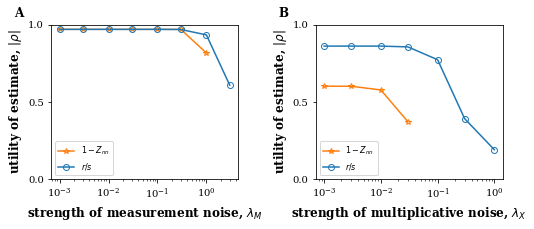

In [29]:
destfolder='/Users/ashish/Dropbox/research/ecology/Figures/Fig_estimating_ruggedness/'
########################### for CR model ############################
fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled_AGG/"
parameter_list=OrderedDict([ ('SM',[16] ), ('mean_c', "1 to param1{'LB' : 1}")])
_,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
folder_suffix='SM'

if not os.path.exists(destfolder): os.makedirs(destfolder)  
ctr=0
for agg_filename in glob.glob(fold_agg+'AggAnalysis_*.dat'):
        ctr+=1
assert ctr==1, print ('number of files that matched was',ctr,'instead')
agg_data=pickle.load(open(agg_filename, 'rb'))

 
color_list=create_color_list(scheme_name='sns_tab10')
fraction_list=np.array([0.001, 0.002, 0.005, 0.01,  0.02,  0.05,  0.1,   0.25,  0.5, 1. ])## 1 is manually inserted.



fig = plt.figure(figsize=(7.5,3.3)) 

ax1 = fig.add_subplot(1,2,2)


true_community_function='Shannon Diversity'
Xlabel=r'strength of multiplicative noise, $\lambda_X$'
Ylabel='utility of estimate, ' r'$|\rho|$'  
   
# noise_strength_list=[0.001,0.005, 0.01, 0.02, 0.05, 0.1]
# noise_strength_list=[0.001,0.003, 0.01, 0.03, 0.1, 0.3] 
noise_strength_list=[0.001,0.003, 0.01, 0.03, 0.1, 0.3, 1.] 
Znn_corr=[]
rs_corr=[]
for noise_strength in noise_strength_list:
    noisy_community_function=true_community_function+'-MULTnoise_'+"{:.2e}".format(noise_strength)
    X_key=': '+noisy_community_function+': nn_correlation' 
    Y_key=': '+true_community_function+': mean_relative_optimum_Greediest'
    Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
    Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues)     
    Znn_corr.append(spearmanr(1.-Xvalues, Yvalues).correlation)
    
    X_key=': '+noisy_community_function+': r/s' 
    Y_key=': '+true_community_function+': mean_relative_optimum_Greediest'
    Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
    Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues)     
    rs_corr.append(spearmanr(Xvalues, Yvalues).correlation) 
    
ax1.plot(noise_strength_list[:-3],-1*np.array(Znn_corr[:-3]),'*', color=color_list[1],linestyle='-',markerfacecolor='None',label=r'$1-Z_{nn}$')    
ax1.plot(noise_strength_list,-1*np.array(rs_corr),'o', color=color_list[0],linestyle='-',markerfacecolor='None',label=r'$r/s$')       
ax1.legend(loc=3)    
ax1.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax1.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax1.set_xscale('log')
ax1.set_ylim(0,1)
ax1.set_yticks([0,0.5,1.])
ax1.text(-0.2,1.05,'B',fontweight="bold",transform=ax1.transAxes,fontsize=fontSize)    

print (Znn_corr,rs_corr)
ax2 = fig.add_subplot(1,2,1)  
true_community_function='Species 2,3 coex_product FullLandscape'
noise_strength_list=[0.001,0.003, 0.01, 0.03, 0.1, 0.3, 1., 3.] ### for variation
Znn_corr=[]
rs_corr=[]
Xlabel=r'strength of measurement noise, $\lambda_{M}$'
for noise_strength in noise_strength_list:    
    noisy_community_function=true_community_function+'-ADDnoise_'+"{:.2e}".format(noise_strength)
    X_key=': '+noisy_community_function+': r/s' 
    Y_key=': '+true_community_function+': mean_relative_optimum_Greediest'
    Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
    Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues)     
    rs_corr.append(spearmanr(Xvalues, Yvalues).correlation)   
    
    X_key=': '+noisy_community_function+': nn_correlation' 
    Y_key=': '+true_community_function+': mean_relative_optimum_Greediest'
    Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
    Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues)     
    Znn_corr.append(spearmanr(1.-Xvalues, Yvalues).correlation)
    

ax2.plot(noise_strength_list[:-1],-1*np.array(Znn_corr[:-1]),'*', color=color_list[1],linestyle='-',markerfacecolor='None',label=r'$1-Z_{nn}$')    
ax2.plot(noise_strength_list,-1*np.array(rs_corr),'o', color=color_list[0],linestyle='-',markerfacecolor='None',label=r'$r/s$')       
ax2.legend(loc=3)    
ax2.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax2.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax2.set_xscale('log')
ax2.set_ylim(0,1)
ax2.set_yticks([0,0.5,1.])
ax2.text(-0.2,1.05,'A',fontweight="bold",transform=ax2.transAxes,fontsize=fontSize)
print (Znn_corr,rs_corr)
for ax_temp in [ax1,ax2]:
    ax_temp.tick_params(labelsize= labelSize)

plt.tight_layout()
plt.savefig(destfolder+'Estimating_Rugg_'+folder_suffix+'-Noise_SI.pdf')
plt.show()

## 4 panels version, with noise

In [ ]:
destfolder='/Users/ashish/Dropbox/research/ecology/Figures/Fig_estimating_ruggedness/'
########################### for CR model ############################
fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled_AGG/"
parameter_list=OrderedDict([ ('SM',[16] ), ('mean_c', "1 to param1{'LB' : 1}")])
_,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
folder_suffix='SM'



if not os.path.exists(destfolder): os.makedirs(destfolder)  
ctr=0
for agg_filename in glob.glob(fold_agg+'AggAnalysis_*.dat'):
        ctr+=1
assert ctr==1, print ('number of files that matched was',ctr,'instead')
agg_data=pickle.load(open(agg_filename, 'rb'))

 
color_list=create_color_list(scheme_name='sns_tab10')
fig = plt.figure(figsize=(6,6)) 

#######################
ax1 = fig.add_subplot(2,2,1) 
fraction_chosen=0.01
Ylabel=r'ruggedness estimate $(r/s)$'
Xlabel=r'true ruggedness $(r/s)$'
# community_function='Species 2'
community_function='Shannon Diversity'
X_key=': '+community_function+': r/s'
estFrac_key=': '+community_function+': est-rs_frac_data_list'
est_key=': '+community_function+': est-rs_estimate_list'

TrueValues,EstValues, EstStdErr=get_X_and_est_from_AGGdict(agg_data, parameter_list, df_keyname_prefix_list, X_key, estFrac_key, est_key, fraction_chosen,avg_the_estimate=True)
temp_copy=TrueValues[:]
TrueValues,EstValues=remove_Nones(TrueValues,EstValues)
_,EstStdErr=remove_Nones(temp_copy,EstStdErr)
R2=r2_score(TrueValues,EstValues)
ax1.plot(TrueValues,EstValues,'o',markerfacecolor='None',markeredgecolor=color_list[4])
# ax1.plot([np.min(TrueValues),np.max(TrueValues)],[np.min(TrueValues),np.max(TrueValues)] ,'k--')
ax1.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax1.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax1.text(-0.18,1.05,'A',fontweight="bold",transform=ax1.transAxes,fontsize=fontSize)
ax1.text(0.05,0.9, r'$R^2$='+'{:.2f}'.format(R2),horizontalalignment='left', verticalalignment='top', transform=ax1.transAxes ) 
ax1.set_yticks([0,5,10])
ax1.set_xticks([0,5,10])
ax1.plot(ax1.get_xlim(),ax1.get_xlim(),'k--')

#######################
ax2 = fig.add_subplot(2,2,2) 


fraction_list=np.array([0.001, 0.002, 0.005, 0.01,  0.02,  0.05,  0.1,   0.25,  0.5, 1. ])## 1 is manually inserted.
R2_list=[]
idx_list=[]
Ylabel=r'accuracy of estimate, $R^2$'
Xlabel=r'fraction of data used'

X_key=': '+community_function+': r/s'
estFrac_key=': '+community_function+': est-rs_frac_data_list'
est_key=': '+community_function+': est-rs_estimate_list'

for idx, fraction_chosen in enumerate(fraction_list[:-1]): ## 1 is manually inserted
    TrueValues,EstValues, EstStdErr=get_X_and_est_from_AGGdict(agg_data, parameter_list, df_keyname_prefix_list, X_key, estFrac_key, est_key, fraction_chosen,avg_the_estimate=True)
    TrueValues,EstValues=remove_Nones(TrueValues,EstValues)    
    if len(TrueValues)>1:
        try: 
            r2_score(TrueValues,EstValues)
            if r2_score(TrueValues,EstValues)>0:
                R2_list.append(r2_score(TrueValues,EstValues))   
                idx_list.append(idx)
            else:
                print ('negative R2 at frac=',fraction_chosen, ' for ', X_key)
        except: 
            print ('r2 score returned NAN at frac=',fraction_chosen, ' for ', X_key)
            r2_score(TrueValues,EstValues)
idx_list.append(len(fraction_list)-1) ## the 1. data point which we manually insert
R2_list.append(1.)

ax2.plot(fraction_list[idx_list],R2_list,'o', color=color_list[0], markerfacecolor='None', linestyle='-',label=r'$r/s $')


R2_list=[]
idx_list=[]

X_key=': '+community_function+': nn_correlation'
estFrac_key=': '+community_function+': est-nnCorr_frac_data_list'
est_key=': '+community_function+': est-nnCorr_estimate_list'

for idx, fraction_chosen in enumerate(fraction_list[:-1]):
    TrueValues,EstValues, EstStdErr=get_X_and_est_from_AGGdict(agg_data, parameter_list, df_keyname_prefix_list, X_key, estFrac_key, est_key, fraction_chosen,avg_the_estimate=True)
    TrueValues,EstValues=remove_Nones(TrueValues,EstValues)   
    if len(TrueValues)>1:
        try: 
            r2_score(TrueValues,EstValues)
            if r2_score(TrueValues,EstValues)>0:
                R2_list.append(r2_score(TrueValues,EstValues))   
                idx_list.append(idx)
            else:
                print ('negative R2 at frac=',fraction_chosen, ' for ', X_key)
        except: 
            print ('r2 score returned NAN at frac=',fraction_chosen, ' for ', X_key)
            r2_score(TrueValues,EstValues)
idx_list.append(len(fraction_list)-1) ## the 1. data point which we manually insert
R2_list.append(1.)
ax2.plot(fraction_list[idx_list],R2_list,'*', color=color_list[1], markerfacecolor='None', linestyle='-',label=r'$1-Z_{nn}$')


ax2.plot([np.min(fraction_list),1],[1,1] ,'k--')    
ax2.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax2.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax2.set_ylim(-0.05,1.05)
# ax2.set_xlim(4e-3,2.)
ax2.set_xscale('log')
ax2.set_yticks([0,0.5,1.])
ax2.text(-0.18,1.05,'B',fontweight="bold",transform=ax2.transAxes,fontsize=fontSize)
ax2.legend(loc=4,borderpad=0.1, labelspacing=.2, borderaxespad=.2)   

ax3 = fig.add_subplot(2,2,3)
Ylabel='utility of estimate, ' r'$|\rho|$'
Xlabel=r'fraction of data used'

community_function='Shannon Diversity'
community_function_suffix='Div'
Y_key=': '+community_function+': mean_relative_optimum_Greediest'
estFrac_key=': '+community_function+': est-rs_frac_data_list'
est_key=': '+community_function+': est-rs_estimate_list'
estTrue_key=': '+community_function+': est-rs_true'

SpearmanR_list=[]
idx_list=[]
for idx, fraction_chosen in enumerate(fraction_list[:-1]):
    SearchValues,EstValues, EstStdErr=get_X_and_est_from_AGGdict(agg_data, parameter_list, df_keyname_prefix_list, Y_key, estFrac_key, est_key, fraction_chosen)    
    SearchValues,EstValues=remove_Nones(SearchValues,EstValues)
    if len(SearchValues)>1:   
        idx_list.append(idx)
        SpearmanR_list.append(spearmanr(SearchValues,EstValues).correlation )  
Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,estTrue_key,Y_key) 
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
idx_list.append(len(fraction_list)-1) ## the 1. data point which we manually insert
SpearmanR_list.append(spearmanr(Xvalues, Yvalues).correlation)

ax3.plot(fraction_list[idx_list],np.abs(SpearmanR_list),'o', color=color_list[0], markerfacecolor='None', linestyle='-',label='$r/s$')
print(fraction_list[idx_list],SpearmanR_list)

community_function='Shannon Diversity'
community_function_suffix='Div'
# community_function='Species 2,3 coex_product FullLandscape'
# community_function_suffix=r'$N_i N_j$'
Y_key=': '+community_function+': mean_relative_optimum_Greediest'
estFrac_key=': '+community_function+': est-nnCorr_frac_data_list'
est_key=': '+community_function+': est-nnCorr_estimate_list'
estTrue_key=': '+community_function+': est-nnCorr_true'
SpearmanR_list=[]
idx_list=[]
for idx, fraction_chosen in enumerate(fraction_list[:-1]):
    SearchValues,EstValues, EstStdErr=get_X_and_est_from_AGGdict(agg_data, parameter_list, df_keyname_prefix_list, Y_key, estFrac_key, est_key, fraction_chosen)    
    SearchValues,EstValues=remove_Nones(SearchValues,EstValues)
#     EstValues=EstValues
    if len(SearchValues)>1:   
        idx_list.append(idx)
        SpearmanR_list.append(spearmanr(SearchValues,1.-EstValues).correlation )       

Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,estTrue_key,Y_key) 
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
idx_list.append(len(fraction_list)-1) ## the 1. data point which we manually insert
SpearmanR_list.append(spearmanr(Xvalues, 1.-Yvalues).correlation)   
ax3.plot(fraction_list[idx_list],np.abs(SpearmanR_list),'*', color=color_list[1], markerfacecolor='None', linestyle='-',label='$1-Z_{nn}$')    


ax3.set_ylim(0,1)
ax3.set_xlim(4e-3,1.5)
ax3.set_yticks([0,0.5,1.])
ax3.set_xscale('log')
ax3.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax3.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax3.text(-0.18,1.05,'C',fontweight="bold",transform=ax3.transAxes,fontsize=fontSize)   
ax3.legend(loc=4)    

# ax3.legend(loc=1,ncol=2,borderpad=0.2, columnspacing=.5, borderaxespad=.2)    
       




# true_community_function='Species 2,3 coex_product FullLandscape'
true_community_function='Shannon Diversity'


Xlabel=r'noise strength, $\kappa$'
Ylabel='utility of estimate, ' r'$|\rho|$'


    
ax4 = fig.add_subplot(2,2,4)     
# noise_strength_list=[0.001,0.005, 0.01, 0.02, 0.05, 0.1]
noise_strength_list=[0.001,0.003, 0.01, 0.03, 0.1, 0.3] 
# noise_strength_list=[0.001,0.003, 0.01, 0.03, 0.1, 0.3, 1., 3.] 
Znn_corr=[]
rs_corr=[]
for noise_strength in noise_strength_list:
    noisy_community_function=true_community_function+'-MULTnoise_'+"{:.2e}".format(noise_strength)
    X_key=': '+noisy_community_function+': nn_correlation' 
    Y_key=': '+true_community_function+': mean_relative_optimum_Greediest'
    Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
    Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues)     
    Znn_corr.append(spearmanr(1.-Xvalues, Yvalues).correlation)
    
    noisy_community_function=true_community_function+'-ADDnoise_'+"{:.2e}".format(noise_strength)
    X_key=': '+noisy_community_function+': r/s' 
    Y_key=': '+true_community_function+': mean_relative_optimum_Greediest'
    Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key)  
    Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues)     
    rs_corr.append(spearmanr(Xvalues, Yvalues).correlation)   

ax4.plot(noise_strength_list[:-2],np.abs(Znn_corr[:-2]),'*', color=color_list[1],linestyle='-',markerfacecolor='None',label=r'$1-Z_{nn}$')    
ax4.plot(noise_strength_list,np.abs(rs_corr),'o', color=color_list[0],linestyle='-',markerfacecolor='None',label=r'$r/s$')       
ax4.legend(loc=3)    
ax4.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax4.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax4.set_xscale('log')
ax4.set_ylim(0,1)
ax4.set_yticks([0,0.5,1.])
ax4.text(-0.18,1.05,'D',fontweight="bold",transform=ax4.transAxes,fontsize=fontSize)

for ax_temp in [ax1,ax2,ax3,ax4]:
    ax_temp.tick_params(labelsize= labelSize)

plt.tight_layout()
plt.savefig(destfolder+'Estimating_Rugg_with_Noise_panel-'+folder_suffix+'-DivNoise.pdf')


# Search-ruggedness for crossfeeding model

## 3 panel

dict_keys(['l']) {'l': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}


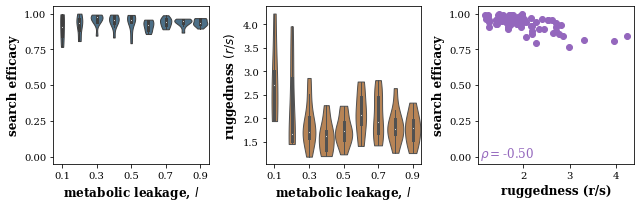

In [42]:
destfolder = '/Users/ashish/Dropbox/research/ecology/Figures/Fig_Search_CFmodel/'
if not os.path.exists(destfolder):
    os.makedirs(destfolder)

color_list=create_color_list(scheme_name='sns_tab10')
# average over data at a given level and return levels and standard error
def calc_avg_and_err_over_levels(value_arr, level_arr):
    unq_lvls = np.asarray(list(set(level_arr)))
    avgs = []
    errs = []
    for lvl in unq_lvls:
        values = value_arr[np.where(level_arr == lvl)]
#         print (lvl,len(values))
        avgs.append(np.mean(values))
        errs.append(np.std(values)/np.sqrt(len(values)))
    return unq_lvls, np.asarray(avgs), np.asarray(errs)


community_function='Shannon Diversity'
community_function_suffix='ShannonD'
# community_function = 'Species 2'
# community_function_suffix = 'Sp2'
# community_function='Species 2,3 coex_product FullLandscape'
# community_function_suffix = 'Sp23_full'
# community_function='Clark_M3'
# community_function_suffix='Clark'

color_list2 = list(sns.color_palette(palette='tab10'))
fig = plt.figure(figsize=(9, 3))
# ax1, ax2, ax3 = fig.subplots(1, 3, sharey=True)

label = ''
############################ CF l ############################
fold_agg = "/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CF_CfixedxGamma01Special_l_compiled_AGG/"
parameter_name = 'l'
''' l=0 is not included because focal species abundance doesn't make sense for it'''
parameter_list = {parameter_name: [
    0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
_, parameter_list, df_keyname_prefix_list = create_replicate_lists(
    parameter_list, [destfolder], 0, return_dfkeynames=True)
X_key = [': exp_case', 'l']
Xlabel = r'metabolic leakage, $l$'
xticks=np.array([0,2,4,6,8])
xtick_vals=np.array([0.1,0.3,0.5,0.7,0.9])
violin_width = 0.1
folder_suffix = '_CF-l'


ctr = 0
for agg_filename in glob.glob(fold_agg+'AggAnalysis_*.dat'):
    ctr += 1
assert ctr == 1, print('number of files that matched was', ctr, 'instead')
agg_data = pickle.load(open(agg_filename, 'rb'))


ax1 = fig.add_subplot(1, 3, 1)


Ylabel = 'search efficacy'
Y_key = ': '+community_function+': mean_relative_optimum_Greediest'
Xvalues, Yvalues = get_XY_from_AGGdict(
    agg_data, parameter_list, df_keyname_prefix_list, X_key, Y_key)
# Yvalues=replace_Nones_with(Yvalues,value=1.)
Xvalues, Yvalues = remove_Nones(Xvalues, Yvalues)
xlist = list(set(Xvalues))
ylist = []
for xval in list(set(Xvalues)):
    ylist.append(np.ravel(Yvalues[np.where(Xvalues == xval)]).astype(float))
# ax1.violinplot( ylist, xlist, points=100, widths=violin_width, showmeans=True,showextrema=True,  bw_method=1)

xvals = [str(k) for k in Xvalues]
yvals = [float(k) for k in Yvalues]
temp_df = pd.DataFrame.from_dict({'Xvalues': xvals, 'Yvalues': yvals})
sns.violinplot(x=temp_df["Xvalues"], y=temp_df["Yvalues"],
               color=color_list2[0], ax=ax1, cut=0, width=1.,linewidth=1, saturation=.4)

ax1.set_ylim(-0.05, 1.05)
ax1.set_ylabel(Ylabel, fontweight="bold", fontsize=fontSize)
ax1.set_xlabel(Xlabel, fontweight="bold", fontsize=fontSize)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xtick_vals)
# ax1.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
# ax1.set_title(community_function)
ax1.tick_params(labelsize=labelSize)
# ax1.text(-0.2, 1.05, 'A', fontweight="bold",
#          transform=ax1.transAxes, fontsize=fontSize)


ax2 = fig.add_subplot(1, 3, 2)
axiscolor = 'g'  # 'tab:green'
Ylabel = r'ruggedness $(r/s)$'
Y_key = ': '+community_function+': r/s'
Xvalues, Yvalues = get_XY_from_AGGdict(
    agg_data, parameter_list, df_keyname_prefix_list, X_key, Y_key)
# Yvalues=replace_Nones_with(Yvalues,value=1.)
Xvalues, Yvalues = remove_Nones(Xvalues, Yvalues)

xlist = list(set(Xvalues))
ylist = []
for xval in list(set(Xvalues)):
    ylist.append(np.ravel(Yvalues[np.where(Xvalues == xval)]).astype(float))
xvals = [str(k) for k in Xvalues]
yvals = [float(k) for k in Yvalues]
temp_df = pd.DataFrame.from_dict({'Xvalues': xvals, 'Yvalues': yvals})
sns.violinplot(x=temp_df["Xvalues"], y=temp_df["Yvalues"],
               color=color_list2[1], ax=ax2, cut=0, width=1.,linewidth=1, saturation=.4)
ax2.set_ylabel(Ylabel, fontweight="bold", fontsize=fontSize)
ax2.set_xlabel(Xlabel, fontweight="bold", fontsize=fontSize)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xtick_vals)
ax2.tick_params(labelsize=labelSize)
# ax2.text(-0.2, 1.05, 'B', fontweight="bold",
#          transform=ax2.transAxes, fontsize=fontSize)


ax3 = fig.add_subplot(1, 3, 3)
Xlabel = r'ruggedness (r/s)'
X_key = ': '+community_function+': r/s'
Ylabel = 'search efficacy'
Y_key = ': '+community_function+': mean_relative_optimum_Greediest'
Xvalues, Yvalues = get_XY_from_AGGdict(
    agg_data, parameter_list, df_keyname_prefix_list, X_key, Y_key)
# Yvalues = replace_Nones_with(Yvalues, value=1.)
# Xvalues = replace_Nones_with(Xvalues, value=0.)
Xvalues, Yvalues = remove_Nones(Xvalues, Yvalues)
ax3 = plot_SpearmanScatterplot(ax3, Xvalues, Yvalues, text_rho=True, text_loc=[
                               0.01, 0.01], label_name='r/s', color=color_list[4], textcolor=color_list[4])
ax3.set_ylabel(Ylabel, fontweight="bold", fontsize=fontSize)
ax3.set_xlabel(Xlabel, fontweight="bold", fontsize=fontSize)
# if np.min(Yvalues) < 0.5:
ax3.set_ylim(-0.05, 1.05)
# ax3.legend(loc='upper right', bbox_to_anchor=(1.,1.),fontsize=fontSize-2)
ax3.tick_params(labelsize=labelSize)
# ax3.text(-.2, 1.05, 'C', fontweight="bold",
#          transform=ax3.transAxes, fontsize=fontSize)

ax1.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
# ax2.set_yticks([0, 1, 2, 3, 4, 5])
# ax3.set_xticks([0, 1, 2, 3, 4, 5])
ax3.set_yticks([0, 0.25, 0.5, 0.75, 1.0])


for ax_temp in [ax1, ax2, ax3]:
    ax_temp.tick_params(labelsize=labelSize)

fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(destfolder+"Search+Rugg+Corr-CF" +
            community_function_suffix+folder_suffix+"-3panel.pdf")

## 4 panel

dict_keys(['l']) {'l': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}


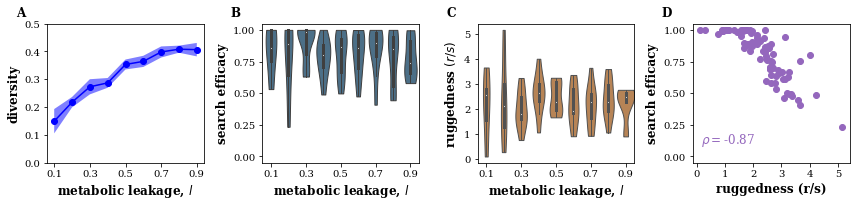

In [32]:
destfolder = '/Users/ashish/Dropbox/research/ecology/Figures/Fig_Search_CFmodel/'
if not os.path.exists(destfolder):
    os.makedirs(destfolder)

color_list=create_color_list(scheme_name='sns_tab10')
# average over data at a given level and return levels and standard error
def calc_avg_and_err_over_levels(value_arr, level_arr):
    unq_lvls = np.asarray(list(set(level_arr)))
    avgs = []
    errs = []
    for lvl in unq_lvls:
        values = value_arr[np.where(level_arr == lvl)]
#         print (lvl,len(values))
        avgs.append(np.mean(values))
        errs.append(np.std(values)/np.sqrt(len(values)))
    return unq_lvls, np.asarray(avgs), np.asarray(errs)


# community_function='Shannon Diversity'
# community_function_suffix='ShannonD'
community_function = 'Species 2'
community_function_suffix = 'Sp2'


color_list2 = list(sns.color_palette(palette='tab10'))
fig = plt.figure(figsize=(12, 3))
# ax2, ax3, ax4 = fig.subplots(1, 3, sharey=True)

label = ''
############################ CF l ############################
fold_agg = "/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CF_CfixedxGamma01Special_l_compiled_AGG/"
parameter_name = 'l'
''' l=0 is not included because focal species abundance doesn't make sense for it'''
parameter_list = {parameter_name: [
    0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
_, parameter_list, df_keyname_prefix_list = create_replicate_lists(
    parameter_list, [destfolder], 0, return_dfkeynames=True)
X_key = [': exp_case', 'l']
Xlabel = r'metabolic leakage, $l$'
xticks=np.array([0,2,4,6,8])
xtick_vals=np.array([0.1,0.3,0.5,0.7,0.9])
violin_width = 0.1
folder_suffix = '_CF-l'


ctr = 0
for agg_filename in glob.glob(fold_agg+'AggAnalysis_*.dat'):
    ctr += 1
assert ctr == 1, print('number of files that matched was', ctr, 'instead')
agg_data = pickle.load(open(agg_filename, 'rb'))



ax1 = fig.add_subplot(1, 4, 1)

Ylabel = 'diversity'
Y_key = ': '+'Shannon Diversity'+': mean'
Xvalues, Yvalues = get_XY_from_AGGdict(
    agg_data, parameter_list, df_keyname_prefix_list, X_key, Y_key)
# Yvalues=replace_Nones_with(Yvalues,value=1.)
Xvalues, Yvalues = remove_Nones(Xvalues, Yvalues)
# xlist = list(set(Xvalues))
# ylist = []
# for xval in list(set(Xvalues)):
#     ylist.append(np.ravel(Yvalues[np.where(Xvalues == xval)]).astype(float))
# xvals = [str(k) for k in Xvalues]
# yvals = [float(k) for k in Yvalues]
# temp_df = pd.DataFrame.from_dict({'Xvalues': xvals, 'Yvalues': yvals})
# # sns.violinplot(x=temp_df["Xvalues"], y=temp_df["Yvalues"],
# #                color=color_list2[0], ax=ax1, cut=0, width=1.,linewidth=1, saturation=.4)



Resources, Avg_rugg, Err_rugg= calc_avg_and_err_over_levels(Yvalues, Xvalues)
idx_sort=np.argsort(Resources)
ax1 = plot_avg_and_err(ax1, Resources[idx_sort], Avg_rugg[idx_sort], Err_rugg[idx_sort])



ax1.set_ylim(0.0, 0.5)
ax1.set_ylabel(Ylabel, fontweight="bold", fontsize=fontSize)
ax1.set_xlabel(Xlabel, fontweight="bold", fontsize=fontSize)
ax1.set_xticks(xtick_vals)
ax1.set_xticklabels(xtick_vals)
ax1.tick_params(labelsize=labelSize)
ax1.text(-0.2, 1.05, 'A', fontweight="bold",
         transform=ax1.transAxes, fontsize=fontSize)


ax2 = fig.add_subplot(1, 4, 2)
Ylabel = 'search efficacy'
Y_key = ': '+community_function+': mean_relative_optimum_Greediest'
Xvalues, Yvalues = get_XY_from_AGGdict(
    agg_data, parameter_list, df_keyname_prefix_list, X_key, Y_key)
# Yvalues=replace_Nones_with(Yvalues,value=1.)
Xvalues, Yvalues = remove_Nones(Xvalues, Yvalues)
xlist = list(set(Xvalues))
ylist = []
for xval in list(set(Xvalues)):
    ylist.append(np.ravel(Yvalues[np.where(Xvalues == xval)]).astype(float))
# ax2.violinplot( ylist, xlist, points=100, widths=violin_width, showmeans=True,showextrema=True,  bw_method=1)
xvals = [str(k) for k in Xvalues]
yvals = [float(k) for k in Yvalues]
temp_df = pd.DataFrame.from_dict({'Xvalues': xvals, 'Yvalues': yvals})
sns.violinplot(x=temp_df["Xvalues"], y=temp_df["Yvalues"],
               color=color_list2[0], ax=ax2, cut=0, width=1.,linewidth=1, saturation=.4)

ax2.set_ylim(-0.05, 1.05)
ax2.set_ylabel(Ylabel, fontweight="bold", fontsize=fontSize)
ax2.set_xlabel(Xlabel, fontweight="bold", fontsize=fontSize)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xtick_vals)
# ax2.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
# ax2.set_title(community_function)
ax2.tick_params(labelsize=labelSize)
ax2.text(-0.2, 1.05, 'B', fontweight="bold",
         transform=ax2.transAxes, fontsize=fontSize)


ax3 = fig.add_subplot(1, 4, 3)
axiscolor = 'g'  # 'tab:green'
Ylabel = r'ruggedness $(r/s)$'
Y_key = ': '+community_function+': r/s'
Xvalues, Yvalues = get_XY_from_AGGdict(
    agg_data, parameter_list, df_keyname_prefix_list, X_key, Y_key)
# Yvalues=replace_Nones_with(Yvalues,value=1.)
Xvalues, Yvalues = remove_Nones(Xvalues, Yvalues)

xlist = list(set(Xvalues))
ylist = []
for xval in list(set(Xvalues)):
    ylist.append(np.ravel(Yvalues[np.where(Xvalues == xval)]).astype(float))
xvals = [str(k) for k in Xvalues]
yvals = [float(k) for k in Yvalues]
temp_df = pd.DataFrame.from_dict({'Xvalues': xvals, 'Yvalues': yvals})
sns.violinplot(x=temp_df["Xvalues"], y=temp_df["Yvalues"],
               color=color_list2[1], ax=ax3, cut=0, width=1.,linewidth=1, saturation=.4)
ax3.set_ylabel(Ylabel, fontweight="bold", fontsize=fontSize)
ax3.set_xlabel(Xlabel, fontweight="bold", fontsize=fontSize)
ax3.set_xticks(xticks)
ax3.set_xticklabels(xtick_vals)
ax3.tick_params(labelsize=labelSize)
ax3.text(-0.2, 1.05, 'C', fontweight="bold",
         transform=ax3.transAxes, fontsize=fontSize)


ax4 = fig.add_subplot(1, 4, 4)
Xlabel = r'ruggedness (r/s)'
X_key = ': '+community_function+': r/s'
Ylabel = 'search efficacy'
Y_key = ': '+community_function+': mean_relative_optimum_Greediest'
Xvalues, Yvalues = get_XY_from_AGGdict(
    agg_data, parameter_list, df_keyname_prefix_list, X_key, Y_key)
# Yvalues = replace_Nones_with(Yvalues, value=1.)
# Xvalues = replace_Nones_with(Xvalues, value=0.)
Xvalues, Yvalues = remove_Nones(Xvalues, Yvalues)
ax4 = plot_SpearmanScatterplot(ax4, Xvalues, Yvalues, text_rho=True, text_loc=[
                               0.05, 0.1], label_name='r/s', color=color_list[4], textcolor=color_list[4])
ax4.set_ylabel(Ylabel, fontweight="bold", fontsize=fontSize)
ax4.set_xlabel(Xlabel, fontweight="bold", fontsize=fontSize)
if np.min(Yvalues) < 0.5:
    ax4.set_ylim(-0.05, 1.05)
# ax4.legend(loc='upper right', bbox_to_anchor=(1.,1.),fontsize=fontSize-2)
ax4.tick_params(labelsize=labelSize)
ax4.text(-.2, 1.05, 'D', fontweight="bold",
         transform=ax4.transAxes, fontsize=fontSize)

ax2.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax3.set_yticks([0, 1, 2, 3, 4, 5])
ax4.set_xticks([0, 1, 2, 3, 4, 5])
ax4.set_yticks([0, 0.25, 0.5, 0.75, 1.0])


for ax_temp in [ax2, ax3, ax4]:
    ax_temp.tick_params(labelsize=labelSize)

fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(destfolder+"Search+Rugg+Corr-CF" +
            community_function_suffix+folder_suffix+"-4panel.pdf")

## changing environmental complexity

dict_keys(['Rsupply_constTotR']) {'Rsupply_constTotR': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}


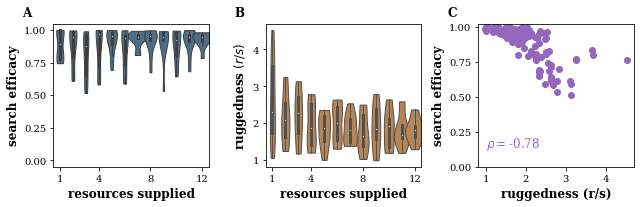

In [35]:
destfolder = '/Users/ashish/Dropbox/research/ecology/Figures/Fig_Search_CFmodel/'
if not os.path.exists(destfolder):
    os.makedirs(destfolder)

color_list=create_color_list(scheme_name='sns_tab10')
# average over data at a given level and return levels and standard error
def calc_avg_and_err_over_levels(value_arr, level_arr):
    unq_lvls = np.asarray(list(set(level_arr)))
    avgs = []
    errs = []
    for lvl in unq_lvls:
        values = value_arr[np.where(level_arr == lvl)]
#         print (lvl,len(values))
        avgs.append(np.mean(values))
        errs.append(np.std(values)/np.sqrt(len(values)))
    return unq_lvls, np.asarray(avgs), np.asarray(errs)


# community_function='Shannon Diversity'
# community_function_suffix='ShannonD'
community_function = 'Species 2'
community_function_suffix = 'Sp2'


color_list2 = list(sns.color_palette(palette='tab10'))
fig = plt.figure(figsize=(9, 3))
# ax1, ax2, ax3 = fig.subplots(1, 3, sharey=True)

label = ''
############################ CF l ############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CF_CfixedxGamma01Special_l_compiled_AGG/"
# parameter_name='l'
# ''' l=0 is not included because focal species abundance doesn't make sense for it'''
# parameter_list={parameter_name:[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]}
# _,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
# X_key=[': exp_case', 'l']
# Xlabel=r'metabolic leakage, $l$'
# xtick_vals=[0.1,0.3, 0.5, 0.7, 0.9]
# violin_width=0.1
# folder_suffix='_CF-l'

############################ CF meanC ############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CF_CfixedxGamma0Special_meanC_compiled_AGG/"
# parameter_name='mean_c'
# parameter_list={parameter_name:[1,2,3,4,5,6,7,8,9,10,11,12]}
# _,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
# X_key=[': exp_case', 'mean_c']
# Xlabel=r'resources consumed'
# xtick_vals=np.array([1, 4, 8, 12])
# violin_width=1.
# folder_suffix = '_CF-meanC'
########################## CF Rsupply_constTotR############################
fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CF_CfixedxGamma_Rsupply_constTotR_compiled_AGG/"
parameter_name='Rsupply_constTotR'
parameter_list={parameter_name:[1,2,3,4,5,6,7,8,9,10,11,12]}
_,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
X_key=[': exp_case', 'R0_params',0]
Xlabel=r'resources supplied'
xtick_vals=np.array([1,4,8,12])
violin_width=1.
folder_suffix='_CF-Rsupply_constTotR'

# ########################### CF Rsupply_constR0############################
# fold_agg = "/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CF_CfixedxGamma_Rsupply_constR0_compiled_AGG/"
# parameter_name = 'Rsupply_constR0'
# parameter_list = {parameter_name: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
# _, parameter_list, df_keyname_prefix_list = create_replicate_lists(
#     parameter_list, [destfolder], 0, return_dfkeynames=True)
# X_key = [': exp_case', 'R0_params', 0]
# Xlabel = r'resources supplied'
# xtick_vals = np.array([1, 4, 8, 12])
# violin_width = 1.
# folder_suffix = '_CF-Rsupply_constR0'


ctr = 0
for agg_filename in glob.glob(fold_agg+'AggAnalysis_*.dat'):
    ctr += 1
assert ctr == 1, print('number of files that matched was', ctr, 'instead')
agg_data = pickle.load(open(agg_filename, 'rb'))


ax1 = fig.add_subplot(1, 3, 1)


Ylabel = 'search efficacy'
Y_key = ': '+community_function+': mean_relative_optimum_Greediest'
Xvalues, Yvalues = get_XY_from_AGGdict(
    agg_data, parameter_list, df_keyname_prefix_list, X_key, Y_key)
# Yvalues=replace_Nones_with(Yvalues,value=1.)
Xvalues, Yvalues = remove_Nones(Xvalues, Yvalues)
xlist = list(set(Xvalues))
ylist = []
for xval in list(set(Xvalues)):
    ylist.append(np.ravel(Yvalues[np.where(Xvalues == xval)]).astype(float))
# ax1.violinplot( ylist, xlist, points=100, widths=violin_width, showmeans=True,showextrema=True,  bw_method=1)

xvals = [int(k) for k in Xvalues]
yvals = [float(k) for k in Yvalues]
temp_df = pd.DataFrame.from_dict({'Xvalues': xvals, 'Yvalues': yvals})
sns.violinplot(x=temp_df["Xvalues"], y=temp_df["Yvalues"],
               color=color_list2[0], ax=ax1, cut=0, width=1.5, linewidth=1, saturation=.4)

ax1.set_ylim(-0.05, 1.05)
ax1.set_ylabel(Ylabel, fontweight="bold", fontsize=fontSize)
ax1.set_xlabel(Xlabel, fontweight="bold", fontsize=fontSize)
ax1.set_xticks(xtick_vals-1)
ax1.set_xticklabels(xtick_vals)
# ax1.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
# ax1.set_title(community_function)
ax1.tick_params(labelsize=labelSize)
ax1.text(-0.2, 1.05, 'A', fontweight="bold",
         transform=ax1.transAxes, fontsize=fontSize)


ax2 = fig.add_subplot(1, 3, 2)
axiscolor = 'g'  # 'tab:green'
Ylabel = r'ruggedness $(r/s)$'
Y_key = ': '+community_function+': r/s'
Xvalues, Yvalues = get_XY_from_AGGdict(
    agg_data, parameter_list, df_keyname_prefix_list, X_key, Y_key)
# Yvalues=replace_Nones_with(Yvalues,value=1.)
Xvalues, Yvalues = remove_Nones(Xvalues, Yvalues)

xlist = list(set(Xvalues))
ylist = []
for xval in list(set(Xvalues)):
    ylist.append(np.ravel(Yvalues[np.where(Xvalues == xval)]).astype(float))
# xvals=[str(k) for k in Xvalues]
xvals = [int(k) for k in Xvalues]
yvals = [float(k) for k in Yvalues]
temp_df = pd.DataFrame.from_dict({'Xvalues': xvals, 'Yvalues': yvals})
sns.violinplot(x=temp_df["Xvalues"], y=temp_df["Yvalues"],
               color=color_list2[1], ax=ax2, cut=0, width=1.5, linewidth=1, saturation=.4)
ax2.set_ylabel(Ylabel, fontweight="bold", fontsize=fontSize)
ax2.set_xlabel(Xlabel, fontweight="bold", fontsize=fontSize)
ax2.set_xticks(xtick_vals-1)
ax2.set_xticklabels(xtick_vals)
ax2.tick_params(labelsize=labelSize)
ax2.text(-0.2, 1.05, 'B', fontweight="bold",
         transform=ax2.transAxes, fontsize=fontSize)


ax3 = fig.add_subplot(1, 3, 3)
Xlabel = r'ruggedness (r/s)'
X_key = ': '+community_function+': r/s'
Ylabel = 'search efficacy'
Y_key = ': '+community_function+': mean_relative_optimum_Greediest'
Xvalues, Yvalues = get_XY_from_AGGdict(
    agg_data, parameter_list, df_keyname_prefix_list, X_key, Y_key)
# Yvalues = replace_Nones_with(Yvalues, value=1.)
# Xvalues = replace_Nones_with(Xvalues, value=0.)
Xvalues, Yvalues = remove_Nones(Xvalues, Yvalues)
ax3 = plot_SpearmanScatterplot(ax3, Xvalues, Yvalues, text_rho=True, text_loc=[
                               0.05, 0.1], label_name='r/s', color=color_list[4], textcolor=color_list[4])
ax3.set_ylabel(Ylabel, fontweight="bold", fontsize=fontSize)
ax3.set_xlabel(Xlabel, fontweight="bold", fontsize=fontSize)
if np.min(Yvalues) < 0.5:
    ax3.set_ylim(-0.05, 1.05)
# ax3.legend(loc='upper right', bbox_to_anchor=(1.,1.),fontsize=fontSize-2)
ax3.tick_params(labelsize=labelSize)
ax3.text(-.2, 1.05, 'C', fontweight="bold",
         transform=ax3.transAxes, fontsize=fontSize)

ax1.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
# ax2.set_yticks([0, 1, 2, 3, 4, 5])
# ax3.set_xticks([0, 1, 2, 3, 4, 5])
ax3.set_yticks([0, 0.25, 0.5, 0.75, 1.0])


for ax_temp in [ax1, ax2, ax3]:
    ax_temp.tick_params(labelsize=labelSize)

fig.patch.set_facecolor('white')
plt.tight_layout()
plt.savefig(destfolder+"Search+Rugg+Corr-CF" +
            community_function_suffix+folder_suffix+"-3panel.pdf")

# Search protocols

## 3 protocols

dict_keys(['l']) {'l': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
90 90 90 90


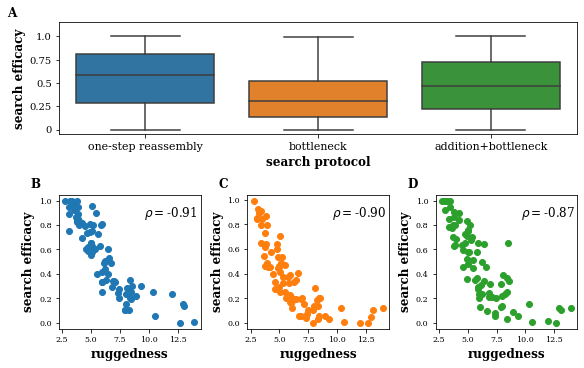

In [7]:
destfolder='/Users/ashish/Dropbox/research/ecology/Figures/Fig_comparing_search_protocols/'

############################ for CR model ############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled_AGG/"
# parameter_list=OrderedDict([ ('SM',[16] ), ('mean_c', "1 to param1{'LB' : 1}")])
# _,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
# folder_suffix='SM'

########################### CF l ############################
fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CF_CfixedxGamma01Special_l_compiled_AGG/"
parameter_name='l'
''' l=0 is not included because focal species abundance doesn't make sense for it'''
parameter_list={parameter_name:[  0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]}
_,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
folder_suffix='CF_l'



if not os.path.exists(destfolder): os.makedirs(destfolder)  
ctr=0
for agg_filename in glob.glob(fold_agg+'AggAnalysis_*.dat'):
        ctr+=1
assert ctr==1, print ('number of files that matched was',ctr,'instead')
agg_data=pickle.load(open(agg_filename, 'rb'))



# community_function='Species 2 product FullLandscape'
# community_suffix='Sp2productFull'
community_function='Species 2,3 coex_product FullLandscape'
community_suffix='Sp23coexFull'

# community_function='Shannon Diversity'
# community_suffix='ShannonD'



import seaborn as sns
fig5 = plt.figure(figsize=(8,5),constrained_layout=True)
widths = [1,1,1]
heights = [1, 1.2]
spec5 = fig5.add_gridspec(ncols=3, nrows=2, width_ratios=widths,
                          height_ratios=heights)

ax0=fig5.add_subplot(spec5[0, :])

Xlabel=r'search protocol'
# Ylabel=r'rel. optimum found'
Ylabel=r'search efficacy'
#######################


X1_key=': '+community_function+': SpeciesAddition_relopt_avg'
X4_key=': '+community_function+': Greediest_relopt_avg'
# X2_key=': '+community_function+': Bottleneck_relopt_avg-dilution2'
# X3_key=': '+community_function+': Combined_relopt_avg-dilution2'

## choose index of dilution factor with best search performance
if community_function =='Species 2 product FullLandscape' and folder_suffix=='SM':    
    X2_key=': '+community_function+': Bottleneck_relopt_avg-dilution1'+'-fixed_conversion'
    X3_key=': '+community_function+': Combined_relopt_avg-dilution1'+'-fixed_conversion'
    Y2_key=': '+community_function+': Bottleneck_relopt_avg-dilution1'+'-fixed_conversion'
    Y3_key=': '+community_function+': Combined_relopt_avg-dilution1'+'-fixed_conversion'
elif community_function =='Species 2 product FullLandscape' and folder_suffix=='CF_l':    
    X2_key=': '+community_function+': Bottleneck_relopt_avg-dilution4'+'-fixed_conversion'
    X3_key=': '+community_function+': Combined_relopt_avg-dilution4'+'-fixed_conversion'
    Y2_key=': '+community_function+': Bottleneck_relopt_avg-dilution4'+'-fixed_conversion'
    Y3_key=': '+community_function+': Combined_relopt_avg-dilution4'+'-fixed_conversion'
elif community_function=='Species 2,3 coex_product FullLandscape'and folder_suffix=='SM':    
    X2_key=': '+community_function+': Bottleneck_relopt_avg-dilution2'+'-fixed_conversion'
    X3_key=': '+community_function+': Combined_relopt_avg-dilution2'+'-fixed_conversion'
    Y2_key=': '+community_function+': Bottleneck_relopt_avg-dilution2'+'-fixed_conversion'
    Y3_key=': '+community_function+': Combined_relopt_avg-dilution2'+'-fixed_conversion'
elif community_function=='Species 2,3 coex_product FullLandscape'and folder_suffix=='CF_l':    
    X2_key=': '+community_function+': Bottleneck_relopt_avg-dilution4'+'-fixed_conversion'
    X3_key=': '+community_function+': Combined_relopt_avg-dilution4'+'-fixed_conversion'
    Y2_key=': '+community_function+': Bottleneck_relopt_avg-dilution4'+'-fixed_conversion'
    Y3_key=': '+community_function+': Combined_relopt_avg-dilution4'+'-fixed_conversion'
elif community_function=='Shannon Diversity'and folder_suffix=='SM':    
    X2_key=': '+community_function+': Bottleneck_relopt_avg-dilution1'+'-fixed_conversion'
    X3_key=': '+community_function+': Combined_relopt_avg-dilution1'+'-fixed_conversion'
    Y2_key=': '+community_function+': Bottleneck_relopt_avg-dilution1'+'-fixed_conversion'
    Y3_key=': '+community_function+': Combined_relopt_avg-dilution1'+'-fixed_conversion'
else:
    sys.exit(1)

# X_key=': '+community_function+': mean_relative_optimum_Greediest'
# Y_key=': '+community_function+': mean_relative_optimum_Greediest'  #dummy
X1values, X2values= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X1_key,X2_key) 
X3values, X4values= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X3_key,X4_key) 
print(len(X1values),len(X2values),len(X3values),len(X4values))
X1values, _=remove_Nones(X1values,X1values) 
X2values, _=remove_Nones(X2values,X2values) 
X3values, _=remove_Nones(X3values,X3values) 
X4values, _=remove_Nones(X4values,X4values) 

# ax0.boxplot([X1values, X2values, X3values, X4values])
# ax0.set_ylim(-0.05,1.05)
# ax0.set_xticks([1,2,3,4])
# ax0.set_xticklabels(['Addition','Bottleneck','Combined','Greedy'],fontsize=fontSize-1)
# ax0.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
# ax0.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax0.text(-0.1,1.05,'A',fontweight="bold",transform=ax0.transAxes,fontsize=fontSize)

# print(len(X1values),len(X2values),len(X3values),len(X4values))
# xdic={'Bottleneck':X2values,'Combined': X3values, 'Greedy':X4values}
xdic={'Greedy':X4values, 'Bottleneck':X2values,'Combined': X3values}

df2=pd.DataFrame(xdic)
melted_df=pd.melt(df2)
ax0 = sns.boxplot(x='variable', y='value',data=melted_df)
ax0.set_ylim(-0.05,1.15)
ax0.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax0.set_yticklabels([0, 0.25, 0.5, 0.75, 1.0],fontsize=labelSize)
ax0.set_xticklabels(['one-step reassembly','bottleneck','addition+bottleneck'],fontsize=fontSize-1)
ax0.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax0.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)

### to change color of whiskers and box boundaries:
# # iterate over boxes
# for i,box in enumerate(ax0.artists):
#     box.set_edgecolor('grey')
#     # iterate over whiskers and median lines
#     for j in range(6*i,6*(i+1)):
#          ax0.lines[j].set_color('grey')
### from https://stackoverflow.com/questions/43434020/black-and-white-boxplots-in-seaborn

#### plotting signifance lines ######
# _,p12=scipy.stats.ttest_rel(X1values,X2values)
# _,p23=scipy.stats.ttest_rel(X2values,X3values)
# _,p34=scipy.stats.ttest_rel(X3values,X4values)
# print ('pvalues 1-2, 2-3, and 3-4 were', "{:.2e}".format(p12),"{:.2e}".format(p23) ,"{:.2e}".format(p34))  


# def plot_significance_lines(ax,pval,x1,x2,y,h,colr='k'):
#     if pval<0.05:           
#         ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=colr)
#         if pval<0.01:
#             ax.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=colr)
#         else:
#             ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=colr)
#     return ax       

# # y, h =melted_df['value'].max() + .05, .05
# y, h =1 + .025, .05  
# w=0.025
# ax0=plot_significance_lines(ax0, p12, 0+w, 1-w, y, h)
# ax0=plot_significance_lines(ax0, p23, 1+w, 2-w, y, h)
# ax0=plot_significance_lines(ax0, p34, 2+w, 3-w, y, h)

###for annotation and box plot customization: https://stackoverflow.com/questions/36578458/how-does-one-insert-statistical-annotations-stars-or-p-values-into-matplotlib/37518947#37518947

color_list = sns.color_palette("tab10",4)
color_list.as_hex() 
Xlabel=r'ruggedness'


Y1_key=': '+community_function+': SpeciesAddition_relopt_avg'
Y4_key=': '+community_function+': Greediest_relopt_avg'

# biomass_conversion_type='adaptive'
# Y2_key=': '+community_function+': Bottleneck_relopt_avg-dilution3'
# Y3_key=': '+community_function+': Combined_relopt_avg-dilution3'
biomass_conversion_type='fixed'
X_key=': '+community_function+': r/s' 



ax1 =fig5.add_subplot(spec5[1,0]) 
Y4values, Xvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,Y4_key,X_key) 
Y4values,Xvalues=remove_Nones(Y4values,Xvalues) 
# ax1.set_title('greedy',fontweight="bold",fontsize=fontSize)
ax1=plot_SpearmanScatterplot(ax1, Xvalues,Y4values,  text_rho=True,text_loc=[0.6,0.8],label_name='r/s', 
                             color=color_list[0], textcolor='k')
ax1.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax1.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax1.text(-0.2,1.05,'B',fontweight="bold",transform=ax1.transAxes,fontsize=fontSize)



ax2 =fig5.add_subplot(spec5[1,1])
Y2values, Xvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,Y2_key,X_key) 
Y2values,Xvalues=remove_Nones(Y2values,Xvalues) 
# ax2.set_title('bottleneck',fontweight="bold",fontsize=fontSize)
ax2=plot_SpearmanScatterplot(ax2, Xvalues,Y2values,  text_rho=True,text_loc=[0.6,0.8],label_name='r/s', 
                             color=color_list[1], textcolor='k')
ax2.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax2.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax2.text(-0.2,1.05,'C',fontweight="bold",transform=ax2.transAxes,fontsize=fontSize)



ax3 =fig5.add_subplot(spec5[1,2]) 
Y3values, Xvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,Y3_key,X_key) 
Y3values,Xvalues=remove_Nones(Y3values,Xvalues) 
# ax3.set_title('addition+bottleneck',fontweight="bold",fontsize=fontSize)
ax3=plot_SpearmanScatterplot(ax3, Xvalues,Y3values,  text_rho=True,text_loc=[0.6,0.8],label_name='r/s', 
                             color=color_list[2], textcolor='k')
ax3.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax3.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax3.text(-0.2,1.05,'D',fontweight="bold",transform=ax3.transAxes,fontsize=fontSize)





# plt.tight_layout()

fig5.patch.set_facecolor('white')
plt.savefig(destfolder+'Fig_search_protocols3'+community_suffix+'-'+folder_suffix+'-'+biomass_conversion_type+'.pdf')


## four protocols

dict_keys(['l']) {'l': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
90 90 90 90
82 82 82 82
pvalues 1-2, 2-3, and 3-4 were 7.28e-06 1.84e-15 9.71e-04


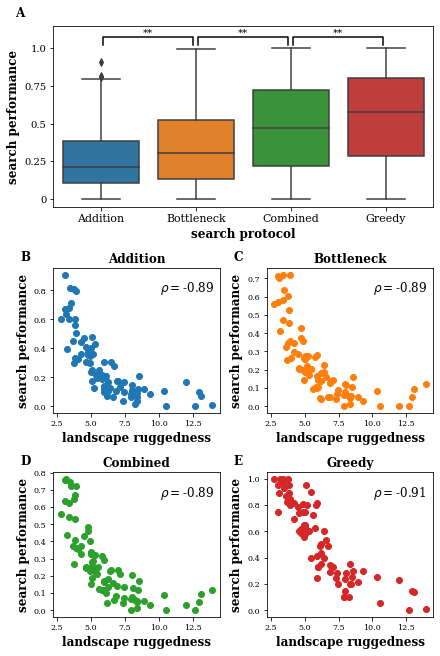

In [2]:
destfolder='/Users/ashish/Dropbox/research/ecology/Figures/Fig_comparing_search_protocols/'

############################ for CR model ############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled_AGG/"
# parameter_list=OrderedDict([ ('SM',[16] ), ('mean_c', "1 to param1{'LB' : 1}")])
# _,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
# folder_suffix='SM'


############################ for CR model with M=2S############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM2_CfixednumGamma_meanC_compiled_AGG/"
# parameter_list=OrderedDict([ ('SM2-',[16] ), ('mean_c', "1 to param1{'step_size' : 2,'LB' : 3,'UB_X':2}")])
# _,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
# folder_suffix='SM2'


############################ for CR model with S=2M ############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SMp5_CfixednumGamma_meanC_compiled_AGG/"
# parameter_list=OrderedDict([ ('SMp5',[16] ), ("mean_c", "1 to param1{'LB' : 1,'step_size' : 1, 'UB_X' : 0.5}")])
# _,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
# folder_suffix='S-2M'

############################ CF meanC ############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CF_CfixedxGamma0Special_meanC_compiled_AGG/"
# parameter_name='mean_c'
# parameter_list={parameter_name:[1,2,3,4,5,6,7,8,9,10,11,12]}
# _,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
# folder_suffix='CF_meanC'


########################### CF l ############################
fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CF_CfixedxGamma01Special_l_compiled_AGG/"
parameter_name='l'
''' l=0 is not included because focal species abundance doesn't make sense for it'''
parameter_list={parameter_name:[  0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]}
_,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
folder_suffix='CF_l'



if not os.path.exists(destfolder): os.makedirs(destfolder)  
ctr=0
for agg_filename in glob.glob(fold_agg+'AggAnalysis_*.dat'):
        ctr+=1
assert ctr==1, print ('number of files that matched was',ctr,'instead')
agg_data=pickle.load(open(agg_filename, 'rb'))



# community_function='Species 2 product FullLandscape'
# community_suffix='Sp2productFull'
community_function='Species 2,3 coex_product FullLandscape'
community_suffix='Sp23coexFull'

# community_function='Shannon Diversity'
# community_suffix='ShannonD'

import seaborn as sns
fig5 = plt.figure(figsize=(6,9),constrained_layout=True)
widths = [1, 1]
heights = [1.25, 1, 1]
spec5 = fig5.add_gridspec(ncols=2, nrows=3, width_ratios=widths,
                          height_ratios=heights)

ax0=fig5.add_subplot(spec5[0, :])

Xlabel=r'search protocol'
# Ylabel=r'rel. optimum found'
Ylabel=r'search performance'
#######################


X1_key=': '+community_function+': SpeciesAddition_relopt_avg'
X4_key=': '+community_function+': Greediest_relopt_avg'
# X2_key=': '+community_function+': Bottleneck_relopt_avg-dilution2'
# X3_key=': '+community_function+': Combined_relopt_avg-dilution2'

## choose index of dilution factor with best search performance
if community_function =='Species 2 product FullLandscape' and folder_suffix=='SM':    
    X2_key=': '+community_function+': Bottleneck_relopt_avg-dilution1'+'-fixed_conversion'
    X3_key=': '+community_function+': Combined_relopt_avg-dilution1'+'-fixed_conversion'
elif community_function =='Species 2 product FullLandscape' and folder_suffix=='CF_l':    
    X2_key=': '+community_function+': Bottleneck_relopt_avg-dilution4'+'-fixed_conversion'
    X3_key=': '+community_function+': Combined_relopt_avg-dilution4'+'-fixed_conversion'
elif community_function=='Species 2,3 coex_product FullLandscape'and folder_suffix=='SM':    
    X2_key=': '+community_function+': Bottleneck_relopt_avg-dilution2'+'-fixed_conversion'
    X3_key=': '+community_function+': Combined_relopt_avg-dilution2'+'-fixed_conversion'
elif community_function=='Species 2,3 coex_product FullLandscape'and folder_suffix=='CF_l':    
    X2_key=': '+community_function+': Bottleneck_relopt_avg-dilution4'+'-fixed_conversion'
    X3_key=': '+community_function+': Combined_relopt_avg-dilution4'+'-fixed_conversion'
elif community_function=='Shannon Diversity'and folder_suffix=='SM':    
    X2_key=': '+community_function+': Bottleneck_relopt_avg-dilution1'+'-fixed_conversion'
    X3_key=': '+community_function+': Combined_relopt_avg-dilution1'+'-fixed_conversion'
else:
    sys.exit(1)

# X_key=': '+community_function+': mean_relative_optimum_Greediest'
# Y_key=': '+community_function+': mean_relative_optimum_Greediest'  #dummy
X1values, X2values= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X1_key,X2_key) 
X3values, X4values= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X3_key,X4_key) 
print(len(X1values),len(X2values),len(X3values),len(X4values))
X1values, _=remove_Nones(X1values,X1values) 
X2values, _=remove_Nones(X2values,X2values) 
X3values, _=remove_Nones(X3values,X3values) 
X4values, _=remove_Nones(X4values,X4values) 

# ax0.boxplot([X1values, X2values, X3values, X4values])
# ax0.set_ylim(-0.05,1.05)
# ax0.set_xticks([1,2,3,4])
# ax0.set_xticklabels(['Addition','Bottleneck','Combined','Greedy'],fontsize=fontSize-1)
# ax0.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
# ax0.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax0.text(-0.1,1.05,'A',fontweight="bold",transform=ax0.transAxes,fontsize=fontSize)

print(len(X1values),len(X2values),len(X3values),len(X4values))
xdic={'Addition':X1values,'Bottleneck':X2values,'Combined': X3values, 'Greedy':X4values}
df2=pd.DataFrame(xdic)
melted_df=pd.melt(df2)
ax0 = sns.boxplot(x='variable', y='value',data=melted_df)
ax0.set_ylim(-0.05,1.15)
ax0.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax0.set_yticklabels([0, 0.25, 0.5, 0.75, 1.0],fontsize=labelSize)
ax0.set_xticklabels(['Addition','Bottleneck','Combined','Greedy'],fontsize=fontSize-1)
ax0.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax0.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)

### to change color of whiskers and box boundaries:
# # iterate over boxes
# for i,box in enumerate(ax0.artists):
#     box.set_edgecolor('grey')
#     # iterate over whiskers and median lines
#     for j in range(6*i,6*(i+1)):
#          ax0.lines[j].set_color('grey')
### from https://stackoverflow.com/questions/43434020/black-and-white-boxplots-in-seaborn

_,p12=scipy.stats.ttest_rel(X1values,X2values)
_,p23=scipy.stats.ttest_rel(X2values,X3values)
_,p34=scipy.stats.ttest_rel(X3values,X4values)
print ('pvalues 1-2, 2-3, and 3-4 were', "{:.2e}".format(p12),"{:.2e}".format(p23) ,"{:.2e}".format(p34))  


def plot_significance_lines(ax,pval,x1,x2,y,h,colr='k'):
    if pval<0.05:           
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=colr)
        if pval<0.01:
            ax.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=colr)
        else:
            ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=colr)
    return ax       

# y, h =melted_df['value'].max() + .05, .05
y, h =1 + .025, .05  
w=0.025
ax0=plot_significance_lines(ax0, p12, 0+w, 1-w, y, h)
ax0=plot_significance_lines(ax0, p23, 1+w, 2-w, y, h)
ax0=plot_significance_lines(ax0, p34, 2+w, 3-w, y, h)

###for annotation and box plot customization: https://stackoverflow.com/questions/36578458/how-does-one-insert-statistical-annotations-stars-or-p-values-into-matplotlib/37518947#37518947

color_list = sns.color_palette("tab10",4)
color_list.as_hex() 
Xlabel=r'landscape ruggedness'
ax1 =fig5.add_subplot(spec5[1,0])

Y1_key=': '+community_function+': SpeciesAddition_relopt_avg'
Y4_key=': '+community_function+': Greediest_relopt_avg'

# biomass_conversion_type='adaptive'
# Y2_key=': '+community_function+': Bottleneck_relopt_avg-dilution3'
# Y3_key=': '+community_function+': Combined_relopt_avg-dilution3'
biomass_conversion_type='fixed'
Y2_key=': '+community_function+': Bottleneck_relopt_avg-dilution1'+'-fixed_conversion'
Y3_key=': '+community_function+': Combined_relopt_avg-dilution1'+'-fixed_conversion'

X_key=': '+community_function+': r/s' 

Y1values, Xvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,Y1_key,X_key) 
Y1values,Xvalues=remove_Nones(Y1values,Xvalues) 
ax1.set_title('Addition',fontweight="bold",fontsize=fontSize)
ax1=plot_SpearmanScatterplot(ax1, Xvalues,Y1values,  text_rho=True,text_loc=[0.64,0.8],label_name='r/s',
                             color=color_list[0], textcolor='k')
ax1.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax1.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax1.text(-0.2,1.05,'B',fontweight="bold",transform=ax1.transAxes,fontsize=fontSize)

ax2 =fig5.add_subplot(spec5[1,1])
Y2values, Xvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,Y2_key,X_key) 
Y2values,Xvalues=remove_Nones(Y2values,Xvalues) 
ax2.set_title('Bottleneck',fontweight="bold",fontsize=fontSize)
ax2=plot_SpearmanScatterplot(ax2, Xvalues,Y2values,  text_rho=True,text_loc=[0.64,0.8],label_name='r/s', 
                             color=color_list[1], textcolor='k')
ax2.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax2.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax2.text(-0.2,1.05,'C',fontweight="bold",transform=ax2.transAxes,fontsize=fontSize)



ax3 =fig5.add_subplot(spec5[2,0]) 
Y3values, Xvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,Y3_key,X_key) 
Y3values,Xvalues=remove_Nones(Y3values,Xvalues) 
ax3.set_title('Combined',fontweight="bold",fontsize=fontSize)
ax3=plot_SpearmanScatterplot(ax3, Xvalues,Y3values,  text_rho=True,text_loc=[0.64,0.8],label_name='r/s', 
                             color=color_list[2], textcolor='k')
ax3.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax3.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax3.text(-0.2,1.05,'D',fontweight="bold",transform=ax3.transAxes,fontsize=fontSize)



ax4 =fig5.add_subplot(spec5[2,1]) 
Y4values, Xvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,Y4_key,X_key) 
Y4values,Xvalues=remove_Nones(Y4values,Xvalues) 
ax4.set_title('Greedy',fontweight="bold",fontsize=fontSize)
ax4=plot_SpearmanScatterplot(ax4, Xvalues,Y4values,  text_rho=True,text_loc=[0.64,0.8],label_name='r/s', 
                             color=color_list[3], textcolor='k')
ax4.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax4.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax4.text(-0.2,1.05,'E',fontweight="bold",transform=ax4.transAxes,fontsize=fontSize)

# plt.tight_layout()
plt.savefig(destfolder+'Fig_search_protocols'+community_suffix+'-'+folder_suffix+'-'+biomass_conversion_type+'.pdf')


## Optimal dilution factor search protocols

dict_keys(['l']) {'l': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}


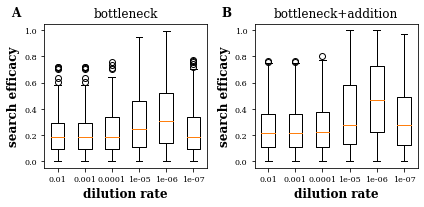

In [30]:
destfolder='/Users/ashish/Dropbox/research/ecology/Figures/Fig_comparing_search_protocols/'

############################ for CR model ############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled_AGG/"
# parameter_list=OrderedDict([ ('SM',[16] ), ('mean_c', "1 to param1{'LB' : 1}")])
# _,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
# folder_suffix='SM'


############################ for CR model with M=2S############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM2_CfixednumGamma_meanC_compiled_AGG/"
# parameter_list=OrderedDict([ ('SM2-',[16] ), ('mean_c', "1 to param1{'step_size' : 2,'LB' : 3,'UB_X':2}")])
# _,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
# folder_suffix='SM2'


############################ for CR model with S=2M ############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SMp5_CfixednumGamma_meanC_compiled_AGG/"
# parameter_list=OrderedDict([ ('SMp5',[16] ), ("mean_c", "1 to param1{'LB' : 1,'step_size' : 1, 'UB_X' : 0.5}")])
# _,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
# folder_suffix='S-2M'

############################ CF meanC ############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CF_CfixedxGamma0Special_meanC_compiled_AGG/"
# parameter_name='mean_c'
# parameter_list={parameter_name:[1,2,3,4,5,6,7,8,9,10,11,12]}
# _,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
# folder_suffix='CF_meanC'


# ########################### CF l ############################
fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CF_CfixedxGamma01Special_l_compiled_AGG/"
parameter_name='l'
''' l=0 is not included because focal species abundance doesn't make sense for it'''
parameter_list={parameter_name:[  0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]}
_,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
folder_suffix='CF_l'



if not os.path.exists(destfolder): os.makedirs(destfolder)  
ctr=0
for agg_filename in glob.glob(fold_agg+'AggAnalysis_*.dat'):
        ctr+=1
assert ctr==1, print ('number of files that matched was',ctr,'instead')
agg_data=pickle.load(open(agg_filename, 'rb'))

# community_function='Species 2 product FullLandscape'
# community_suffix='Sp2productFull'
community_function='Species 2,3 coex_product FullLandscape'
community_suffix='Sp23coexFull'
# community_function='Shannon Diversity'
# community_suffix='ShannonD'


fig = plt.figure(figsize=(6,3)) 

Xlabel=r'dilution rate'
Ylabel=r'search efficacy'

#######################
ax1 = fig.add_subplot(1,2,1) 

# dilutions_chosen=[3,4,5,6,7,8]
dilutions_chosen=[0,1,2,3,4,5]

X1_key=': '+community_function+': Bottleneck_relopt_avg-dilution'+str(dilutions_chosen[0])+'-fixed_conversion'
X2_key=': '+community_function+': Bottleneck_relopt_avg-dilution'+str(dilutions_chosen[1])+'-fixed_conversion'
X3_key=': '+community_function+': Bottleneck_relopt_avg-dilution'+str(dilutions_chosen[2])+'-fixed_conversion'
X4_key=': '+community_function+': Bottleneck_relopt_avg-dilution'+str(dilutions_chosen[3])+'-fixed_conversion'
X5_key=': '+community_function+': Bottleneck_relopt_avg-dilution'+str(dilutions_chosen[4])+'-fixed_conversion'
X6_key=': '+community_function+': Bottleneck_relopt_avg-dilution'+str(dilutions_chosen[5])+'-fixed_conversion'

dilution_key=': '+community_function+': dilution_factor_list'+'-fixed_conversion'
all_rates,_=get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,dilution_key,dilution_key) 

X1values, X2values= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X1_key,X2_key) 
X3values, X4values= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X3_key,X4_key) 
X5values, X6values= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X5_key,X6_key)


dilution_rate=[all_rates[0][i] for i in dilutions_chosen]
X1values, _=remove_Nones(X1values,X1values) 
X2values, _=remove_Nones(X2values,X2values) 
X3values, _=remove_Nones(X3values,X3values) 
X4values, _=remove_Nones(X4values,X4values) 
X5values, _=remove_Nones(X5values,X5values) 
X6values, _=remove_Nones(X6values,X6values) 


ax1.boxplot([X1values, X2values, X3values, X4values, X5values, X6values])
# ax1.boxplot([X1values, X2values, X3values, X4values])
# ax1.text(0.05,0.9, r'$\overline{\Delta}$='+'{:.2f}'.format(np.mean(delta_search)),horizontalalignment='left', verticalalignment='top', transform=ax1.transAxes ) 
# ax1.set_xlim(-1.,1.)
ax1.set_title('bottleneck')
ax1.set_ylim(-0.05,1.05)
# ax1.set_xticks([1,2,3,4])
ax1.set_xticklabels(dilution_rate)
ax1.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax1.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax1.text(-0.2,1.05,'A',fontweight="bold",transform=ax1.transAxes,fontsize=fontSize)

ax2 = fig.add_subplot(1,2,2) 

X1_key=': '+community_function+': Combined_relopt_avg-dilution'+str(dilutions_chosen[0])+'-fixed_conversion'
X2_key=': '+community_function+': Combined_relopt_avg-dilution'+str(dilutions_chosen[1])+'-fixed_conversion'
X3_key=': '+community_function+': Combined_relopt_avg-dilution'+str(dilutions_chosen[2])+'-fixed_conversion'
X4_key=': '+community_function+': Combined_relopt_avg-dilution'+str(dilutions_chosen[3])+'-fixed_conversion'
X5_key=': '+community_function+': Combined_relopt_avg-dilution'+str(dilutions_chosen[4])+'-fixed_conversion'
X6_key=': '+community_function+': Combined_relopt_avg-dilution'+str(dilutions_chosen[5])+'-fixed_conversion'



X1values, X2values= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X1_key,X2_key) 
X3values, X4values= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X3_key,X4_key) 
X5values, X6values= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X5_key,X6_key) 

all_rates,_=get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,dilution_key,dilution_key) 
dilution_rate=[all_rates[0][i] for i in dilutions_chosen]
X1values, _=remove_Nones(X1values,X1values) 
X2values, _=remove_Nones(X2values,X2values) 
X3values, _=remove_Nones(X3values,X3values) 
X4values, _=remove_Nones(X4values,X4values)
X5values, _=remove_Nones(X5values,X5values) 
X6values, _=remove_Nones(X6values,X6values) 


ax2.boxplot([X1values, X2values, X3values, X4values, X5values, X6values])
# ax2.boxplot([X1values, X2values, X3values, X4values])
# X1flattened = [item for sublist in list(X1values) for item in sublist]
# X2flattened = [item for sublist in list(X2values) for item in sublist]
# X3flattened = [item for sublist in list(X3values) for item in sublist]
# X4flattened = [item for sublist in list(X4values) for item in sublist]
# ax2.boxplot([X1flattened,X2flattened,X3flattened,X4flattened])

ax2.set_title('bottleneck+addition')
ax2.set_ylim(-0.05,1.05)
# ax2.set_xticks([1,2,3,4])
ax2.set_xticklabels(dilution_rate)
ax2.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax2.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax2.text(-0.2,1.05,'B',fontweight="bold",transform=ax2.transAxes,fontsize=fontSize)

plt.tight_layout()
plt.savefig(destfolder+'Search_vs_dilution-FixedBiomass'+community_suffix+'-'+folder_suffix+'.pdf')


# Exptal landscapes

## 2panel

0.9452629222421258
0.8551574925307575
0.8704675565155033
0.9620632702630852
0.9892145158727659
0.8286121631217487
0.9412084714596638

 R2 vals=
 ('xyl', 0.9452629222421258) ('gal', 0.8551574925307575) ('glu', 0.8704675565155033) ('xyl+gal', 0.9620632702630852) ('glu+xyl', 0.9892145158727659) ('glu+gal', 0.8286121631217487) ('glu+xyl+gal', 0.9412084714596638)
mean $R^2$, std dev 0.9131409131436643 0.056478065740862095


and so $R^2$= 0.9131409131436643 +- 0.045191864623328734

 mean relative comunity functions= [0.654339519650655, 0.6701723682472596, 0.695542246768007, 0.7047008823095099, 0.6735423698559002, 0.681946691682732, 0.7036306705765969]

 and so= 0.6834106784415229

 Slope vals=
 ('xyl', -1.60679464813172) ('gal', -1.565304300245931) ('glu', -1.5292232095943183) ('xyl+gal', -1.1815833968533538) ('glu+xyl', -0.9675845174344653) ('glu+gal', -1.616208450011157) ('glu+xyl+gal', -1.1907540267888608)


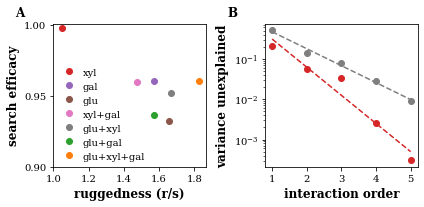

In [4]:
destfolder='/Users/ashish/Dropbox/research/ecology/Figures/Fig_Expdata/'
if not os.path.exists(destfolder): os.makedirs(destfolder) 

base_dir="/Users/ashish/Dropbox/research/ecology/Exp Data/"
substrate_idx_list=[2,3,4,5,6,1,0]
# for i in substrate_idx_list:
#     folder_name_list.append(base_dir+'Substrate'+str(i)+'/')

# folder_name_list=[base_dir+'Substrate0/',
#                   base_dir+'Substrate1/',
#                   base_dir+'Substrate2/',
#                   base_dir+'Substrate3/',
#                   base_dir+'Substrate4/',
#                   base_dir+'Substrate5/',
#                   base_dir+'Substrate6/']

color_list=create_color_list(scheme_name='sns_tab10')[1:] ## to make Xylose red
fig = plt.figure(figsize=(6,3)) 

ax1 = fig.add_subplot(1,2,1) 
community_function='metabolic rate'
Ylabel='search efficacy'
Y_key=community_function+': mean_relative_optimum_Greediest'
label=''
Xlabel=r'ruggedness (r/s)'
X_key=community_function+': r/s'

Yvalues=[]
Xvalues=[]


# for fold in folder_name_list:
for subs_idx in substrate_idx_list:
    fold=base_dir+'Substrate'+str(subs_idx)+'/'
    for analysis_filename in glob.glob(fold+'analysis_*.dat'):
         break   
    analysis_data=pickle.load(open(analysis_filename, 'rb'))
    exp_condition=analysis_data['substrate name']
    Yvalues.append(analysis_data[Y_key])
    Xvalues.append(analysis_data[X_key])
#     ax1.plot(analysis_data[X_key],analysis_data[Y_key],'o',markeredgecolor=color_list[subs_idx],markerfacecolor='None',label=exp_condition)
    ax1.plot(analysis_data[X_key],analysis_data[Y_key],'o',color=color_list[subs_idx],label=exp_condition)
#     ax1.plot(analysis_data[X_key],analysis_data[community_function+': mean_relative_function'],'*',color=color_list[subs_idx])
    
# ax1.legend(loc=3,ncol=1,fontsize=fontSize-3, handletextpad=0.2, borderpad=0.2, borderaxespad=0.2,columnspacing=0.2) 
# ax1.legend(loc=3,ncol=1,fontsize=fontSize-2,frameon=False, handletextpad=0.3, borderpad=0.3, borderaxespad=0.3) 


ax1.set_yticks([0.9, .95, 1.])
ax1.set_xticks([1, 1.2, 1.4, 1.6, 1.8])
ax1.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax1.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax1.text(-0.25,1.05,'A',fontweight="bold",transform=ax1.transAxes,fontsize=fontSize)




ax2 = fig.add_subplot(1,2,2) 

community_function='metabolic rate'
Ylabel=r'variance unexplained'
Xlabel=r'interaction order'
# Y_key=community_function+': R2_reg'
Y_key=community_function+': Power_spectrum'
## compute var exp from Pspec instead, like for simulations.


r2_list=[]
exp_condition_list=[]
slopes_list=[]
mean_function_list=[]
from sklearn.metrics import r2_score

for subs_idx in substrate_idx_list:
    fold=base_dir+'Substrate'+str(subs_idx)+'/'
    Yvalues=[]    
    for analysis_filename in glob.glob(fold+'analysis_*.dat'):
         break   
    analysis_data=pickle.load(open(analysis_filename, 'rb'))    
    exp_condition=analysis_data['substrate name']#fold.replace(base_dir,'').replace('/','')
    Pspec_arr= np.ravel(analysis_data[Y_key])[1:]## drop 0th component!
    Pspec_arr=Pspec_arr/np.sum(Pspec_arr)##normalize Power spectrum
    ExpOrder_arr=np.arange(len (Pspec_arr)  )+1
    frac_Var_unexp_arr=1.-np.cumsum(Pspec_arr)
    idx_cutoff=-1
    if np.any(frac_Var_unexp_arr<1e-4):
        idx_cutoff=int(np.where(frac_Var_unexp_arr<1e-4)[0][0])
    
#     xdata=ExpOrder_arr[:idx_cutoff]
#     ydata=np.log(frac_Var_unexp_arr[:idx_cutoff])
    fit_coefs=np.polyfit(ExpOrder_arr[:idx_cutoff], np.log(frac_Var_unexp_arr[:idx_cutoff]), 1)
    fit_yvals=np.poly1d(fit_coefs)(ExpOrder_arr[:idx_cutoff])
    
    print (r2_score(fit_yvals,np.log(frac_Var_unexp_arr[:idx_cutoff])) )
    r2_list.append(r2_score(fit_yvals,np.log(frac_Var_unexp_arr[:idx_cutoff])))
    slopes_list.append(fit_coefs[0])
    exp_condition_list.append(exp_condition)
    mean_function_list.append(analysis_data[community_function+': mean_relative_function'])
    
    if subs_idx in [2,6]:
#     if subs_idx>=0:
        ax2.semilogy(ExpOrder_arr[:idx_cutoff], np.exp(fit_yvals ),'--',color=color_list[subs_idx])
#         ax2.semilogy(ExpOrder_arr[:idx_cutoff], frac_Var_unexp_arr[:idx_cutoff],'o',markeredgecolor=color_list[subs_idx],markerfacecolor='None',label=exp_condition)
        ax2.semilogy(ExpOrder_arr[:idx_cutoff], frac_Var_unexp_arr[:idx_cutoff],'o',color=color_list[subs_idx],label=exp_condition)


# ax2.legend(loc='best') 
ax2.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax2.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax2.text(-0.25,1.05,'B',fontweight="bold",transform=ax2.transAxes,fontsize=fontSize)

for ax_temp in [ax1,ax2]:
    ax_temp.tick_params(labelsize= labelSize)

######################################
plt.tight_layout()
plt.savefig(destfolder+'ExptData_Corr+Expdecay_Nolegend-2panel.pdf')

ax1.legend(loc=3,ncol=1,fontsize=fontSize-2,frameon=False, handletextpad=0.3, borderpad=0.3, borderaxespad=0.3) 
plt.savefig(destfolder+'ExptData_Corr+Expdecay-2panel.pdf')
print ('\n R2 vals=\n',*zip(exp_condition_list,r2_list) )
print (r'mean $R^2$, std dev',np.mean(r2_list), np.std(r2_list))
print ('\n')
print (r'and so $R^2$=',np.mean(r2_list), '+-',1.96*np.std(r2_list)/np.sqrt(7-1) )
print ('\n mean relative comunity functions=', mean_function_list)
print ('\n and so=', np.mean(mean_function_list))

print ('\n Slope vals=\n',*zip(exp_condition_list,slopes_list) )
#

## 3 panel

In [ ]:
destfolder='/Users/ashish/Dropbox/research/ecology/Figures/Fig_Expdata/'
if not os.path.exists(destfolder): os.makedirs(destfolder) 

base_dir="/Users/ashish/Dropbox/research/ecology/Exp Data/"
substrate_idx_list=[2,3,4,5,6,1,0]
# for i in substrate_idx_list:
#     folder_name_list.append(base_dir+'Substrate'+str(i)+'/')

# folder_name_list=[base_dir+'Substrate0/',
#                   base_dir+'Substrate1/',
#                   base_dir+'Substrate2/',
#                   base_dir+'Substrate3/',
#                   base_dir+'Substrate4/',
#                   base_dir+'Substrate5/',
#                   base_dir+'Substrate6/']

color_list=create_color_list(scheme_name='sns_tab10')[1:] ## to make Xylose red
fig = plt.figure(figsize=(9,3)) 

ax1 = fig.add_subplot(1,3,1) 
community_function='metabolic rate'
Ylabel='search efficacy'
Y_key=community_function+': mean_relative_optimum_Greediest'
label=''
Xlabel=r'ruggedness (r/s)'
X_key=community_function+': r/s'

Yvalues=[]
Xvalues=[]


# for fold in folder_name_list:
for subs_idx in substrate_idx_list:
    fold=base_dir+'Substrate'+str(subs_idx)+'/'
    for analysis_filename in glob.glob(fold+'analysis_*.dat'):
         break   
    analysis_data=pickle.load(open(analysis_filename, 'rb'))
    exp_condition=analysis_data['substrate name']
    Yvalues.append(analysis_data[Y_key])
    Xvalues.append(analysis_data[X_key])
#     ax1.plot(analysis_data[X_key],analysis_data[Y_key],'o',markeredgecolor=color_list[subs_idx],markerfacecolor='None',label=exp_condition)
    ax1.plot(analysis_data[X_key],analysis_data[Y_key],'o',color=color_list[subs_idx],label=exp_condition)
#     ax1.plot(analysis_data[X_key],analysis_data[community_function+': mean_relative_function'],'*',color=color_list[subs_idx])
    
# ax1.legend(loc=3,ncol=1,fontsize=fontSize-3, handletextpad=0.2, borderpad=0.2, borderaxespad=0.2,columnspacing=0.2) 
# ax1.legend(loc=3,ncol=1,fontsize=fontSize-2,frameon=False, handletextpad=0.3, borderpad=0.3, borderaxespad=0.3) 


ax1.set_yticks([0.9, .95, 1.])
ax1.set_xticks([1, 1.2, 1.4, 1.6, 1.8])
ax1.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax1.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax1.text(-0.25,1.05,'A',fontweight="bold",transform=ax1.transAxes,fontsize=fontSize)

ax2 = fig.add_subplot(1,3,2) 
community_function='metabolic rate'
Ylabel='search efficacy'
Y_key=community_function+': mean_relative_optimum_Greediest'
label=''
Xlabel=r'ruggedness ($1-Z_{nn}$)'
X_key=community_function+': nn_correlation'

Yvalues=[]
Xvalues=[]


for subs_idx in substrate_idx_list:
    fold=base_dir+'Substrate'+str(subs_idx)+'/'
    for analysis_filename in glob.glob(fold+'analysis_*.dat'):  
        break
    analysis_data=pickle.load(open(analysis_filename, 'rb'))
    exp_condition=analysis_data['substrate name']
    Yvalues.append(analysis_data[Y_key])
    Xvalues.append(analysis_data[X_key])
#     ax1.plot(analysis_data[X_key],analysis_data[Y_key],'o',markeredgecolor=color_list[subs_idx],markerfacecolor='None',label=exp_condition)
    ax2.plot(1.-analysis_data[X_key],analysis_data[Y_key],'o',color=color_list[subs_idx],label=exp_condition)
# ax1.legend(loc=3,ncol=1,fontsize=fontSize-3, handletextpad=0.2, borderpad=0.2, borderaxespad=0.2,columnspacing=0.2) 
# ax2.legend(loc=3,ncol=1,fontsize=fontSize-2,frameon=False, handletextpad=0.3, borderpad=0.3, borderaxespad=0.3) 

ax2.set_yticks([0.9,0.95, 1.])
ax2.set_xlim(0.25,.75)
# ax2.set_xticks([1, 1.2, 1.4, 1.6, 1.8])
ax2.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax2.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax2.text(-0.25,1.05,'B',fontweight="bold",transform=ax2.transAxes,fontsize=fontSize)


ax3 = fig.add_subplot(1,3,3) 

community_function='metabolic rate'
Ylabel=r'variance unexplained'
Xlabel=r'interaction order'
# Y_key=community_function+': R2_reg'
Y_key=community_function+': Power_spectrum'
## compute var exp from Pspec instead, like for simulations.


r2_list=[]
exp_condition_list=[]
slopes_list=[]
mean_function_list=[]
from sklearn.metrics import r2_score

for subs_idx in substrate_idx_list:
    fold=base_dir+'Substrate'+str(subs_idx)+'/'
    Yvalues=[]    
    for analysis_filename in glob.glob(fold+'analysis_*.dat'):
         break   
    analysis_data=pickle.load(open(analysis_filename, 'rb'))    
    exp_condition=analysis_data['substrate name']#fold.replace(base_dir,'').replace('/','')
    Pspec_arr= np.ravel(analysis_data[Y_key])[1:]## drop 0th component!
    Pspec_arr=Pspec_arr/np.sum(Pspec_arr)##normalize Power spectrum
    ExpOrder_arr=np.arange(len (Pspec_arr)  )+1
    frac_Var_unexp_arr=1.-np.cumsum(Pspec_arr)
    idx_cutoff=-1
    if np.any(frac_Var_unexp_arr<1e-4):
        idx_cutoff=int(np.where(frac_Var_unexp_arr<1e-4)[0][0])
    
#     xdata=ExpOrder_arr[:idx_cutoff]
#     ydata=np.log(frac_Var_unexp_arr[:idx_cutoff])
    fit_coefs=np.polyfit(ExpOrder_arr[:idx_cutoff], np.log(frac_Var_unexp_arr[:idx_cutoff]), 1)
    fit_yvals=np.poly1d(fit_coefs)(ExpOrder_arr[:idx_cutoff])
    
    print (r2_score(fit_yvals,np.log(frac_Var_unexp_arr[:idx_cutoff])) )
    r2_list.append(r2_score(fit_yvals,np.log(frac_Var_unexp_arr[:idx_cutoff])))
    slopes_list.append(fit_coefs[0])
    exp_condition_list.append(exp_condition)
    mean_function_list.append(analysis_data[community_function+': mean_relative_function'])
    
    if subs_idx in [2,6]:
#     if subs_idx>=0:
        ax3.semilogy(ExpOrder_arr[:idx_cutoff], np.exp(fit_yvals ),'--',color=color_list[subs_idx])
#         ax3.semilogy(ExpOrder_arr[:idx_cutoff], frac_Var_unexp_arr[:idx_cutoff],'o',markeredgecolor=color_list[subs_idx],markerfacecolor='None',label=exp_condition)
        ax3.semilogy(ExpOrder_arr[:idx_cutoff], frac_Var_unexp_arr[:idx_cutoff],'o',color=color_list[subs_idx],label=exp_condition)


# ax3.legend(loc='best') 
ax3.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax3.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax3.text(-0.25,1.05,'C',fontweight="bold",transform=ax3.transAxes,fontsize=fontSize)

for ax_temp in [ax1,ax2,ax3]:
    ax_temp.tick_params(labelsize= labelSize)

######################################
plt.tight_layout()
plt.savefig(destfolder+'ExptData_Corr+Expdecay_Nolegend.pdf')

ax1.legend(loc=3,ncol=1,fontsize=fontSize-2,frameon=False, handletextpad=0.3, borderpad=0.3, borderaxespad=0.3) 
plt.savefig(destfolder+'ExptData_Corr+Expdecay.pdf')
print ('\n R2 vals=\n',*zip(exp_condition_list,r2_list) )
print (r'mean $R^2$, std dev',np.mean(r2_list), np.std(r2_list))
print ('\n')
print (r'and so $R^2$=',np.mean(r2_list), '+-',1.96*np.std(r2_list)/np.sqrt(7-1) )
print ('\n mean relative comunity functions=', mean_function_list)
print ('\n and so=', np.mean(mean_function_list))

print ('\n Slope vals=\n',*zip(exp_condition_list,slopes_list) )
#

# Exptal data Clark, Venturelli

### read the metadata python dictionary from Github of Clark etal

In [2]:
#Define the descriptors involved in this experiment
numspecies=25
allspecies=['ER','FP','AC','CC','RI','EL','CH','DP','BH','CA','PC','PJ','DL','CG','BF','BO','BT','BU','BV','BC','BY','DF','BL','BP','BA']
phylogeny=['PC','PJ','BV','BF','BO','BT','BC','BY','BU','DP','BL','BA','BP','CA','EL','FP','CH','AC','BH','CG','ER','RI','CC','DL','DF']
phylogeny_nobpb=['PC','PJ','BV','BF','BO','BT','BC','BY','BU','DP','BL','BA','BP','CA','EL','CH','BH','CG','DL','DF']
phylogeny_nogaps=['PC','PJ','BF','BO','BT','DP','BA','BP','CA','EL','CH','BH','CG','DL','DF']
speciesvectorDict={}
n=1
for species in allspecies:
	speciesvectorDict[species]=n
	n+=1

k=0
phylogenyvectorDict={}
for species in phylogeny:
	phylogenyvectorDict[species]=k
	k+=1

bpbindices=[15,17,20,21,22]
bpbspecies=['ER','FP','AC','CC','RI']
spbspecies=['PJ','BT','BF','BC','BO','BV','PC']
others=['EL','CH','DP','BH','CA','PC','PJ','DL','CG','BF','BO','BT','BU','BV','BC','BY','DF','BL','BP','BA']
comms=['COMM0','COMM1','COMM2','COMM3','COMM4']

commsDict={
	'COMM0':['DP','BH','CA','PC','EL','CH','BO','BT','BU','BV'],
	'COMM1':['ER','FP','DP','BH','CA','PC','EL','CH','BO','BT','BU','BV'],
	'COMM2':['ER','FP','AC','HB','CC','RI','DP','BH','CA','PC','EL','CH','BO','BT','BU','BV'],
	'COMM3':['ER','FP','AC','HB','CC','RI','EL','CH','DP','BH','CA','PC','PJ','DL','CG','BF','BO','BT','BU','BV','BC','BY','DF','BL','BP','BA'],
	'COMM4':['EL','CH','DP','BH','CA','PC','PJ','DL','CG','BF','BO','BT','BU','BV','BC','BY','DF','BL','BP','BA'],
	'COMM5':['ER','FP','AC','CC','RI','DP','BH','CA','PC','EL','CH','BO','BT','BU','BV'],
	'COMM6':['ER','FP','AC','CC','RI','EL','CH','DP','BH','CA','PC','PJ','DL','CG','BF','BO','BT','BU','BV','BC','BY','DF','BL','BP','BA'],
	'COMM7':['ER','FP','RI','BH','DP','PJ','AC','CC','BV','DL','BY','BL','DF','BA','EL'],
	'COMM8':['ER','FP','RI','AC','CC']
}

COMM0=['DP','BH','CA','PC','EL','CH','BO','BT','BU','BV']
COMM1=['ER','FP','DP','BH','CA','PC','EL','CH','BO','BT','BU','BV']
COMM2=['ER','FP','AC','HB','CC','RI','DP','BH','CA','PC','EL','CH','BO','BT','BU','BV']
COMM3=['ER','FP','AC','HB','CC','RI','EL','CH','DP','BH','CA','PC','PJ','DL','CG','BF','BO','BT','BU','BV','BC','BY','DF','BL','BP','BA']
COMM4=['EL','CH','DP','BH','CA','PC','PJ','DL','CG','BF','BO','BT','BU','BV','BC','BY','DF','BL','BP','BA']
COMM5=['ER','FP','AC','CC','RI','DP','BH','CA','PC','EL','CH','BO','BT','BU','BV']
COMM6=['ER','FP','AC','CC','RI','EL','CH','DP','BH','CA','PC','PJ','DL','CG','BF','BO','BT','BU','BV','BC','BY','DF','BL','BP','BA']
COMM7=['ER','FP','RI','BH','DP','PJ','AC','CC','BV','DL','BY','BL','DF','BA','EL']
COMM8=['ER','FP','RI','AC','CC']

LOOComms=['COMM6']
for species in phylogeny:
	LOOComms.append('COMM6*'+species)

colordict = {
		'ER' : 'xkcd:pale purple',	#b790d4
		'DP' : 'xkcd:orange',		#f97306
		'FP' : 'xkcd:brick red',	#8f1402
		'BH' : 'xkcd:dark purple',	#35063e
		'CA' : 'xkcd:light orange',	#fdaa48
		'PC' : 'xkcd:light blue',	#95d0fc
		'EL' : 'xkcd:peach',		#ffb07c
		'CH' : 'xkcd:mauve',		#ae7181
		'BO' : 'xkcd:olive',		#6e750e
		'BT' : 'xkcd:green',		#15b01a
		'BU' : 'xkcd:blue green',	#137e6d
		'BV' : 'xkcd:blue',			#0343df
		'AC' : 'xkcd:periwinkle',	#8e82fe
		'HB' : 'xkcd:magenta',		#c20078
		'CC' : 'xkcd:grey',			#929591
		'RI' : 'xkcd:dark blue',	#00035b
		'DL' : 'xkcd:brown',		#653700
		'CG' : 'xkcd:purple',		#7e1e9c
		'BF' : 'xkcd:lime green',	#89fe05
		'BC' : 'xkcd:sea green',	#53fca1
		'BY' : 'xkcd:sage',			#87ae73
		'PJ' : 'xkcd:cyan',			#00ffff
		'DF' : 'xkcd:tan',			#d1b26f
		'BL' : 'xkcd:red',			#e50000
		'BP' : 'xkcd:salmon pink',	#ff796c
		'BA' : 'xkcd:coral',		#fc5a50
		'CD' : 'Black',
		'CS' : 'Black',
		'EH' : 'Black',
		'EC' : 'Black'
		}
		
namedict={
   'BA': 'Bifidobacterium_adolescentis_ATCC_15703_NC_008618',
   'CA': 'Collinsella_aerofaciens_ATCC_25986',
   'BT': 'Bacteroides_thetaiotaomicron_VPI-5482_NC_004663',
   'BU': 'Bacteroides_uniformis_ATCC_8492',
   'PC': 'Prevotella_copri_DSM_18205',
   'AC': 'Anaerostipes_caccae_DSM_14662_4',
   'BH': 'Blautia_hydrogenotrophica_DSM_10507',
   'CC': 'Coprococcus_comes_1.0.1_Cont2276_NZ_ABVR01000038',
   'CG': 'Clostridium_asparagiforme_DSM_15981_C_asparagiforme_1.0_Cont7.2_NZ_ACCJ01000522',
   'ER': 'Eubacterium_rectale_ATCC_33656_NC_012781',
   'DP': 'Desulfovibrio_piger_ATCC_29098',
   'EL': 'Eggerthella_lenta_DSM_2243_NC_013204',
   'BY': 'Bacteroides_cellulosilyticus_DSM_14838_1.0_Cont4.1_NZ_ACCH01000108',
   'BF': 'Bacteroides_fragilis_NCTC_9343',
   'CD': 'Clostridioides_difficile',
   'RI': 'Roseburia_intestinalis_L1_82',
   'BP': 'Bifidobacterium_pseudocatenulatum_DSM20438',
   'BV': 'Bacteroides_vulgatus_ATCC_8482_NC_009614',
   'CH': 'Clostridium_hiranonis_DSM_13275',
   'DF': 'Dorea_formicigenerans_ATCC_27755',
   'CS': 'Clostridium_scindens_ATCC_35704',
   'PJ': 'Parabacteroides_johnsonii_DSM_18315_NZ_ABYH01000014',
   'FP': 'Faecalibacterium_prausnitzii_A2_165_NZ',
   'EH': 'Eubacterium_hallii_DSM_3353_1.0_Cont383.1_NZ_ACEP01000116',
   'EC': 'Escherichia_coli',
   'BC': 'Bacteroides_caccae_ATCC_43185',
   'HB': 'Holdemanella_biformis_DSM_3989',
   'BO': 'Bacteroides_ovatus_ATCC_8483',
   'DL': 'Dorea_longicatena_DSM_13814',
   'BL': 'Bifidobacterium_longum_subsp_infantis',
   'B.cereus':'Bacillus_cereus'
   }

metabcolordict={'Acetate': 'r','Butyrate': 'b','Lactate': 'g','Succinate': 'k'}
pairslist=[]
for bpb in bpbspecies:
	for species in allspecies:
		if bpb!=species:
			if species in bpbspecies:
				order=sorted([species,bpb])
				pairslist.append(order[0]+'-'+order[1])
			else:
				pairslist.append(species+'-'+bpb)
pairslist=list(set(pairslist))

validationset_3=['BY-BH-ER','BV-BH-ER','BV-BA-ER','PJ-EL-FP','EL-FP-DF','BY-DP-FP','DP-BA-AC','BA-AC-DF','BY-DP-AC','BY-EL-CC','PJ-BA-CC','DP-BL-CC','DP-BH-RI','BY-BH-RI','BY-EL-RI','FP-BH-ER','DP-FP-ER','BV-FP-ER','BY-AC-ER','AC-ER-DL','AC-BH-ER','BY-ER-CC','BL-ER-CC','ER-CC-DL','BV-ER-RI','PJ-ER-RI','BH-ER-RI','BA-FP-AC','FP-AC-DF','BL-FP-AC','BY-FP-CC','PJ-FP-CC','BL-FP-CC','EL-FP-RI','BL-FP-RI','PJ-FP-RI','BA-AC-CC','PJ-AC-CC','BL-AC-CC','BA-AC-RI','AC-RI-DL','DP-AC-RI','DP-RI-CC','EL-RI-CC','RI-CC-DL','AC-RI-CC','AC-ER-CC','AC-ER-RI','ER-RI-CC','FP-AC-ER','FP-ER-CC','FP-ER-RI','FP-AC-CC','FP-AC-RI','FP-RI-CC']
validationset_4=['BV-BF-BA-ER', 'BY-CH-CG-ER', 'BV-BC-FP-ER', 'BY-CA-FP-ER', 'DP-AC-ER-DF', 'AC-CG-ER-DL', 'BV-BT-ER-CC', 'BH-CG-ER-CC', 'BV-BC-ER-RI', 'BH-ER-RI-DF', 'BY-BA-CA-FP', 'PJ-BU-FP-DL', 'BV-BC-FP-AC', 'DP-BA-FP-AC', 'BT-BL-FP-CC', 'PJ-BY-FP-CC', 'BV-BC-FP-RI', 'FP-CH-BH-RI', 'AC-BH-CG-DF', 'BA-CH-AC-BH', 'BF-BL-AC-CC', 'BY-AC-CG-CC', 'BA-BP-AC-RI', 'CH-AC-CG-RI', 'BF-BT-BL-CC', 'BY-CA-BH-CC', 'BF-BT-RI-CC', 'BY-DP-RI-CC', 'BU-CA-EL-RI', 'PC-CH-BH-RI', 'DP-FP-AC-ER', 'FP-AC-CG-ER', 'BC-FP-ER-CC', 'FP-CG-ER-CC', 'BC-FP-ER-RI', 'BY-FP-ER-RI', 'BL-AC-ER-CC', 'AC-CG-ER-CC', 'AC-BH-ER-RI', 'BA-AC-ER-RI', 'BC-ER-RI-CC', 'CG-ER-RI-CC', 'BF-FP-AC-CC', 'BA-FP-AC-CC', 'FP-AC-BH-RI', 'BA-FP-AC-RI', 'BF-FP-RI-CC', 'FP-BH-RI-CC', 'BL-AC-RI-CC', 'DP-AC-RI-CC']
validationset_5=['BV-BF-BA-EL-ER', 'BY-CA-BH-CG-ER', 'BV-BT-BC-FP-ER', 'BY-BU-FP-ER-DF', 'DP-FP-AC-ER-DF', 'BY-FP-AC-CG-ER', 'BV-BT-FP-ER-CC', 'FP-BH-CG-ER-CC', 'BV-BC-FP-ER-RI', 'BY-FP-CH-ER-RI', 'DP-AC-BH-ER-DF', 'BA-AC-CG-ER-DL', 'BL-AC-ER-CC-DF', 'AC-CG-ER-CC-DL', 'CA-AC-ER-RI-DF', 'BY-AC-CG-ER-RI', 'BV-BF-BT-ER-CC', 'BY-CH-CG-ER-CC', 'BV-BT-ER-RI-CC', 'BH-CG-ER-RI-CC', 'BV-BT-BC-ER-RI', 'BY-BU-BH-ER-RI', 'BY-BL-BA-BP-FP', 'PJ-BU-FP-CH-DF', 'BV-BF-FP-AC-DL', 'BA-FP-CH-AC-BH', 'BF-BL-FP-AC-CC', 'BY-BA-FP-AC-CC', 'FP-CH-AC-BH-RI', 'BA-EL-FP-AC-RI', 'BF-BT-BL-FP-CC', 'BY-FP-CH-BH-CC', 'BF-BT-FP-RI-CC', 'FP-CH-BH-RI-CC', 'BV-BA-BP-FP-RI', 'PC-FP-CH-BH-RI', 'AC-BH-CG-DL-DF', 'BA-CA-CH-AC-BH', 'BF-BT-BL-AC-CC', 'BO-BA-AC-CG-CC', 'BT-BL-AC-RI-CC', 'PJ-AC-CG-RI-CC', 'PJ-BA-BP-AC-RI', 'PC-CH-AC-BH-RI', 'BF-BT-BL-BA-CC', 'BY-EL-CH-BH-CC', 'BF-BT-BC-RI-CC', 'BY-DP-CH-RI-CC', 'BV-BF-BT-RI-DL', 'BU-DP-CH-BH-RI', 'BT-FP-AC-ER-CC', 'FP-AC-CG-ER-CC', 'BL-FP-AC-ER-RI', 'FP-AC-CG-ER-RI', 'BC-FP-ER-RI-CC', 'FP-BH-ER-RI-CC', 'BT-AC-ER-RI-CC', 'AC-CG-ER-RI-CC', 'BT-FP-AC-RI-CC', 'DP-FP-AC-RI-CC']

## construct sigma vectors and function values

In [85]:
file_name='/Users/ashish/Dropbox/research/ecology/Exp Data/Clark, Venturelli/data_tables.txt'

df_temp = pd.read_csv(file_name, index_col=0)
print ('total num expts',len(df_temp))
df_exp=df_temp[df_temp['Contamination?']=='No'].copy()
df_exp=df_exp[df_exp['HB']!=1.0].copy()
df_exp=df_exp.drop(columns=['HB']).copy()
print ('non-contaminated expts', len(df_exp))
'''Species HB is dropped from analysis like in Clark paper, (not in their dictionary)
data points with HB is dropped from analysis
''' 

# for sp in allspecies:
#     df_exp[sp]=df_exp[sp].fillna(0)

sigma_strings=[]
for idx in df_exp.index:
    int_list=df_exp[allspecies].loc[idx].values.astype(int)
    string_ints = [str(i) for i in int_list]
    str_of_ints = ",".join(string_ints)
    sigma_strings.append(str_of_ints)

df_exp['sigma_string']=sigma_strings
unq_sigmas=np.unique(df_exp['sigma_string'].values)
print ('unique expts=', len(unq_sigmas))



total num expts 1850
non-contaminated expts 1561
unique expts= 577


In [108]:
keys_to_keep=['OD', 'Acetate', 'Butyrate', 'Lactate', 'Succinate','sigma_string',
             'Treatment']+allspecies
keys_to_average=['OD', 'Acetate', 'Butyrate', 'Lactate', 'Succinate']
exp_dict={k:[] for k in keys_to_keep} 
df_exp=df_exp[keys_to_keep].copy()

for sigma in unq_sigmas:

    df_temp=df_exp[ df_exp['sigma_string']==sigma]
    df_sub=df_temp[keys_to_average]
    df_mean=df_sub.mean()
#     print(df_exp[ df_exp['sigma_string']==sigma])
#     print(df_mean)
#     print(df_temp.mean())
    for k in keys_to_keep:
        if k in keys_to_average:
            exp_dict[k].append(df_mean[k])
        else:
             exp_dict[k].append(df_temp[k].values[0])
    
expt_df_final=pd.DataFrame(exp_dict)

In [109]:
expt_df_final.head()

,OD,Acetate,Butyrate,Lactate,Succinate,sigma_string,Treatment,ER,FP,AC,...,BO,BT,BU,BV,BC,BY,DF,BL,BP,BA
0,0.898516,40.435357,0.000000,46.047357,1.143614,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1",BA,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.079230,52.278214,0.000000,52.325471,0.595186,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0",BP,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.602282,46.613740,0.000000,41.324920,2.390480,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0",BL,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.914201,30.743825,0.283087,27.481800,1.554650,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0",DF,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.947326,33.716912,0.000000,50.544538,8.272025,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0",BY,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## plot r/s estimate

In [140]:
sigma_array=expt_df_final[allspecies].values
print (np.shape(sigma_array))
comm_function=expt_df_final['Acetate'].values
r,s=analyze_landscape.r_over_s(comm_function, sigma_array)

print ('r/s=',r/s)

(577, 25)
r/s= 3.3668575492825275


In [191]:
comm_function_keys=[ 'Butyrate', 'Lactate', 'Succinate','Acetate','OD']
sigma_array=expt_df_final[allspecies].values
adjList_sub=analyze_landscape.generate_adjacency_list_from_Subsampling(sigma_array)
r_s_dict={}
r_s_list=[]
for key in comm_function_keys:
    comm_function=expt_df_final[key].values
    r,s=analyze_landscape.r_over_s(comm_function, sigma_array)
    r_s_dict.update({key:r/s})  
    r_s_list.append(r/s)


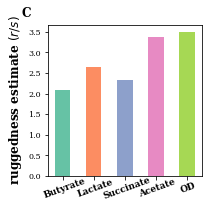

In [259]:

color_list=list(sns.color_palette(palette='Set2'))
xvals=np.arange(len(comm_function_keys))
fig = plt.figure(figsize=(3,3))
ax1 = fig.add_subplot()

# ax1.bar(xvals,r_s_list, color='b',width=0.5,align='edge')
ax1.bar(xvals,r_s_list, color=color_list[:len(r_s_list)],width=0.5,align='center')
ax1.set_xticks(xvals)
ax1.set_xticklabels(comm_function_keys,
                    rotation = 20,fontweight='bold',fontsize=fontSize-3,
                    rotation_mode="anchor")
#)
ax1.set_ylabel(r'ruggedness estimate $(r/s)$',fontweight='bold',fontsize=fontSize)
import matplotlib.transforms
dx=0./72;dy=-1./72
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax1.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
ax1.text(-0.17,1.05,'C',fontweight="bold",transform=ax1.transAxes,fontsize=fontSize)
fig.patch.set_facecolor('white')  

destfolder='/Users/ashish/Dropbox/research/ecology/Figures/Fig_Expdata/'


plt.tight_layout()
plt.savefig(destfolder+'Clark_ruggedness_panel.pdf')
plt.show()

##### biased sampling makes calculating Znn tricky 

there were 520 nearest neighbors in the data set.
Note that sampling is extremely biased:many points don't have any nearest neighbors, while some points have many neighbors.
Therefore calculating Znn is not reliable.

In [179]:
temp=scipy.spatial.distance.pdist(sigma_array,metric='cityblock')
print(np.sum(temp<=1))
adjList_sub=analyze_landscape.generate_adjacency_list_from_Subsampling(sigma_array)

520


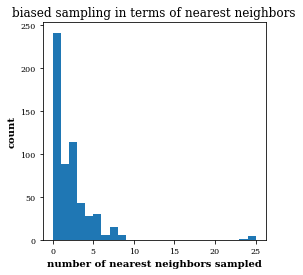

In [181]:
n_nearest_neighbors=[len(ls) for ls in adjList_sub ] 
fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot()
ax1.hist(n_nearest_neighbors, bins=np.arange(0, np.max(n_nearest_neighbors)+1))
ax1.set_xlabel('number of nearest neighbors sampled',fontweight='bold')
ax1.set_ylabel('count',fontweight='bold')
ax1.set_title('biased sampling in terms of nearest neighbors')
fig.patch.set_facecolor('white') 


In [139]:
nn_correlation, CorrL=analyze_landscape.spatial_correlation(comm_function, sigma_array, adjList_sub )
print ('Znn=', 1-nn_correlation )

Znn= 0.47323772723721047


# Clark Venturelli butyrate function

RI OD	43.1	mM Butyrate/OD RI
AC	32.2	mM Butyrate
ER OD	28.8	mM Butyrate/OD ER
CC OD	16.2	mM Butyrate/OD CC
CC	5.6	mM Butyrate
Interactions		
AC*CG OD	10.2	mM Butyrate/OD CG
RI*CA OD	9.3	mM Butyrate/OD CA
AC*EL	8	mM Butyrate
RI*DF OD	6.3	mM Butyrate/OD DF
ER OD*DP	6	mM Butyrate/OD DP
AC*DF OD	5.2	mM Butyrate/OD DF
AC*CA	4.1	mM Butyrate
ER*RI OD	-6.1	mM Butyrate/OD RI
AC*BF OD	-6.2	mM Butyrate/OD BF
CC OD*DP	-6.4	mM Butyrate/OD CC
AC*ER OD	-6.7	mM Butyrate/ER OD
AC*DP	-10.3	mM Butyrate
ER OD*BV	-13.3	mM Butyrate/OD ER

In [47]:
def butyrate_M3_Clark(Nf, sigma_final):
    sp_list=['RI', 'AC','ER', 'CC','CG', 'CA','EL', 'DF','BF', 'DP','BV']
    idx_list=[ 7, 10, 8,  3,  2,  6,  4,  5,  1,  9, 11] ## randomly assigned species to index
    sp_to_idx_dict={}
    idx_to_sp_dict={}
    for sp,i in zip(sp_list,idx_list):
        sp_to_idx_dict.update({sp:i})
        idx_to_sp_dict.update({i:sp})   
    f_mono=43.1*Nf[:,sp_to_idx_dict['RI']] + 32.2*sigma_final[:,sp_to_idx_dict['AC']] 
    + 28.8*Nf[:,sp_to_idx_dict['ER']] + 16.2*Nf[:,sp_to_idx_dict['CC']] + 5.6*sigma_final[:,sp_to_idx_dict['CC']]
    
    f_inter=10.2*Nf[:,sp_to_idx_dict['CG']] *sigma_final[:,sp_to_idx_dict['AC']]
    +9.3*Nf[:,sp_to_idx_dict['CA']] *sigma_final[:,sp_to_idx_dict['RI']]
    +8.0*sigma_final[:,sp_to_idx_dict['EL']]*sigma_final[:,sp_to_idx_dict['AC']]
    +6.3*Nf[:,sp_to_idx_dict['DF']] *sigma_final[:,sp_to_idx_dict['RI']]
    +6.0*Nf[:,sp_to_idx_dict['ER']] *sigma_final[:,sp_to_idx_dict['DP']]
    +5.2*Nf[:,sp_to_idx_dict['DF']] *sigma_final[:,sp_to_idx_dict['AC']]
    +4.1*sigma_final[:,sp_to_idx_dict['CA']] *sigma_final[:,sp_to_idx_dict['AC']]
    -6.1*Nf[:,sp_to_idx_dict['RI']] *sigma_final[:,sp_to_idx_dict['ER']]
    -6.2*Nf[:,sp_to_idx_dict['BF']] *sigma_final[:,sp_to_idx_dict['AC']]
    -6.4*Nf[:,sp_to_idx_dict['CC']] *sigma_final[:,sp_to_idx_dict['DP']]
    -6.7*Nf[:,sp_to_idx_dict['ER']] *sigma_final[:,sp_to_idx_dict['AC']]
    -10.3*sigma_final[:,sp_to_idx_dict['DP']] *sigma_final[:,sp_to_idx_dict['AC']]
    -13.3*Nf[:,sp_to_idx_dict['ER']] *sigma_final[:,sp_to_idx_dict['BV']]

    return f_mono+f_inter
    
    
    
    


In [10]:
a=np.arange(1,12)
np.random.shuffle(a)
print (a)

[ 7 10  8  3  2  6  4  5  1  9 11]


In [9]:
a

# Comparing search from all species, 1 species, S/2

UB= 17


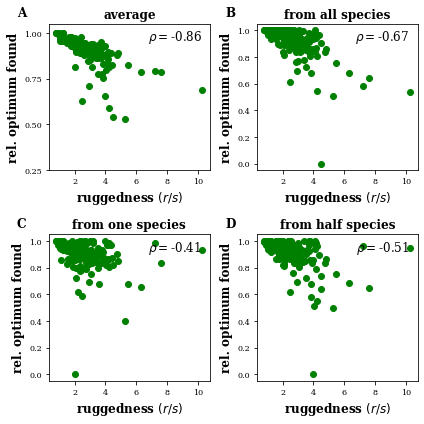

In [10]:
destfolder='/Users/ashish/Dropbox/research/ecology/Figures/Fig_comparing_search_from_diff_starting_points/'

############################ for CR model ############################
fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM_CfixednumGamma_meanC_compiled_AGG/"
parameter_list=OrderedDict([ ('SM',[16] ), ('mean_c', "1 to param1{'LB' : 1}")])
_,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
folder_suffix='SM'


############################ for CR model with M=2S############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SM2_CfixednumGamma_meanC_compiled_AGG/"
# parameter_list=OrderedDict([ ('SM2-',[16] ), ('mean_c', "1 to param1{'step_size' : 2,'LB' : 3,'UB_X':2}")])
# _,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
# folder_suffix='SM2'


############################ for CR model with S=2M ############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CR_cvxpt_2D_SMp5_CfixednumGamma_meanC_compiled_AGG/"
# parameter_list=OrderedDict([ ('SMp5',[16] ), ("mean_c", "1 to param1{'LB' : 1,'step_size' : 1, 'UB_X' : 0.5}")])
# _,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
# folder_suffix='S-2M'

############################ CF meanC ############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CF_CfixedxGamma0Special_meanC_compiled_AGG/"
# parameter_name='mean_c'
# parameter_list={parameter_name:[1,2,3,4,5,6,7,8,9,10,11,12]}
# _,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
# folder_suffix='CF_meanC'


# ########################### CF l ############################
# fold_agg="/Users/ashish/Downloads/ecology_simulation_data/cluster/binaryIC_all/CF_CfixedxGamma01Special_l_compiled_AGG/"
# parameter_name='l'
# ''' l=0 is not included because focal species abundance doesn't make sense for it'''
# parameter_list={parameter_name:[  0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]}
# _,parameter_list, df_keyname_prefix_list=create_replicate_lists(parameter_list,[destfolder],0, return_dfkeynames=True)
# folder_suffix='CF_l'



if not os.path.exists(destfolder): os.makedirs(destfolder)  
ctr=0
for agg_filename in glob.glob(fold_agg+'AggAnalysis_*.dat'):
        ctr+=1
assert ctr==1, print ('number of files that matched was',ctr,'instead')
agg_data=pickle.load(open(agg_filename, 'rb'))

# community_function='Species 2'
community_function='Shannon Diversity'
ylim=[0.25,1.05]
yticks=[0.25,0.5,0.75,1.]




fig = plt.figure(figsize=(6,6)) 
label=''

#######################
Xlabel=r'ruggedness $(r/s)$'

ax4 = fig.add_subplot(2,2,1)
title='average'
Ylabel='rel. optimum found'
Y_key=': '+community_function+': mean_relative_optimum_Greediest' 
X_key=': '+community_function+': r/s' 

Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key) 
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
ax4=plot_SpearmanScatterplot(ax4, Xvalues, Yvalues, label, 'g',text_rho=True)
ax4.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax4.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax4.set_title(title,fontweight="bold",fontsize=fontSize)
if np.min(Yvalues)>ylim[0]:
    ax4.set_ylim(ylim)
    ax4.set_yticks(yticks)
ax4.text(-0.2,1.05,'A',fontweight="bold",transform=ax4.transAxes,fontsize=fontSize)


ax1 = fig.add_subplot(2,2,2) 

title='from all species'
Y_key=': '+community_function+': relative_optimum_Greediest_all_sp'
X_key=': '+community_function+': r/s' 

Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key) 
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
ax1=plot_SpearmanScatterplot(ax1, Xvalues, Yvalues, label, 'g',text_rho=True)
ax1.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax1.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax1.set_title(title,fontweight="bold",fontsize=fontSize)
if np.min(Yvalues)>ylim[0]:
    ax1.set_ylim(ylim)
    ax1.set_yticks(yticks)
ax1.text(-0.2,1.05,'B',fontweight="bold",transform=ax1.transAxes,fontsize=fontSize)

ax2 = fig.add_subplot(2,2,3)
title='from one species'
Y_key=': '+community_function+': relative_optimum_Greediest_one_sp' 
X_key=': '+community_function+': r/s' 

Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key) 
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
ax2=plot_SpearmanScatterplot(ax2, Xvalues, Yvalues, label, 'g',text_rho=True)
ax2.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax2.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax2.set_title(title,fontweight="bold",fontsize=fontSize)
if np.min(Yvalues)>ylim[0]:
    ax2.set_ylim(ylim)
    ax2.set_yticks(yticks)
ax2.text(-0.2,1.05,'C',fontweight="bold",transform=ax2.transAxes,fontsize=fontSize)





ax3 = fig.add_subplot(2,2,4)
title='from half species'
Y_key=': '+community_function+': relative_optimum_Greediest_typical_sp' 
X_key=': '+community_function+': r/s' 

Xvalues, Yvalues= get_XY_from_AGGdict(agg_data,parameter_list,df_keyname_prefix_list,X_key,Y_key) 
Xvalues, Yvalues=remove_Nones(Xvalues,Yvalues) 
ax3=plot_SpearmanScatterplot(ax3, Xvalues, Yvalues, label, 'g',text_rho=True)
ax3.set_ylabel(Ylabel,fontweight="bold",fontsize=fontSize)
ax3.set_xlabel(Xlabel,fontweight="bold",fontsize=fontSize)
ax3.set_title(title,fontweight="bold",fontsize=fontSize)
if np.min(Yvalues)>ylim[0]:
    ax3.set_ylim(ylim)
    ax3.set_yticks(yticks)
ax3.text(-0.2,1.05,'D',fontweight="bold",transform=ax3.transAxes,fontsize=fontSize)


plt.tight_layout()
plt.savefig(destfolder+'Comparing_Search_Corr_search-rugg_'+community_function+folder_suffix+'.pdf')


In [2]:
SpearmanRvalue=spearmanr(np.array([1,2,3]), np.array([1,2,3])).correlation

In [3]:
spearmanr(np.array([1,2,3]), np.array([1,2,3]))

SpearmanrResult(correlation=1.0, pvalue=0.0)